# Technical Analysis

## 1. Introduction

Technical analysis is the use of charts and technical indicators to identify trading signals and price patterns.  Various technical strategies will be investigated using the most common indicators.

## 2. Install/import libraries

In [1]:
!pip install yfinance as yfinance
!pip install mplfinance

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [26]:
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.dates import date2num, DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
import seaborn as sns

import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

from scipy import stats
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

import datetime
from datetime import date, timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 3. Import data

Read in FTSE 100 stock data downloaded from Yahoo! Finance using yfinance API into a pandas dataframe. The stocks chosen are ULVR.L (Unilever), GSK.L (GlaxoSmithKline), AZN.L (AstraZeneca), HSBA.L (HSBC) and BP.L (BP).

In [27]:
ftse100_stocks = pd.read_pickle("../ftse100_stocks.pkl")

ftse100_stocks.head()

ULVR.L                                                     \
              Open         High     Low   Close    Adj Close   Volume   
Date                                                                    
2013-01-02  2396.0  2403.000000  2380.0  2392.0  1668.717041  1761986   
2013-01-03  2397.0  2400.000000  2380.0  2399.0  1673.599609  1253963   
2013-01-04  2393.0  2415.241943  2389.0  2415.0  1684.762329  2138511   
2013-01-07  2414.0  2419.000000  2394.0  2398.0  1672.902344  1453249   
2013-01-08  2394.0  2412.000000  2393.0  2411.0  1681.972168  2174162   

                  GSK.L                                         ...  \
                   Open         High          Low        Close  ...   
Date                                                            ...   
2013-01-02  1349.859253  1380.816406  1346.837158  1368.495361  ...   
2013-01-03  1370.006470  1378.229492  1364.969727  1373.532227  ...   
2013-01-04  1385.116821  1392.168335  1375.043335  1391.664673  ...   
2013-01-07  1388.138916  1390.013550  1381.087402  1382.094849  ...   
2013-01-08  1381.591064  1393.306641  1380.080078  1383.605835  ...   

                  AZN.L                                    HSBA.L              \
                    Low   Close    Adj Close   Volume        Open        High   
Date                                                                            
2013-01-02  2923.000000  2969.0  1974.841675  2394731  656.900024  667.799988   
2013-01-03  2952.500000  2980.0  1982.158203  1763172  663.000000  664.599976   
2013-01-04  2975.211914  3000.0  1995.461304  2041101  660.700012  668.700012   
2013-01-07  2976.000000  2985.0  1985.483765  1185261  669.799988  673.299988   
2013-01-08  2958.500000  3000.0  1995.461304  2723178  662.500000  664.392029   

                                                          
                   Low       Close   Adj Close    Volume  
Date                                                      
2013-01-02  655.599976  665.700012  367.080658  18045934  
2013-01-03  660.799988  662.500000  365.316071  10831799  
2013-01-04  660.000000  667.599976  368.128357  16019794  
2013-01-07  665.900024  666.200012  367.356293  14748401  
2013-01-08  659.200012  659.200012  363.496521  19186720  

[5 rows x 30 columns]

AstraZeneca stock data will be selected for plotting charts and testing various trading strategies to determine when to buy and sell stock.

In [28]:
azn =  ftse100_stocks['AZN.L']
                                     
azn.head()

Open         High          Low   Close    Adj Close   Volume
Date                                                                      
2013-01-02  2930.0  2969.297119  2923.000000  2969.0  1974.841675  2394731
2013-01-03  2969.5  2982.500000  2952.500000  2980.0  1982.158203  1763172
2013-01-04  2992.5  3005.000000  2975.211914  3000.0  1995.461304  2041101
2013-01-07  2998.5  3004.989990  2976.000000  2985.0  1985.483765  1185261
2013-01-08  2986.5  3005.500000  2958.500000  3000.0  1995.461304  2723178

## 4. Visualising stock data

**Japanese candlestick charts** are tools used in a particular trading style called price action to predict market movement through pattern recognition of continuations, breakouts and reversals. 

Unlike a line chart, all of the price information can be viewed in one figure showing the high, low, open and close price of the day or chosen time frame. Price action traders observe patterns formed by green bullish candles where the stock is trending upwards over time, and red or black bearish candles where there is a downward trend.

In [29]:
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    Japanese candlestick chart showing OHLC prices for a specified time period
    
    :param dat: pandas dataframe object with datetime64 index, and float columns "Open", "High", "Low", and "Close"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    :returns: a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "green", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
 
    txt = "AZN.L OHLC stock prices from 01 Jan 2013 - 31 Oct 2022"

    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    sns.set(rc={'figure.figsize':(20, 10)})
    plt.style.use('seaborn-whitegrid')
    plt.title(f"Candlestick chart of {txt}", color = 'black', fontsize = 20)
    plt.xlabel('Date', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
 
    plt.show()

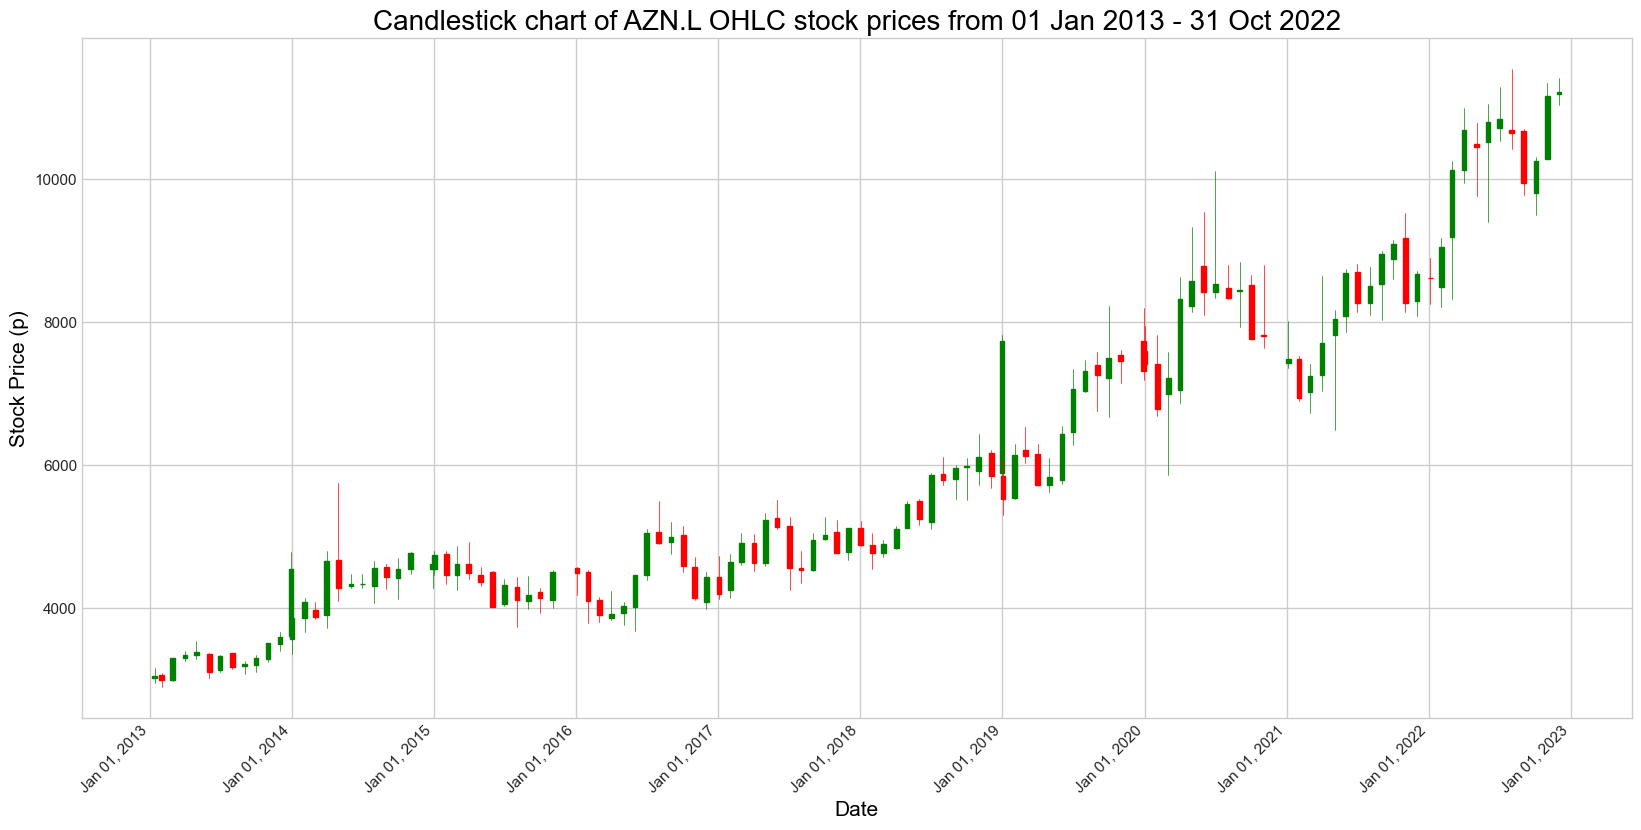

In [12]:
# Plot candlestick chart for 10 year period from 2013-2022

pandas_candlestick_ohlc(azn, stick="month")

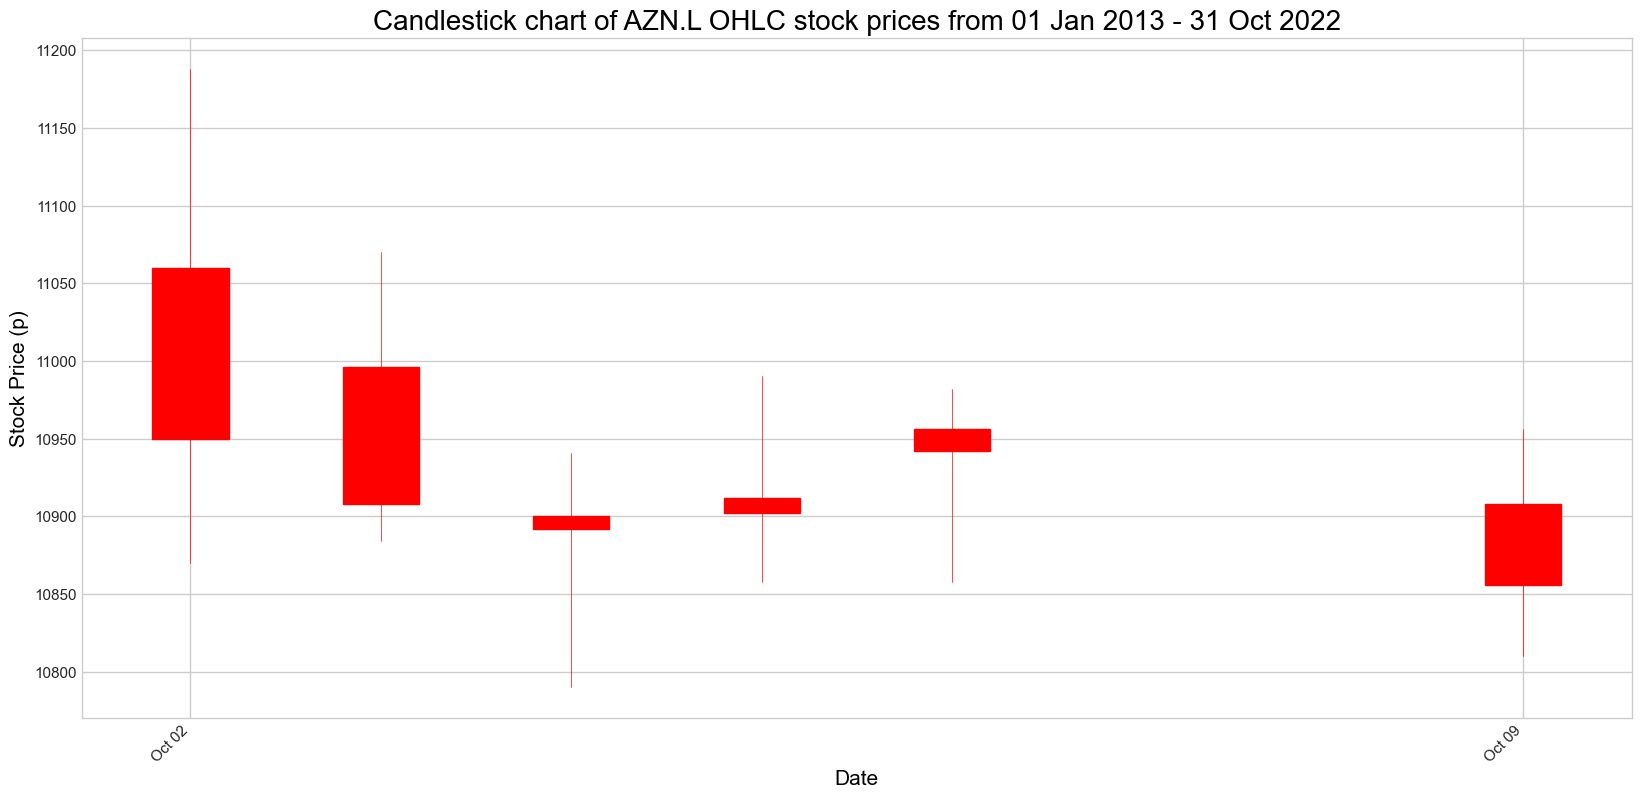

In [30]:
# Plot candlestick chart for one month period for Oct 2023

txt = "AZN.L OHLC stock prices from 01 - 31 Oct 2023"

pandas_candlestick_ohlc(azn['2023-10-01':'2023-10-31'], stick="day")

## 5. Technical Indicators and Strategies

A technical indicator is a series of data points that are derived by applying a formula to the price data of a security. Basically, they are price-derived indicators that use formulas to translate the momentum or price levels into quantifiable time series. 

There are two categories of indicator: **leading** and **lagging**, and four types: **trend**, **momentum**, **volatility** and **volume**, which serve three broad functions: to **alert**, to **confirm** and to **predict**.

## 5.1 Trend-following strategies

Trend-following is about profiting from the prevailing trend through  buying an asset when its price trend goes up, and selling when its trend goes down, expecting price movements to continue.

### 5.1.1 Moving averages
Moving averages smooth a series filtering out noise to help identify trends, one of the fundamental principles of technical analysis being that prices move in trends. Types of moving averages include simple, exponential, smoothed, linear-weighted, MACD, and as lagging indicators they follow the price action and are commonly referred to as trend-following indicators.

### 5.1.2 Simple Moving Average (SMA)

The simplest form of a moving average, known as a Simple Moving Average (SMA), is calculated by taking the arithmetic mean of a given set of values over a set time period.  This model is probably the most naive approach to time series modelling and simply states that the next observation is the mean of all past observations and each value in the time period carries equal weight. 

Modelling this an as average calculation problem we would try to predict the future stock market prices (for example, x<sub>t</sub>+1 ) as an average of the previously observed stock market prices within a fixed size window (for example, x<sub>t</sub>-n, ..., x<sub>t</sub>). This helps smooth out the price data by creating a constantly updated average price so that the impacts of random, short-term fluctuations on
the price of a stock over a specified time-frame are mitigated.

In [31]:
def sma():
  plt.figure(figsize=(15,9))
  ftse100_stocks[ticker]['Adj Close'].loc['2022-01-01':'2022-12-31'].rolling(window=20).mean().plot(label='20 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2022-01-01':'2022-12-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

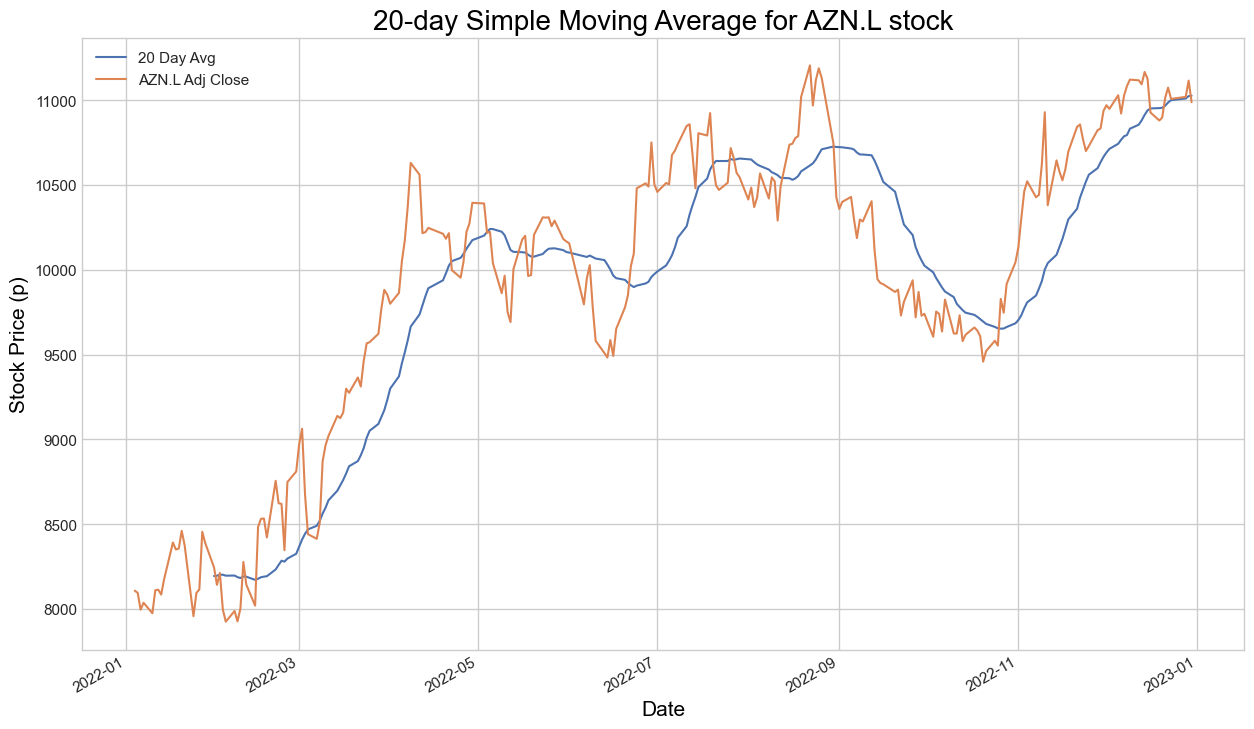

In [32]:
ticker = 'AZN.L'
title_txt = "20-day Simple Moving Average for AZN.L stock"
label_txt = "AZN.L Adj Close"

sma()

The SMA follows the time series removing noise from the
signal and keeping the relevant information about the trend. If the stock price is above its moving average it is assumed that it will likely continue rising in an uptrend. 

### 5.1.3 Moving Average Crossover Strategy

The most popular moving average crossover strategy, and the "Hello World!" of quantitative trading, being the easiest to construct, is based on the simple moving average. When moving averages cross, it is usually confirmation of a change in the prevailing trend, and we want to test whether over the long term the lag caused by the moving average can still give us profitable trades.

Depending on the type of investor or trader (high risk vs. low risk, short-term vs. long-term trading), you can adjust your moving ‘time’ average (10 days, 20 days, 50 days, 200 days, 1 year, 5 years, etc). The longer the period of an SMA, the longer the time horizon of the trend it spots. The most commonly used SMA periods are 20 for short-term (swing) trading, 50 for medium-term (position) trading and 200 for long-term (portfolio) trading.

There is no single right answer and this will vary according to whether a trader is planning to buy when the trend is going down and sell when it's going up, potentially making short-term gains, or to hold for a more long-term investment.

In [33]:
def sma2():
  plt.figure(figsize=(15,9))
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].rolling(window=20).mean().plot(label='20 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].rolling(window=50).mean().plot(label='50 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].rolling(window=200).mean().plot(label='200 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

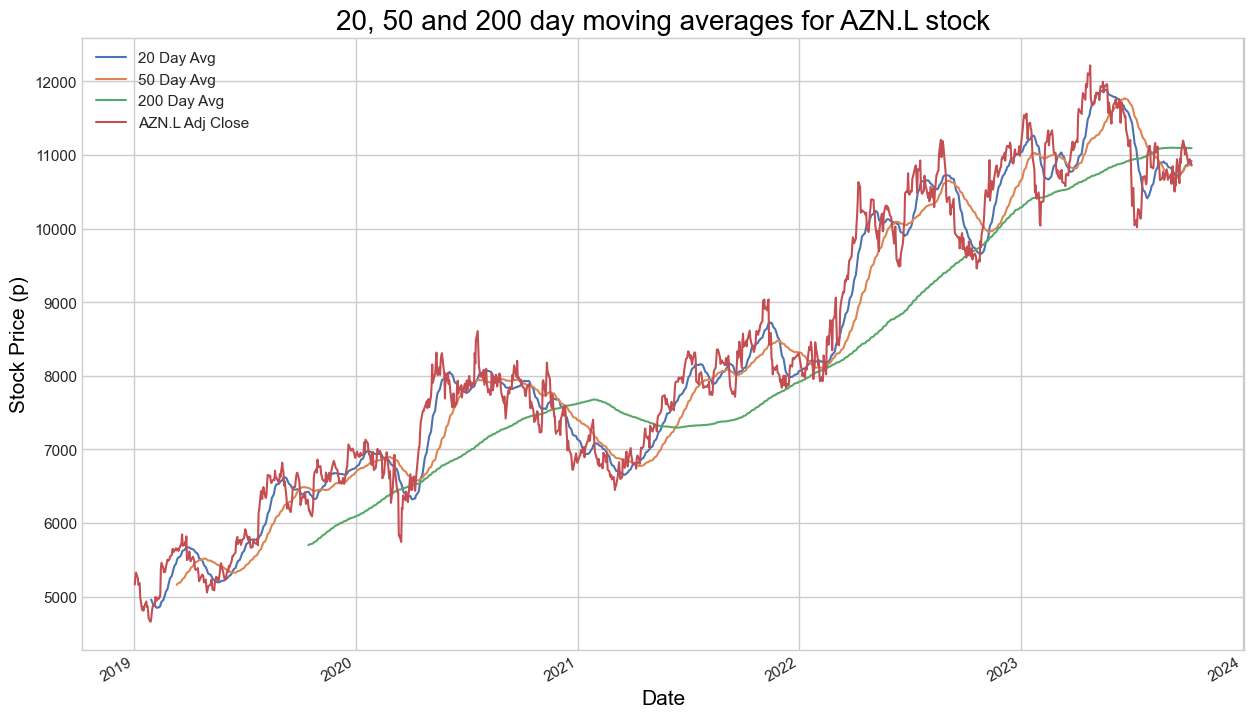

In [34]:
ticker = 'AZN.L'

title_txt = "20, 50 and 200 day moving averages for AZN.L stock"
label_txt = "AZN.L Adj Close"

sma2()

The chart shows that the 20-day moving average is the most sensitive to local changes, and the 200-day moving average the least. Here, the 200-day moving average indicates an overall bullish trend - the stock is trending upward over time. The 20- and 50-day moving averages are at times bearish and at other times bullish.

The major drawback of moving averages, however, is that because they are lagging, and smooth out prices, they tend to recognise reversals too late and are therefore not very helpful when used alone.

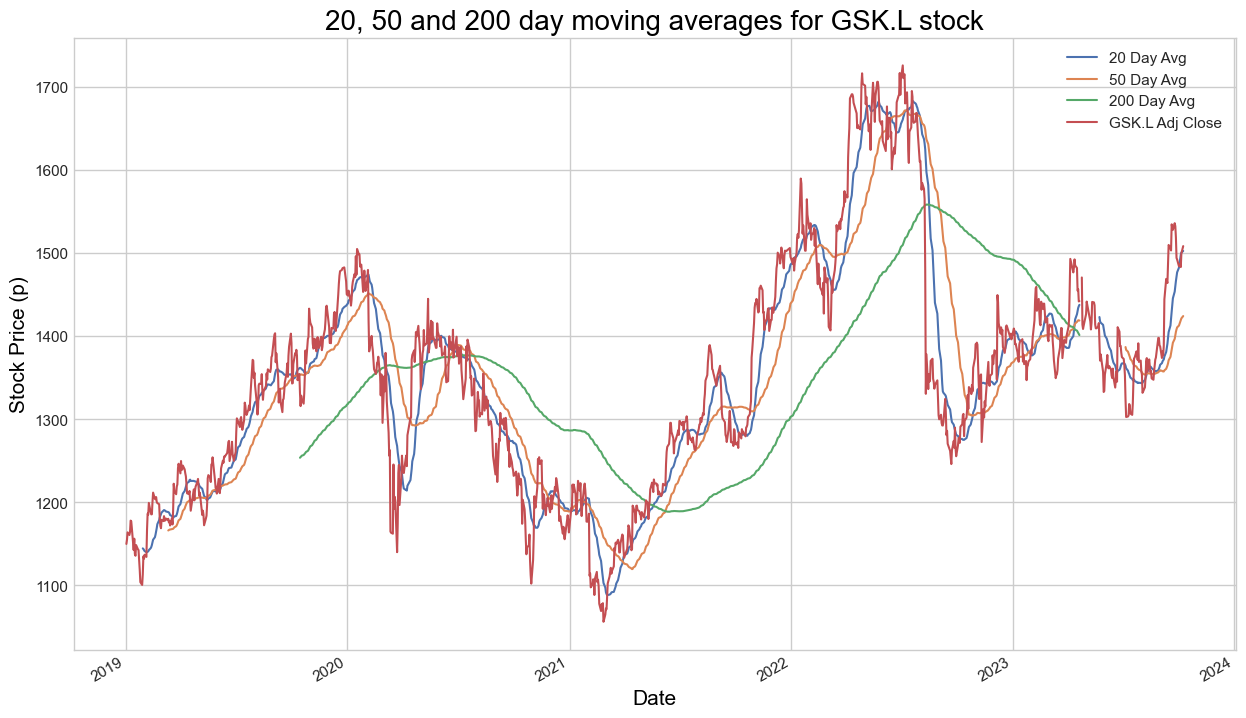

In [35]:
# 20, 50 and 200 day MA repeated for GlaxoSmithKline Adjusted Close price data for the same time period 

ticker = 'GSK.L'

title_txt = "20, 50 and 200 day moving averages for GSK.L stock"
label_txt = "GSK.L Adj Close"

sma2()

### Trading Strategy

The moving average crossover trading strategy will be to take two moving averages - 20-day (fast) and 200-day (slow) - and to go long (buy) when the fast MA goes above the slow MA and to go short (sell) when the fast MA goes below the slow MA.

In [36]:
# Create copy of dataframe for AstraZeneca data for 2010-2019

azn_sma = azn.copy()

In [ ]:
azn_sma

Open    High          Low   Close    Adj Close   Volume
Date                                                                 
2010-01-04  2912.0  2946.0  2912.000000  2941.0  1775.206909  2091679
2010-01-05  2936.0  2949.5  2901.000000  2907.5  1754.986084  2869739
2010-01-06  2909.0  2909.0  2850.500000  2875.0  1735.368652  3136541
2010-01-07  2879.0  2925.5  2879.000000  2910.5  1756.796875  3748200
2010-01-08  2921.0  2927.5  2889.500000  2908.5  1755.589600  2473846
...            ...     ...          ...     ...          ...      ...
2019-12-20  7658.0  7808.0  7614.000000  7808.0  7592.499512  5860381
2019-12-23  7771.0  7824.0  7723.870117  7746.0  7532.210938  2183949
2019-12-24  7715.0  7794.0  7631.290039  7714.0  7501.093750   378885
2019-12-27  7706.0  7781.0  7641.000000  7745.0  7531.238281   862283
2019-12-30  7734.0  7767.0  7654.000000  7654.0  7442.750488  1394124

[2518 rows x 6 columns]

In [38]:
  # Calculate and add columns for moving averages of Adjusted Close price data
  
azn_sma["20d"] = np.round(azn_sma["Adj Close"].rolling(window = 20, center = False).mean(), 2)
azn_sma["50d"] = np.round(azn_sma["Adj Close"].rolling(window = 50, center = False).mean(), 2)
azn_sma["200d"] = np.round(azn_sma["Adj Close"].rolling(window = 200, center = False).mean(), 2)

In [ ]:
azn_sma.tail()

Open    High          Low  ...      20d      50d     200d
Date                                     ...                           
2019-12-20  7658.0  7808.0  7614.000000  ...  7204.07  7096.07  6504.40
2019-12-23  7771.0  7824.0  7723.870117  ...  7214.28  7110.99  6511.67
2019-12-24  7715.0  7794.0  7631.290039  ...  7221.77  7127.11  6518.94
2019-12-27  7706.0  7781.0  7641.000000  ...  7232.27  7145.20  6526.30
2019-12-30  7734.0  7767.0  7654.000000  ...  7239.76  7161.40  6533.15

[5 rows x 9 columns]

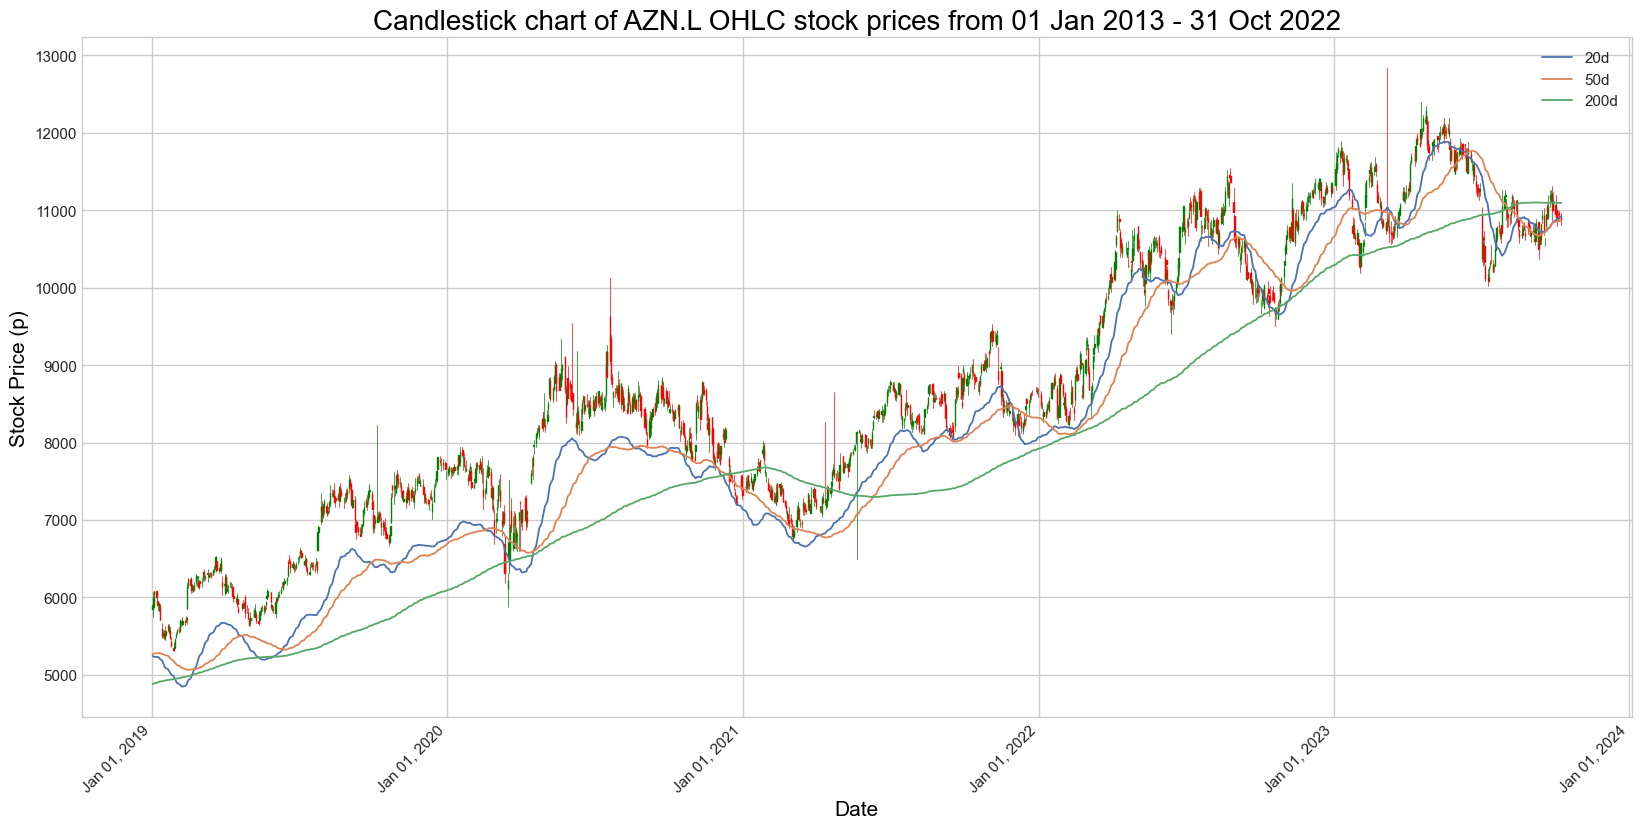

In [39]:
txt = "20, 50 and 200 day moving averages for AZN.L stock"

# Slice rows to plot data from 2016-2019 
pandas_candlestick_ohlc(azn_sma.loc['2019-01-01':'2023-10-31',:], otherseries = ["20d", "50d", "200d"])

### Backtesting

Before using the strategy we will evaluate the quality of it first by backtesting, or looking at how profitable it is on historical data.

In [40]:
# Identify when the 20-day average is below the 200-day average, and vice versa.

azn_sma['20d-200d'] = azn_sma['20d'] - azn_sma['200d']
azn_sma.tail()

Open          High      Low    Close  Adj Close   Volume  \
Date                                                                      
2023-10-03  10996.0  11070.000000  10884.0  10908.0    10908.0  1297146   
2023-10-04  10900.0  10940.451172  10790.0  10892.0    10892.0  2200732   
2023-10-05  10912.0  10990.000000  10858.0  10902.0    10902.0  1102217   
2023-10-06  10956.0  10982.000000  10858.0  10942.0    10942.0  1250802   
2023-10-09  10908.0  10956.000000  10810.0  10856.0    10856.0  2558599   

                20d       50d      200d  20d-200d  
Date                                               
2023-10-03  10873.3  10850.87  11092.79   -219.49  
2023-10-04  10887.6  10855.68  11091.61   -204.01  
2023-10-05  10891.5  10861.70  11091.48   -199.98  
2023-10-06  10896.3  10867.91  11091.79   -195.49  
2023-10-09  10914.0  10865.29  11091.58   -177.58

Text(0, 0.5, 'Regime')

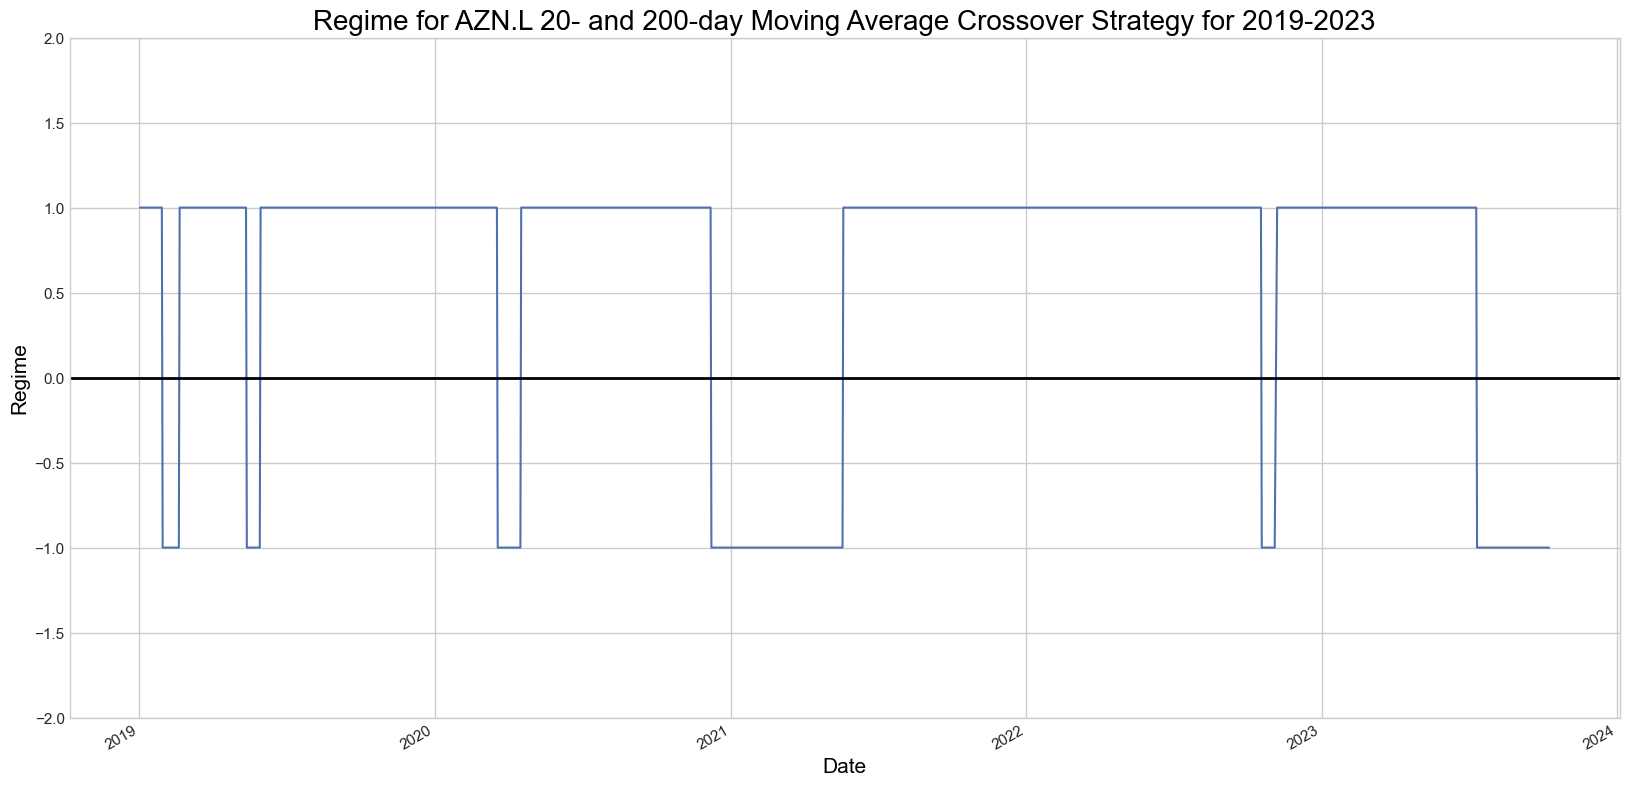

In [41]:
# The sign of this difference is the regime; that is, if the fast moving average is above the slow moving average, 
# this is a bullish regime, and a bearish regime holds when the fast moving average is below the slow moving average

# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
azn_sma["Regime"] = np.where(azn_sma['20d-200d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Replace bearish regime's values with -1, and to maintain the rest of the vector, the second argument is azn_sma["Regime"]
azn_sma["Regime"] = np.where(azn_sma['20d-200d'] < 0, -1, azn_sma["Regime"])
azn_sma.loc['2019-01-01':'2023-10-31',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)
plt.title("Regime for AZN.L 20- and 200-day Moving Average Crossover Strategy for 2019-2023", color = 'black', fontsize = 20)
plt.xlabel('Date', color = 'black', fontsize = 15)
plt.ylabel('Regime', color = 'black', fontsize = 15)

Text(0, 0.5, 'Regime')

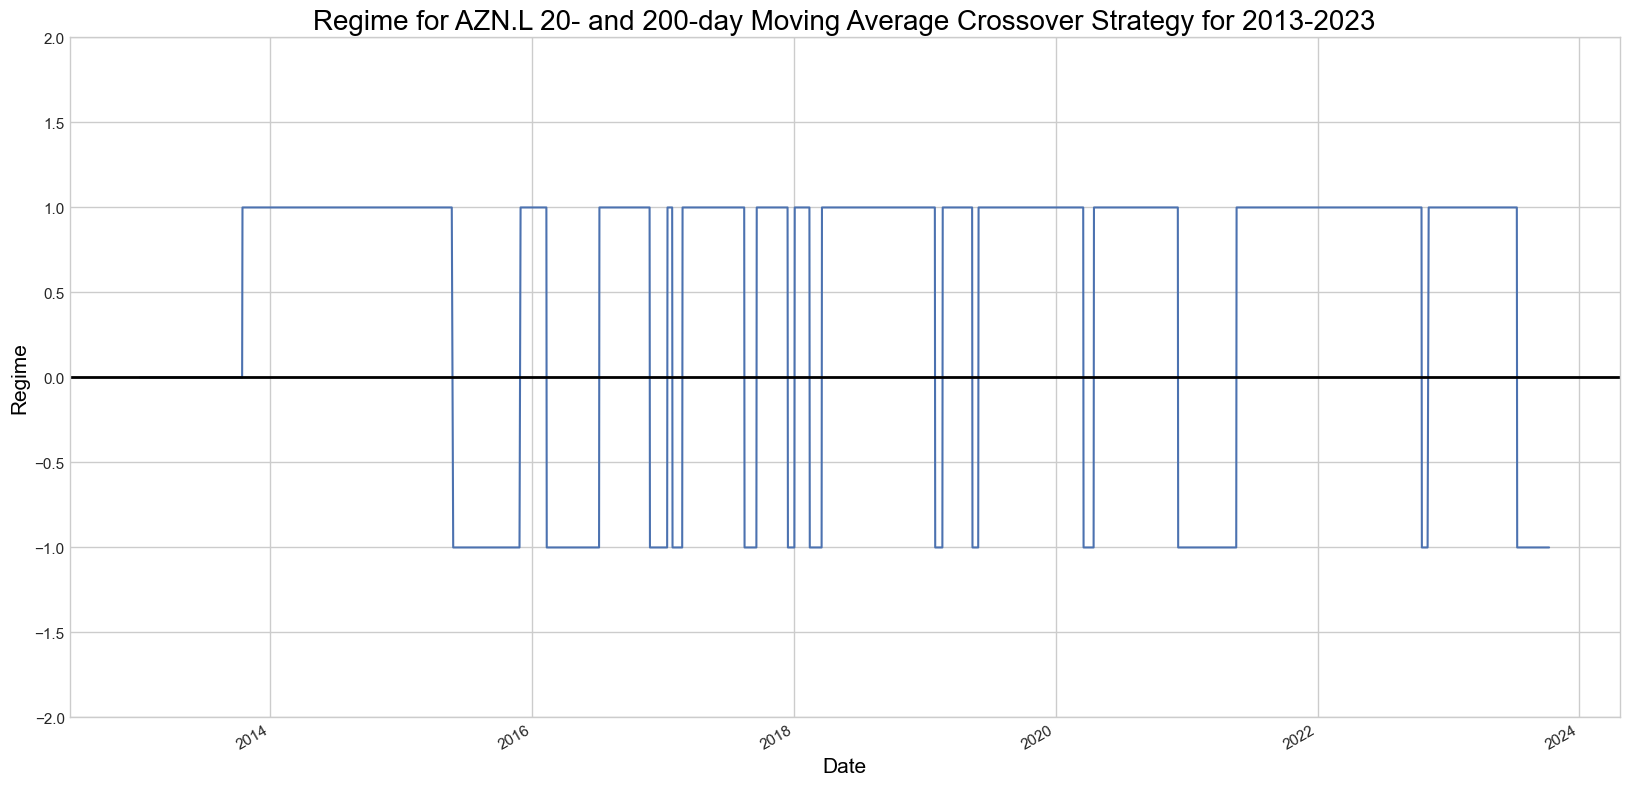

In [42]:
azn_sma["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2);
plt.title("Regime for AZN.L 20- and 200-day Moving Average Crossover Strategy for 2013-2023", color = 'black', fontsize = 20)
plt.xlabel('Date', color = 'black', fontsize = 15)
plt.ylabel('Regime', color = 'black', fontsize = 15)

In [43]:
# Number of bullish and bearish days

azn_sma["Regime"].value_counts()

 1    1946
-1     576
 0     199
Name: Regime, dtype: int64

For 1715 days the market was bullish, for 604 days it was bearish, and neutral for 199 days for the time period 2010-2019.

In [ ]:
azn_sma

Open    High          Low  ...     200d  20d-200d  Regime
Date                                     ...                           
2010-01-04  2912.0  2946.0  2912.000000  ...      NaN       NaN       0
2010-01-05  2936.0  2949.5  2901.000000  ...      NaN       NaN       0
2010-01-06  2909.0  2909.0  2850.500000  ...      NaN       NaN       0
2010-01-07  2879.0  2925.5  2879.000000  ...      NaN       NaN       0
2010-01-08  2921.0  2927.5  2889.500000  ...      NaN       NaN       0
...            ...     ...          ...  ...      ...       ...     ...
2019-12-20  7658.0  7808.0  7614.000000  ...  6504.40    699.67       1
2019-12-23  7771.0  7824.0  7723.870117  ...  6511.67    702.61       1
2019-12-24  7715.0  7794.0  7631.290039  ...  6518.94    702.83       1
2019-12-27  7706.0  7781.0  7641.000000  ...  6526.30    705.97       1
2019-12-30  7734.0  7767.0  7654.000000  ...  6533.15    706.61       1

[2518 rows x 11 columns]

In [44]:
# Obtain signals with -1 indicating “sell”, 1 indicating “buy”, and 0 no action
# To ensure that all trades close out, temporarily change the regime of the last row to 0
regime_orig = azn_sma.iloc[-1, 10]
azn_sma.iloc[-1, 10] = 0
azn_sma["Signal"] = np.sign(azn_sma["Regime"] - azn_sma["Regime"].shift(1))
# Restore original regime data
azn_sma.iloc[-1, 10] = regime_orig
azn_sma.tail()

Open          High      Low    Close  Adj Close   Volume  \
Date                                                                      
2023-10-03  10996.0  11070.000000  10884.0  10908.0    10908.0  1297146   
2023-10-04  10900.0  10940.451172  10790.0  10892.0    10892.0  2200732   
2023-10-05  10912.0  10990.000000  10858.0  10902.0    10902.0  1102217   
2023-10-06  10956.0  10982.000000  10858.0  10942.0    10942.0  1250802   
2023-10-09  10908.0  10956.000000  10810.0  10856.0    10856.0  2558599   

                20d       50d      200d  20d-200d  Regime  Signal  
Date                                                               
2023-10-03  10873.3  10850.87  11092.79   -219.49      -1     0.0  
2023-10-04  10887.6  10855.68  11091.61   -204.01      -1     0.0  
2023-10-05  10891.5  10861.70  11091.48   -199.98      -1     0.0  
2023-10-06  10896.3  10867.91  11091.79   -195.49      -1     0.0  
2023-10-09  10914.0  10865.29  11091.58   -177.58      -1     1.0

Text(0, 0.5, 'Trading signal')

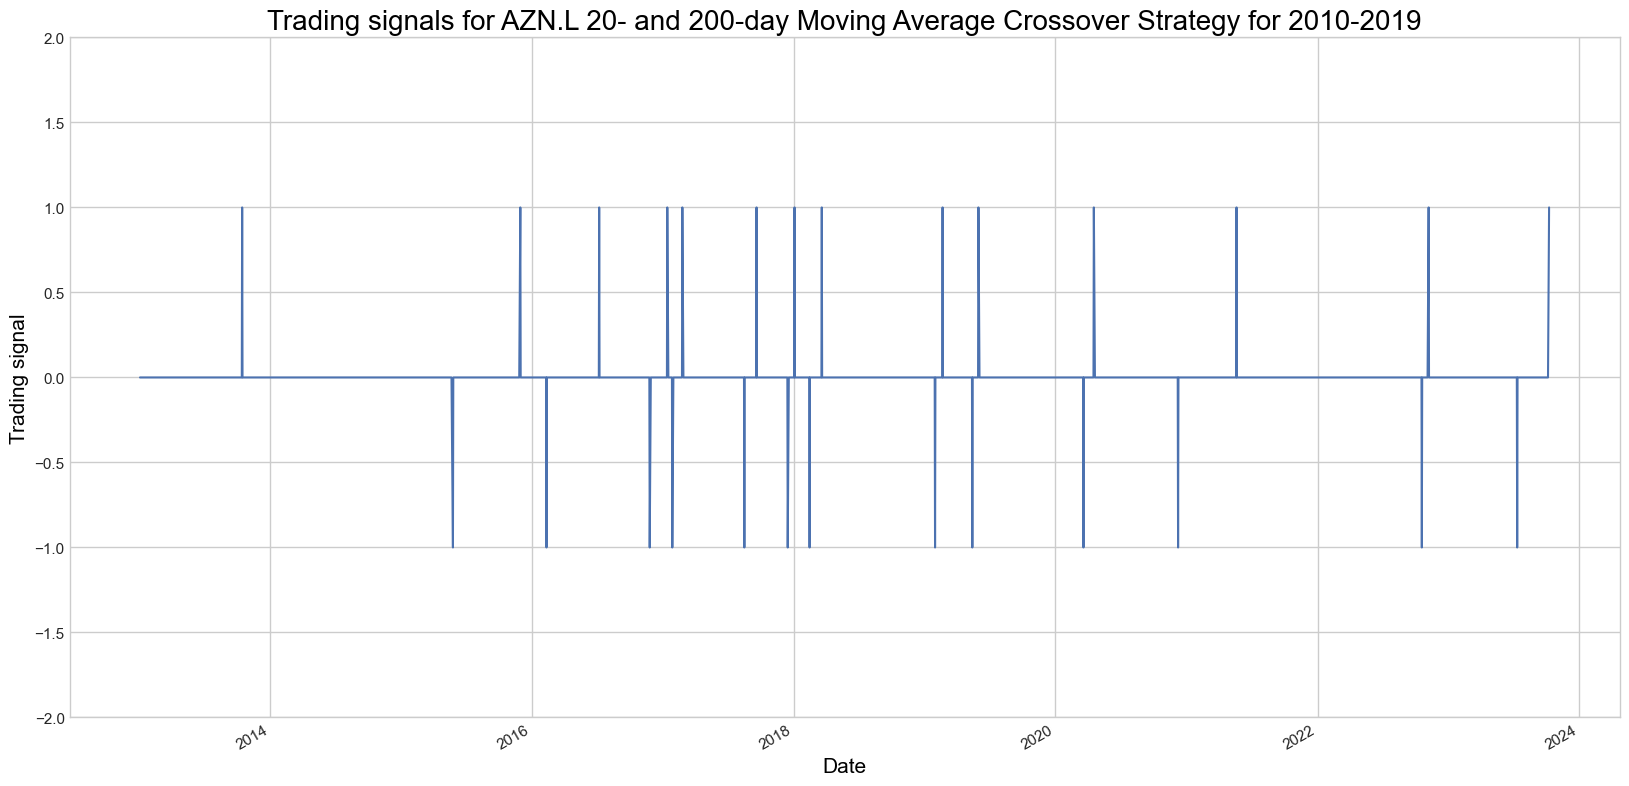

In [45]:
azn_sma["Signal"].plot(ylim = (-2, 2));
plt.title("Trading signals for AZN.L 20- and 200-day Moving Average Crossover Strategy for 2010-2019", color = 'black', fontsize = 20)
plt.xlabel('Date', color = 'black', fontsize = 15)
plt.ylabel('Trading signal', color = 'black', fontsize = 15)

In [46]:
# Unique counts of trading signals

azn_sma["Signal"].value_counts()

 0.0    2693
 1.0      14
-1.0      13
Name: Signal, dtype: int64

We would buy AstraZeneca stock 14 times and sell 14 times. If we only go long 14 trades will be engaged in over the 10-year period, while if we pivot from a long to a short position every time a long position is terminated, we would engage in 14 trades total. It is worth bearing in mind that trading more frequently isn’t necessarily good as trades are never free.

In [47]:
# Identify what the price of the stock is at every buy.

azn_sma.loc[azn_sma["Signal"] == 1, "Close"]

Date
2013-10-15     3183.0
2015-11-30     4502.5
2016-07-07     4593.5
2017-01-13     4609.0
2017-02-24     4609.0
2017-09-19     4774.0
2018-01-03     5166.0
2018-03-20     4868.0
2019-02-20     6143.0
2019-05-31     5833.0
2020-04-17     7970.0
2021-05-20     8131.0
2022-11-07    10646.0
2023-10-09    10856.0
Name: Close, dtype: float64

In [ ]:
# Identify what the price of the stock is at every sell.

azn_sma.loc[azn_sma["Signal"] == -1, "Close"]

Date
2010-11-29    3023.0
2011-08-08    2595.0
2011-11-22    2783.0
2012-04-26    2666.5
2015-05-27    4468.5
2016-02-11    3991.0
2016-11-25    4301.5
2017-01-27    4239.0
2017-08-16    4467.5
2017-12-15    4881.0
2018-02-14    4830.0
2019-01-30    5464.0
2019-05-14    5803.0
2019-12-30    7654.0
Name: Close, dtype: float64

In [48]:
# Create a dataframe with trades, including the price at the trade and the regime under which the trade is made.

azn_signals = pd.concat([
        pd.DataFrame({"Price": azn_sma.loc[azn_sma["Signal"] == 1, "Adj Close"],
                     "Regime": azn_sma.loc[azn_sma["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": azn_sma.loc[azn_sma["Signal"] == -1, "Adj Close"],
                     "Regime": azn_sma.loc[azn_sma["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
azn_signals.sort_index(inplace = True)
azn_signals

Price  Regime Signal
Date                                   
2013-10-15   2245.357666       1    Buy
2015-05-26   3309.409180      -1   Sell
2015-11-30   3453.325195       1    Buy
2016-02-11   3061.014893      -1   Sell
2016-07-07   3634.372559       1    Buy
2016-11-25   3449.265625      -1   Sell
2017-01-13   3695.842041       1    Buy
2017-01-27   3399.148438      -1   Sell
2017-02-24   3818.281494       1    Buy
2017-08-16   3758.528564      -1   Sell
2017-09-19   4016.387451       1    Buy
2017-12-15   4106.406738      -1   Sell
2018-01-03   4346.178711       1    Buy
2018-02-14   4063.501221      -1   Sell
2018-03-20   4211.974609       1    Buy
2019-01-30   4782.274902      -1   Sell
2019-02-20   5376.558594       1    Buy
2019-05-14   5200.486328      -1   Sell
2019-05-31   5227.371582       1    Buy
2020-03-19   6377.171387      -1   Sell
2020-04-17   7360.761230       1    Buy
2020-12-08   7572.813965      -1   Sell
2021-05-20   7718.979980       1    Buy
2022-10-19   9608.046875      -1   Sell
2022-11-07  10427.899414       1    Buy
2023-07-12  10182.197266      -1   Sell
2023-10-09  10856.000000      -1    Buy

In [49]:
# Let's see the profitability of long trades

azn_long_profits = pd.DataFrame({
        "Price": azn_signals.loc[(azn_signals["Signal"] == "Buy") &
                                  azn_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(azn_signals["Price"] - azn_signals["Price"].shift(1)).loc[
            azn_signals.loc[(azn_signals["Signal"].shift(1) == "Buy") & (azn_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": azn_signals["Price"].loc[
            azn_signals.loc[(azn_signals["Signal"].shift(1) == "Buy") & (azn_signals["Regime"].shift(1) == 1)].index
        ].index
    })
azn_long_profits

ValueError: array length 13 does not match index length 14

### 5.1.4 Exponential Moving Average

In a Simple Moving Average, each value in the time period carries
equal weight, and values outside of the time period are not included in the average. However, the Exponential Moving Average is a cumulative calculation where a different decreasing weight is assigned to each observation. Past values have a diminishing contribution to the average, while more recent values have a greater contribution. This method allows the moving average to be more responsive to changes in the data.

In [50]:
# 20-day EMA for Adjusted Close price for 2019

def ewma():
  plt.figure(figsize=(15,9))
  ftse100_stocks[ticker]['Adj Close'].loc['2022-01-01':'2022-12-31'].ewm(20).mean().plot(label='20 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2022-01-01':'2022-12-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

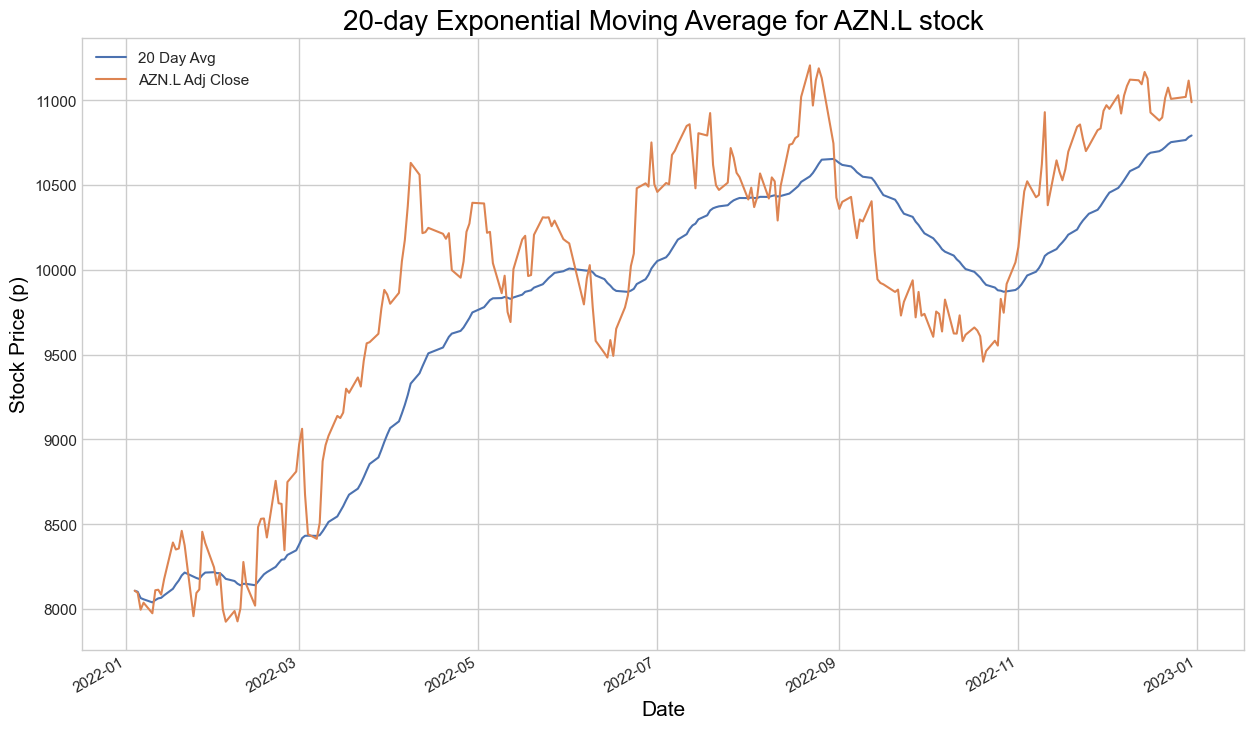

In [51]:
ticker = 'AZN.L'
title_txt = "20-day Exponential Moving Average for AZN.L stock"
label_txt = "AZN.L Adj Close"

ewma()

In [52]:
# 20-, 50- and 200-day EMA for Adjusted Close price for 2016-2019

def ewma2():
  plt.figure(figsize=(15,9))
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].ewm(20).mean().plot(label='20 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].ewm(50).mean().plot(label='50 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].ewm(200).mean().plot(label='200 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

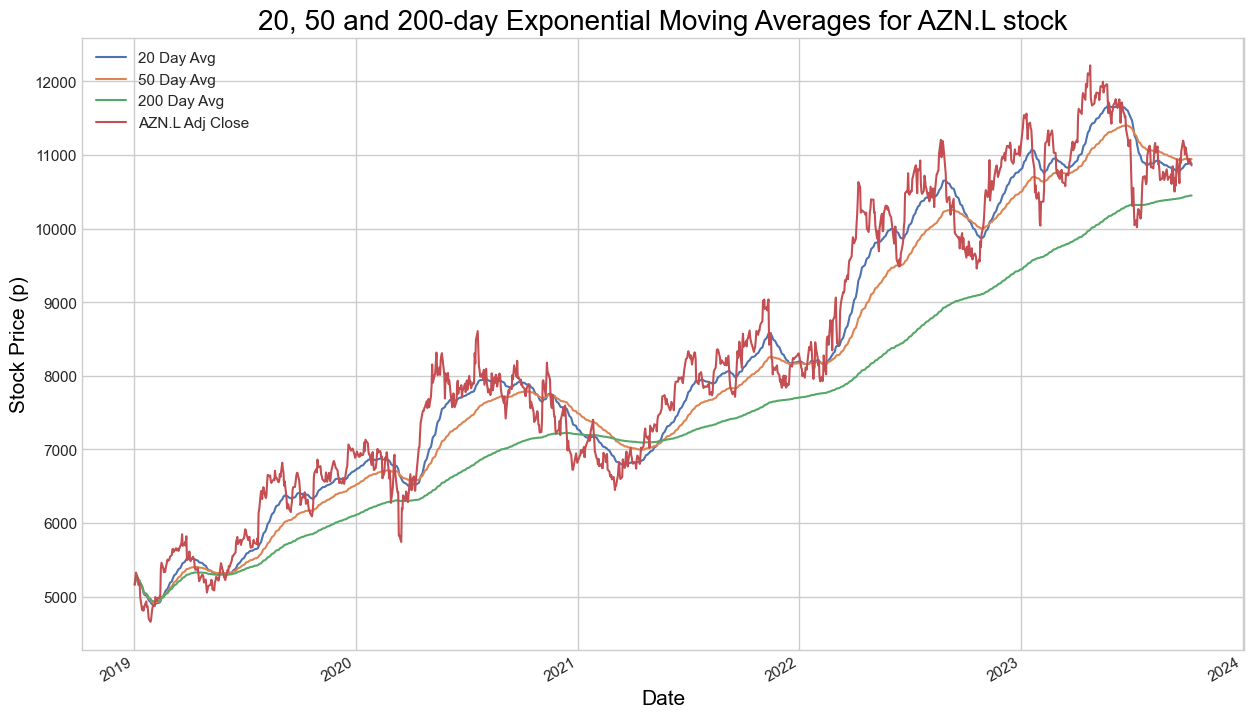

In [53]:
ticker = 'AZN.L'
title_txt = "20, 50 and 200-day Exponential Moving Averages for AZN.L stock"
label_txt = "AZN.L Adj Close"

ewma2()

### 5.1.5 Triple Moving Average Crossover Strategy

This strategy uses three moving moving averages - short/fast, middle/medium and long/slow - and has two buy and sell signals. 

The first is to buy when the middle/medium moving average crosses above the long/slow moving average and the short/fast moving average crosses above the middle/medium moving average. If we use this buy signal the strategy is to sell if the short/fast moving average crosses below the middle/medium moving average.

The second is to buy when the middle/medium moving average crosses below the long/slow moving average and the short/fast moving average crosses below the middle/medium moving average. If we use this buy signal the strategy is to sell if the short/fast moving average crosses above the middle/medium moving average.

In [54]:
azn[['Adj Close']]['2023-05-01':'2023-10-31']

Adj Close
Date                    
2023-05-02  11698.398438
2023-05-03  11807.692383
2023-05-04  11773.911133
2023-05-05  11845.448242
2023-05-09  11837.500000
...                  ...
2023-10-03  10908.000000
2023-10-04  10892.000000
2023-10-05  10902.000000
2023-10-06  10942.000000
2023-10-09  10856.000000

[112 rows x 1 columns]

In [55]:
def adj_6mo():
  sns.set(rc={'figure.figsize':(15, 9)})
  ftse100_stocks[ticker]['Adj Close'].loc['2023-05-01':'2023-10-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

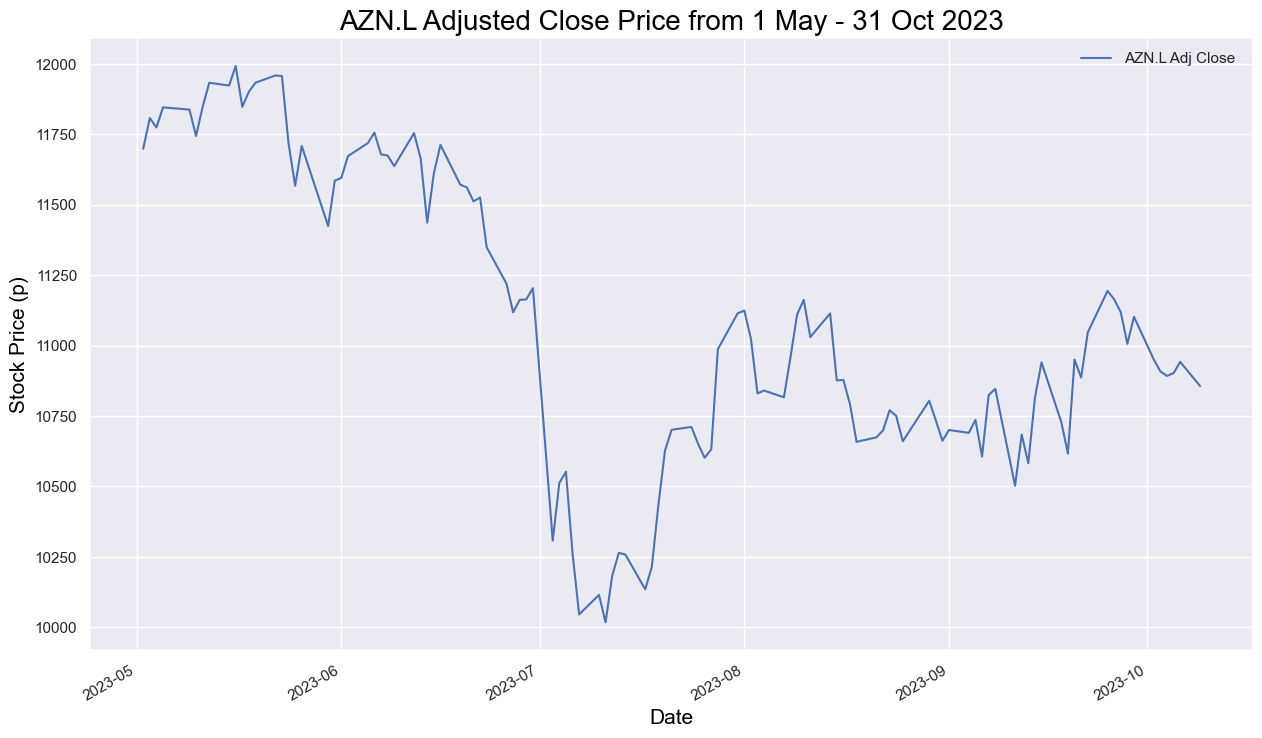

In [56]:
ticker = 'AZN.L'
title_txt = "AZN.L Adjusted Close Price from 1 May - 31 Oct 2023"
label_txt = "AZN.L Adj Close "

adj_6mo()

In [59]:
azn_adj_6mo = azn[['Adj Close']]['2023-05-01':'2023-10-31']

In [60]:
ShortEMA = azn_adj_6mo['Adj Close'].ewm(span=5, adjust=False).mean()
MiddleEMA = azn_adj_6mo['Adj Close'].ewm(span=21, adjust=False).mean()
LongEMA = azn_adj_6mo['Adj Close'].ewm(span=63, adjust=False).mean()

In [61]:
def ewma3():
  sns.set(rc={'figure.figsize':(15, 9)})
  plt.plot(ftse100_stocks[ticker]['Adj Close'].loc['2023-05-01':'2023-10-31'], label=f"{label_txt}", color = 'blue')
  plt.plot(ShortEMA, label = 'Short/Fast EMA', color = 'red')
  plt.plot(MiddleEMA, label = 'Middle/Medium EMA', color = 'orange')
  plt.plot(LongEMA, label = 'Long/Slow EMA', color = 'green')
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

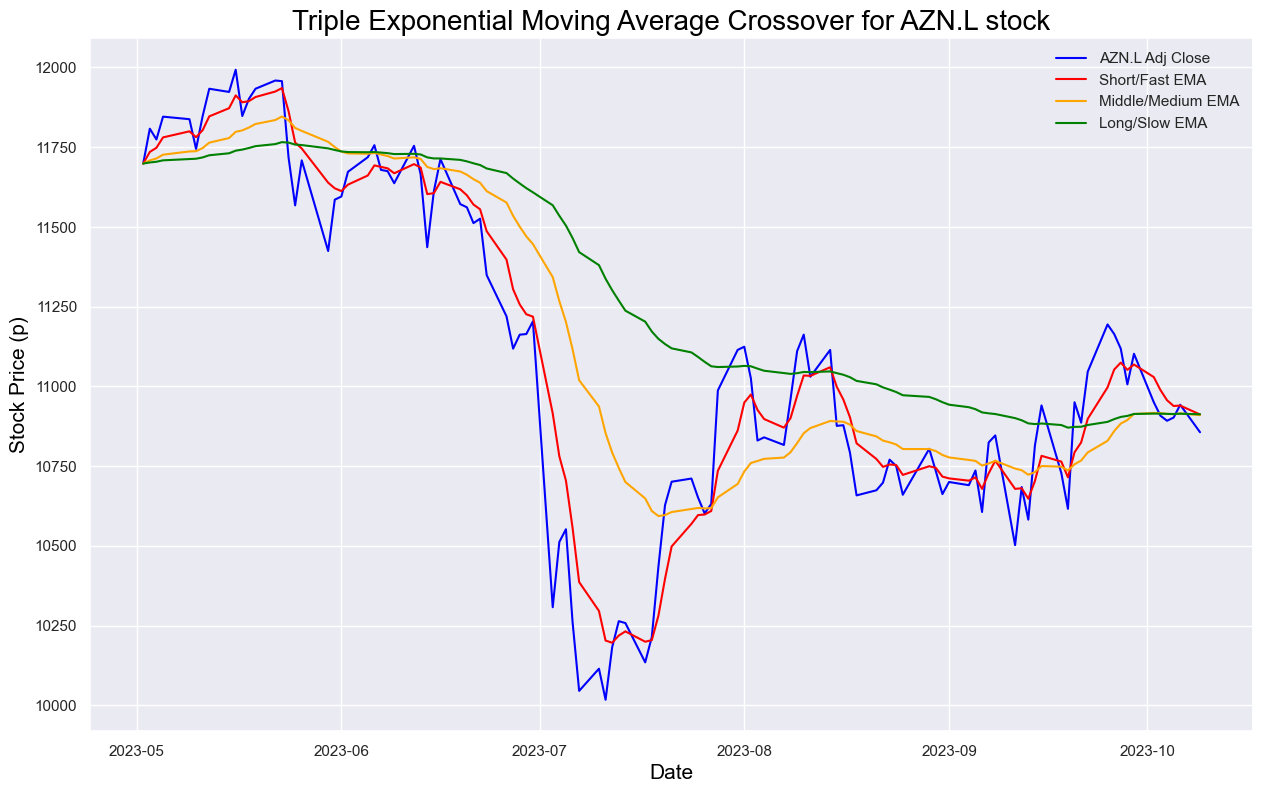

In [62]:
ticker = 'AZN.L'
title_txt = "Triple Exponential Moving Average Crossover for AZN.L stock"
label_txt = "AZN.L Adj Close"

ewma3()

In [63]:
azn_adj_6mo['Short'] = ShortEMA
azn_adj_6mo['Middle'] = MiddleEMA
azn_adj_6mo['Long'] = LongEMA

In [64]:
azn_adj_6mo

Adj Close         Short        Middle          Long
Date                                                              
2023-05-02  11698.398438  11698.398438  11698.398438  11698.398438
2023-05-03  11807.692383  11734.829753  11708.334251  11701.813873
2023-05-04  11773.911133  11747.856879  11714.295785  11704.066913
2023-05-05  11845.448242  11780.387334  11726.218736  11708.485079
2023-05-09  11837.500000  11799.424889  11736.335215  11712.516795
...                  ...           ...           ...           ...
2023-10-03  10908.000000  10988.604742  10915.732474  10914.234258
2023-10-04  10892.000000  10956.403161  10913.574976  10913.539437
2023-10-05  10902.000000  10938.268774  10912.522705  10913.178830
2023-10-06  10942.000000  10939.512516  10915.202459  10914.079492
2023-10-09  10856.000000  10911.675011  10909.820418  10912.264507

[112 rows x 4 columns]

In [65]:
def buy_sell_ewma3(data):
  
  buy_list = []
  sell_list = []
  flag_long = False
  flag_short = False

  for i in range(0, len(data)):
    if data['Middle'][i] < data['Long'][i] and data['Short'][i] < data['Middle'][i] and flag_long == False and flag_short == False:
      buy_list.append(data['Adj Close'][i])
      sell_list.append(np.nan)
      flag_short = True
    elif flag_short == True and data['Short'][i] > data['Middle'][i]:
      sell_list.append(data['Adj Close'][i])
      buy_list.append(np.nan)
      flag_short = False
    elif data['Middle'][i] > data['Long'][i] and data['Short'][i] > data['Middle'][i] and flag_long == False and flag_short == False:
      buy_list.append(data['Adj Close'][i])
      sell_list.append(np.nan)
      flag_long = True
    elif flag_long == True and data['Short'][i] < data['Middle'][i]:
      sell_list.append(data['Adj Close'][i])
      buy_list.append(np.nan)
      flag_long = False
    else:
      buy_list.append(np.nan)
      sell_list.append(np.nan)
  
  return (buy_list, sell_list)

In [66]:
azn_adj_6mo['Buy'] = buy_sell_ewma3(azn_adj_6mo)[0]
azn_adj_6mo['Sell'] = buy_sell_ewma3(azn_adj_6mo)[1]

In [67]:
def buy_sell_ewma3_plot():
  sns.set(rc={'figure.figsize':(18, 10)})
  plt.plot(ftse100_stocks[ticker]['Adj Close'].loc['2023-05-01':'2023-10-31'], label=f"{label_txt}", color = 'blue', alpha = 0.35)
  plt.plot(ShortEMA, label = 'Short/Fast EMA', color = 'red', alpha = 0.35)
  plt.plot(MiddleEMA, label = 'Middle/Medium EMA', color = 'orange', alpha = 0.35)
  plt.plot(LongEMA, label = 'Long/Slow EMA', color = 'green', alpha = 0.35)
  plt.scatter(azn_adj_6mo.index, azn_adj_6mo['Buy'], color = 'green', label = 'Buy Signal', marker = '^', alpha = 1)
  plt.scatter(azn_adj_6mo.index, azn_adj_6mo['Sell'], color = 'red', label = 'Buy Signal', marker='v', alpha = 1)
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

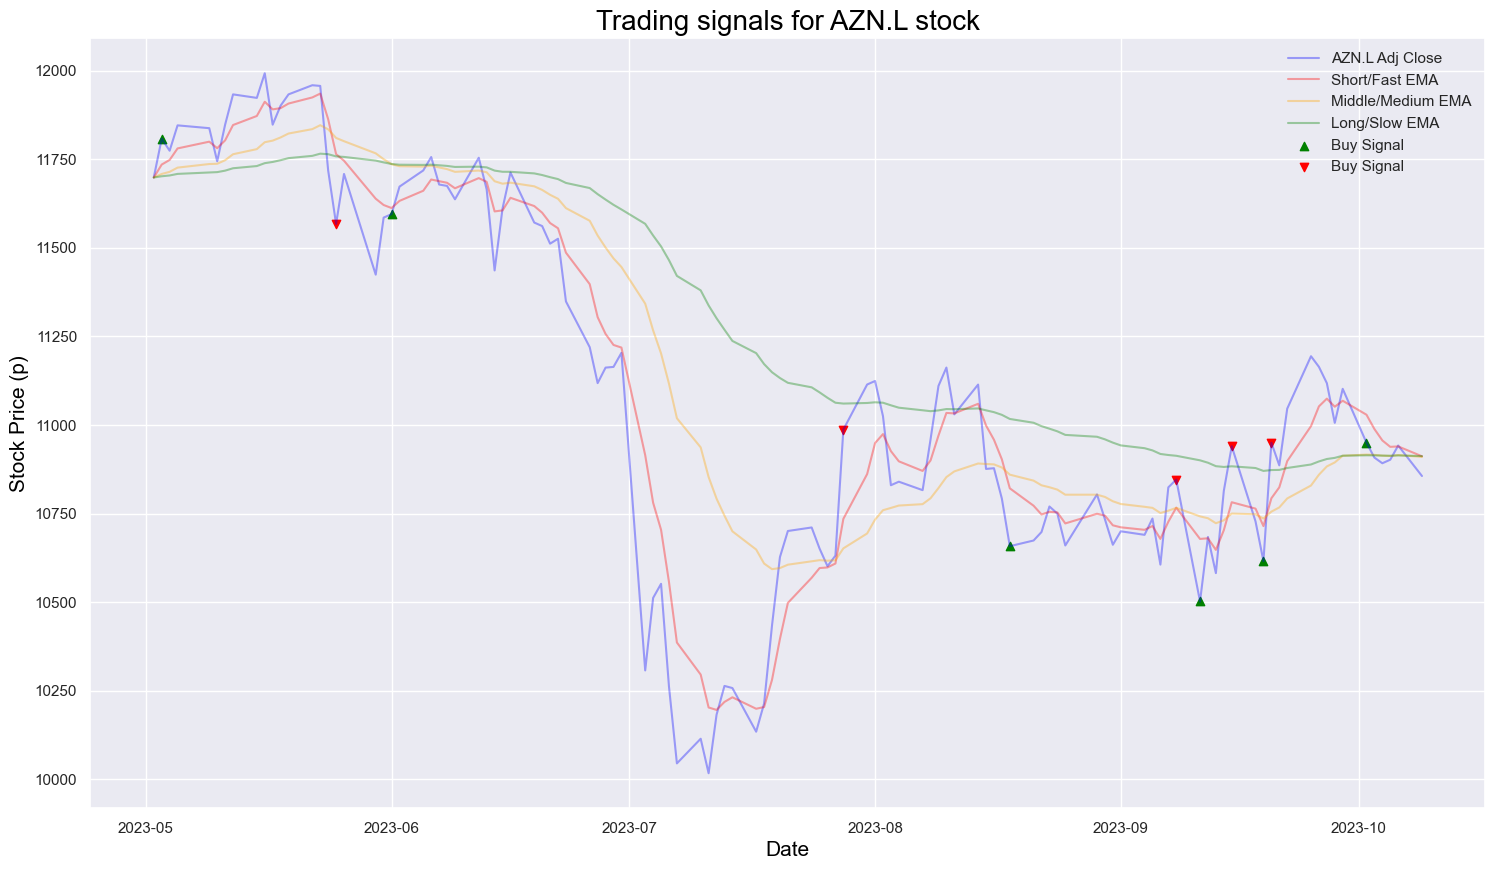

In [68]:
ticker = 'AZN.L'
title_txt = "Trading signals for AZN.L stock"
label_txt = "AZN.L Adj Close"

buy_sell_ewma3_plot()

### 5.1.6 Exponential Smoothing

Single Exponential Smoothing, also known as Simple Exponential Smoothing, is a time series forecasting method for univariate data without a trend or seasonality. It requires an alpha parameter, also called the smoothing factor or smoothing coefficient, to control the rate at which the influence of the observations at prior time steps decay exponentially.

In [69]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label=f"Alpha {alpha}")
    plt.plot(series.values, "c", label = f"{label_txt}")
    plt.xlabel('Days', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title(f"{title_txt}", color = 'black', fontsize = 20)
    plt.grid(True);

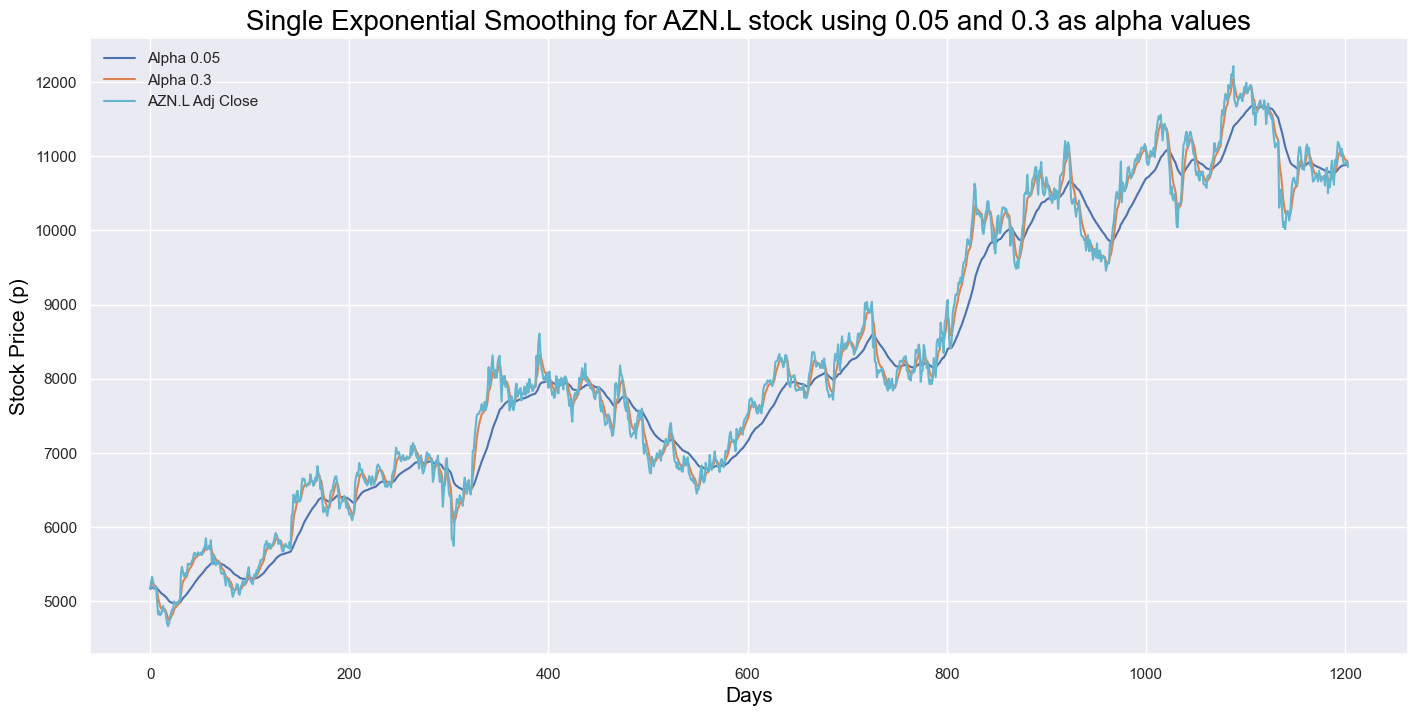

In [70]:
ticker = 'AZN.L'
title_txt = "Single Exponential Smoothing for AZN.L stock using 0.05 and 0.3 as alpha values"
label_txt = "AZN.L Adj Close"

plot_exponential_smoothing(ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'], [0.05, 0.3])

The smaller the smoothing factor (coefficient), the smoother the time series will be. As the smoothing factor approaches 0, we approach the moving average model so the smoothing factor of 0.05 produces a smoother time series than 0.3. This indicates slow learning (past observations have a large influence on forecasts). A value close to 1 indicates fast learning (that is, only the most recent values influence the forecasts).

Double Exponential Smoothing (Holt’s Linear Trend Model) is an extension being a recursive use of Exponential Smoothing twice where beta is the trend smoothing factor, and takes values between 0 and 1. It explicitly adds support for trends.

In [71]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label=f"Alpha {alpha}, beta {beta}")
    plt.plot(series.values, label = f"{label_txt}")
    plt.xlabel('Days', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title(f"{title_txt}", color = 'black', fontsize = 20)
    plt.grid(True)

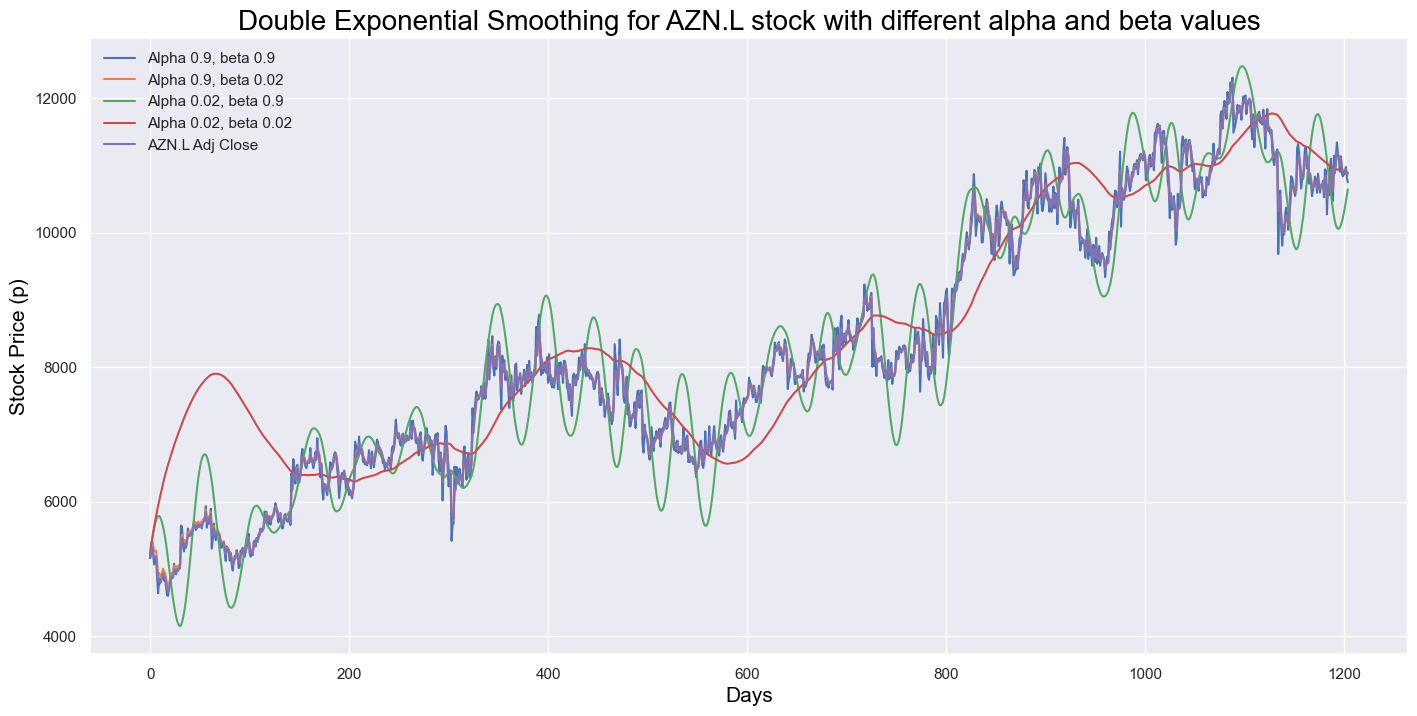

In [72]:
ticker = 'AZN.L'
title_txt = "Double Exponential Smoothing for AZN.L stock with different alpha and beta values"
label_txt = "AZN.L Adj Close"

plot_double_exponential_smoothing(ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

The third main type is Triple Exponential Smoothing (Holt Winters Method) which is an extension of Exponential Smoothing that explicitly adds support for seasonality, or periodic fluctuations.

### 5.1.7 Moving average convergence divergence (MACD)

The MACD is a trend-following momentum indicator turning two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter one.

It is useful although lacking one prediction element - because it is unbounded it is not particularly useful for identifying overbought and oversold levels. Traders can look for signal line crossovers, neutral/centreline crossovers (otherwise known as the 50 level) and divergences from the price action to generate signals. 

The default parameters are 26 EMA of prices, 12 EMA of prices and a 9-moving average of the difference between the first two.

In [73]:
def adj_3mo():
  sns.set(rc={'figure.figsize':(15, 9)})
  ftse100_stocks[ticker]['Adj Close'].loc['2023-08-01':'2023-10-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()


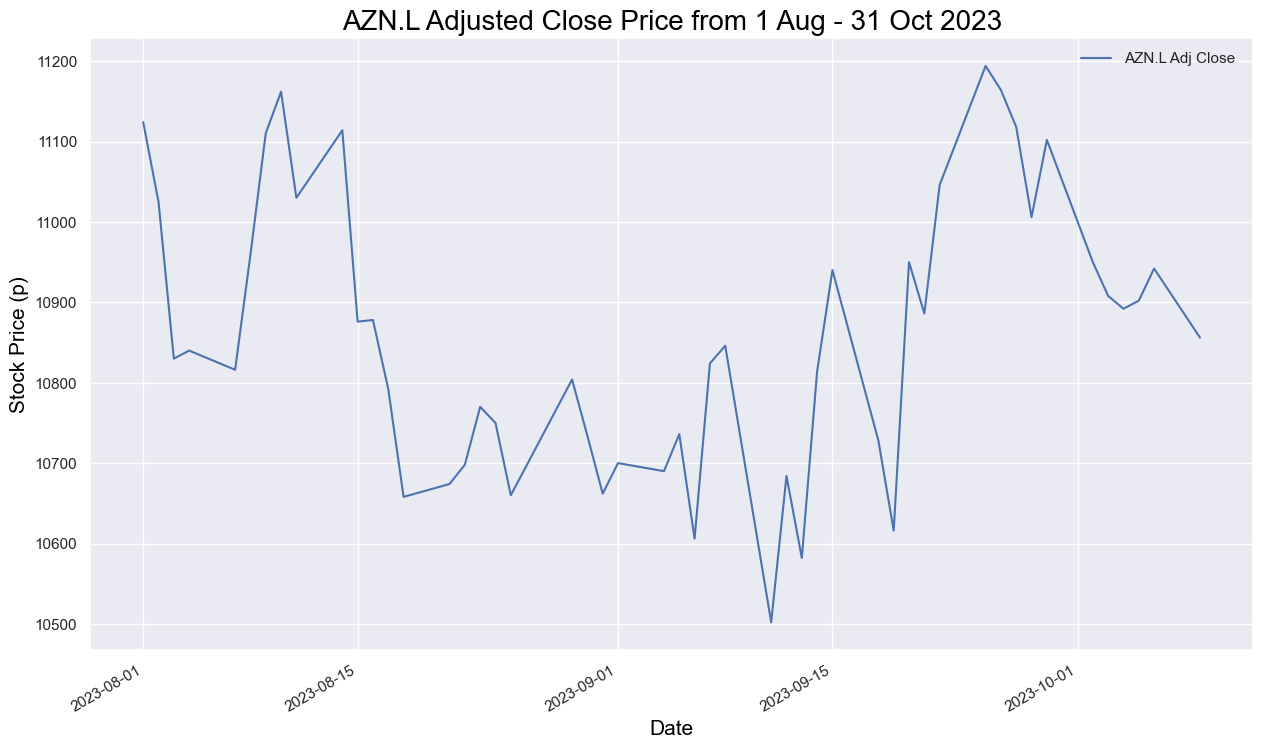

In [74]:
ticker = 'AZN.L'
title_txt = "AZN.L Adjusted Close Price from 1 Aug - 31 Oct 2023"
label_txt = "AZN.L Adj Close "

adj_3mo()

In [75]:
azn_adj_3mo = azn[['Adj Close']]['2023-08-01':'2023-10-31']

In [76]:
ShortEMA = azn_adj_3mo['Adj Close'].ewm(span=12, adjust=False).mean()
LongEMA = azn_adj_3mo['Adj Close'].ewm(span=26, adjust=False).mean()
MACD = ShortEMA - LongEMA
signal = MACD.ewm(span=9, adjust=False).mean()

In [77]:
def macd():
  plt.figure(figsize=(15, 9))
  plt.plot(azn_adj_3mo.index, MACD, label = f"{macd_label_txt}", color= 'red')
  plt.plot(azn_adj_3mo.index, signal, label = f"{sig_label_txt}", color= 'blue')
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xticks (rotation = 45)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.legend(loc='upper left')
  plt.show()

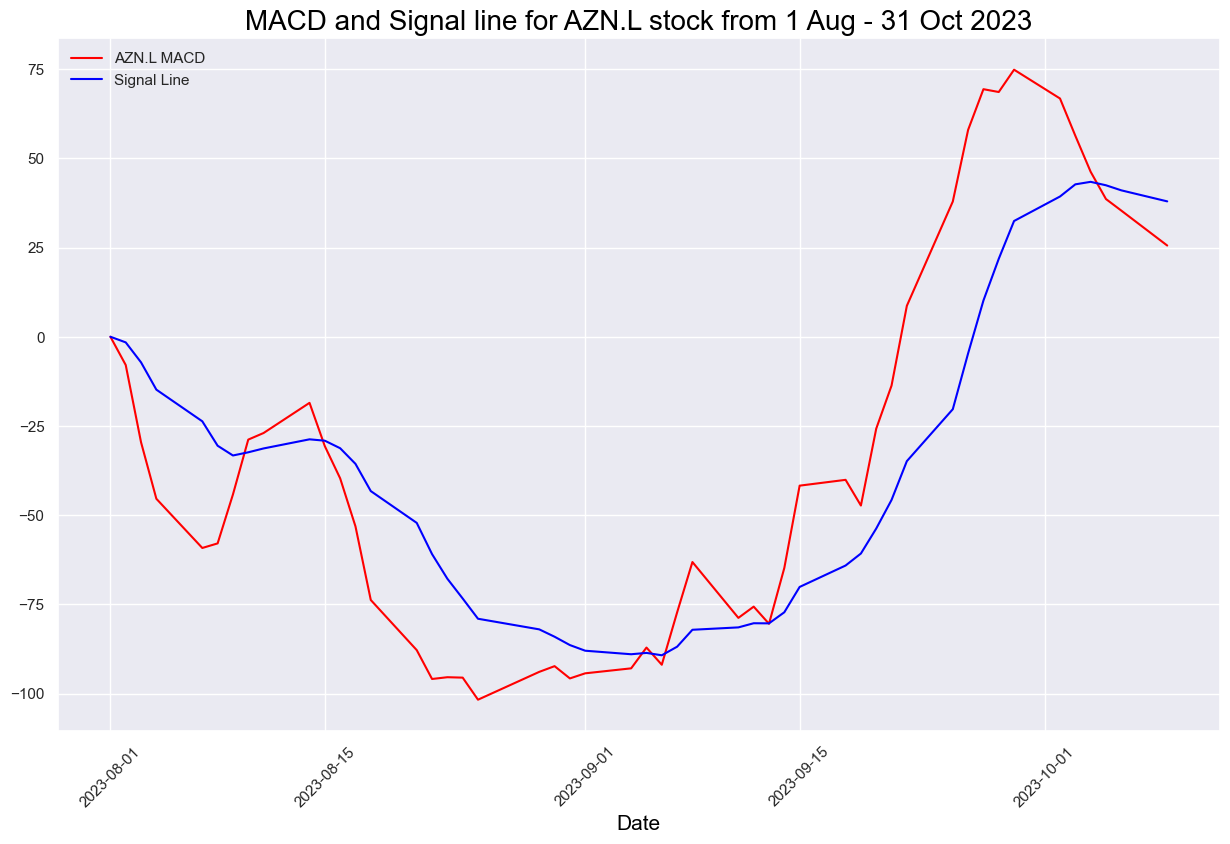

In [78]:
ticker = 'AZN.L'
title_txt = 'MACD and Signal line for AZN.L stock from 1 Aug - 31 Oct 2023'
macd_label_txt ="AZN.L MACD"
sig_label_txt = "Signal Line"

macd()

When the MACD line crosses above the signal line this indicates a good time to buy.

In [79]:
# Create new columns for the MACD and Signal Line data

azn_adj_3mo['MACD'] = MACD
azn_adj_3mo['Signal Line'] = signal
azn_adj_3mo

Adj Close        MACD  Signal Line
Date                                             
2023-08-01  11124.110352    0.000000     0.000000
2023-08-02  11024.751953   -7.926026    -1.585205
2023-08-03  10830.010742  -29.580462    -7.184257
2023-08-04  10839.946289  -45.416509   -14.830707
2023-08-07  10816.100586  -59.208324   -23.706230
2023-08-08  10959.175781  -57.925731   -30.550131
2023-08-09  11110.200195  -44.213197   -33.282744
2023-08-10  11162.000000  -28.833727   -32.392940
2023-08-11  11030.000000  -26.985609   -31.311474
2023-08-14  11114.000000  -18.529271   -28.755034
2023-08-15  10876.000000  -30.678530   -29.139733
2023-08-16  10878.000000  -39.688023   -31.249391
2023-08-17  10792.000000  -53.154856   -35.630484
2023-08-18  10658.000000  -73.789499   -43.262287
2023-08-21  10674.000000  -87.838983   -52.177626
2023-08-22  10698.000000  -95.930869   -60.928275
2023-08-23  10770.000000  -95.433848   -67.829389
2023-08-24  10750.000000  -95.552319   -73.373975
2023-08-25  10660.000000 -101.735711   -79.046322
2023-08-29  10804.000000  -93.933688   -82.023795
2023-08-30  10734.000000  -92.334568   -84.085950
2023-08-31  10662.000000  -95.773040   -86.423368
2023-09-01  10700.000000  -94.344230   -88.007540
2023-09-04  10690.000000  -92.947364   -88.995505
2023-09-05  10736.000000  -87.124210   -88.621246
2023-09-06  10606.000000  -91.939411   -89.284879
2023-09-07  10824.000000  -77.273948   -86.882693
2023-09-08  10846.000000  -63.148313   -82.135817
2023-09-11  10502.000000  -78.803176   -81.469289
2023-09-12  10684.000000  -75.651822   -80.305795
2023-09-13  10582.000000  -80.457435   -80.336123
2023-09-14  10814.000000  -64.798501   -77.228599
2023-09-15  10940.000000  -41.740378   -70.130955
2023-09-18  10728.000000  -40.110905   -64.126945
2023-09-19  10616.000000  -47.311620   -60.763880
2023-09-20  10950.000000  -25.770168   -53.765137
2023-09-21  10886.000000  -13.704698   -45.753050
2023-09-22  11046.000000    8.668017   -34.868836
2023-09-25  11194.000000   37.903985   -20.314272
2023-09-26  11164.000000   57.984541    -4.654509
2023-09-27  11118.000000   69.386862    10.153765
2023-09-28  11006.000000   68.595098    21.842032
2023-09-29  11102.000000   74.851180    32.443861
2023-10-02  10950.000000   66.774307    39.309950
2023-10-03  10908.000000   56.334884    42.714937
2023-10-04  10892.000000   46.237504    43.419450
2023-10-05  10902.000000   38.597248    42.455010
2023-10-06  10942.000000   35.362321    41.036472
2023-10-09  10856.000000   25.564446    37.942067

In [80]:
# Function to signal when to buy and sell

def buy_sell_macd(signal):
  Buy = []
  Sell = []
  flag = -1

  for i in range(0, len(signal)):
    if signal['MACD'][i] > signal['Signal Line'][i]:
      Sell.append(np.nan)
      if flag != 1:
        Buy.append(signal['Adj Close'][i])
        flag = 1
      else:
        Buy.append(np.nan)
    elif signal['MACD'][i] < signal['Signal Line'][i]:
      Buy.append(np.nan)
      if flag != 0:
        Sell.append(signal['Adj Close'][i])
        flag = 0
      else:
        Sell.append(np.nan)
    else:
      Buy.append(np.nan)
      Sell.append(np.nan)

  return (Buy, Sell)

In [81]:
# Create buy and sell columns

a = buy_sell_macd(azn_adj_3mo)
azn_adj_3mo['Buy_Signal_Price'] = a[0]
azn_adj_3mo['Sell_Signal_Price'] = a[1]

In [82]:
azn_adj_3mo

Adj Close        MACD  Signal Line  Buy_Signal_Price  \
Date                                                                  
2023-08-01  11124.110352    0.000000     0.000000               NaN   
2023-08-02  11024.751953   -7.926026    -1.585205               NaN   
2023-08-03  10830.010742  -29.580462    -7.184257               NaN   
2023-08-04  10839.946289  -45.416509   -14.830707               NaN   
2023-08-07  10816.100586  -59.208324   -23.706230               NaN   
2023-08-08  10959.175781  -57.925731   -30.550131               NaN   
2023-08-09  11110.200195  -44.213197   -33.282744               NaN   
2023-08-10  11162.000000  -28.833727   -32.392940           11162.0   
2023-08-11  11030.000000  -26.985609   -31.311474               NaN   
2023-08-14  11114.000000  -18.529271   -28.755034               NaN   
2023-08-15  10876.000000  -30.678530   -29.139733               NaN   
2023-08-16  10878.000000  -39.688023   -31.249391               NaN   
2023-08-17  10792.000000  -53.154856   -35.630484               NaN   
2023-08-18  10658.000000  -73.789499   -43.262287               NaN   
2023-08-21  10674.000000  -87.838983   -52.177626               NaN   
2023-08-22  10698.000000  -95.930869   -60.928275               NaN   
2023-08-23  10770.000000  -95.433848   -67.829389               NaN   
2023-08-24  10750.000000  -95.552319   -73.373975               NaN   
2023-08-25  10660.000000 -101.735711   -79.046322               NaN   
2023-08-29  10804.000000  -93.933688   -82.023795               NaN   
2023-08-30  10734.000000  -92.334568   -84.085950               NaN   
2023-08-31  10662.000000  -95.773040   -86.423368               NaN   
2023-09-01  10700.000000  -94.344230   -88.007540               NaN   
2023-09-04  10690.000000  -92.947364   -88.995505               NaN   
2023-09-05  10736.000000  -87.124210   -88.621246           10736.0   
2023-09-06  10606.000000  -91.939411   -89.284879               NaN   
2023-09-07  10824.000000  -77.273948   -86.882693           10824.0   
2023-09-08  10846.000000  -63.148313   -82.135817               NaN   
2023-09-11  10502.000000  -78.803176   -81.469289               NaN   
2023-09-12  10684.000000  -75.651822   -80.305795               NaN   
2023-09-13  10582.000000  -80.457435   -80.336123               NaN   
2023-09-14  10814.000000  -64.798501   -77.228599           10814.0   
2023-09-15  10940.000000  -41.740378   -70.130955               NaN   
2023-09-18  10728.000000  -40.110905   -64.126945               NaN   
2023-09-19  10616.000000  -47.311620   -60.763880               NaN   
2023-09-20  10950.000000  -25.770168   -53.765137               NaN   
2023-09-21  10886.000000  -13.704698   -45.753050               NaN   
2023-09-22  11046.000000    8.668017   -34.868836               NaN   
2023-09-25  11194.000000   37.903985   -20.314272               NaN   
2023-09-26  11164.000000   57.984541    -4.654509               NaN   
2023-09-27  11118.000000   69.386862    10.153765               NaN   
2023-09-28  11006.000000   68.595098    21.842032               NaN   
2023-09-29  11102.000000   74.851180    32.443861               NaN   
2023-10-02  10950.000000   66.774307    39.309950               NaN   
2023-10-03  10908.000000   56.334884    42.714937               NaN   
2023-10-04  10892.000000   46.237504    43.419450               NaN   
2023-10-05  10902.000000   38.597248    42.455010               NaN   
2023-10-06  10942.000000   35.362321    41.036472               NaN   
2023-10-09  10856.000000   25.564446    37.942067               NaN   

            Sell_Signal_Price  
Date                           
2023-08-01                NaN  
2023-08-02       11024.751953  
2023-08-03                NaN  
2023-08-04                NaN  
2023-08-07                NaN  
2023-08-08                NaN  
2023-08-09                NaN  
2023-08-10                NaN  
2023-08-11                NaN  
2023-08-14                NaN  
2023-08-1

In [83]:
# Plot buy and sell signals

def buy_sell_macd_plot():
  plt.figure(figsize=(20, 10))
  plt.scatter(azn_adj_3mo.index, azn_adj_3mo['Buy_Signal_Price'], color='green', label='Buy', marker='^', alpha=1)
  plt.scatter(azn_adj_3mo.index, azn_adj_3mo['Sell_Signal_Price'], color='red', label='Sell', marker='v', alpha=1)
  plt.plot(azn_adj_3mo['Adj Close'], label='Adj Close Price', alpha = 0.35)
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Adj Close Price')
  plt.legend(loc = 'upper left')
  plt.show()

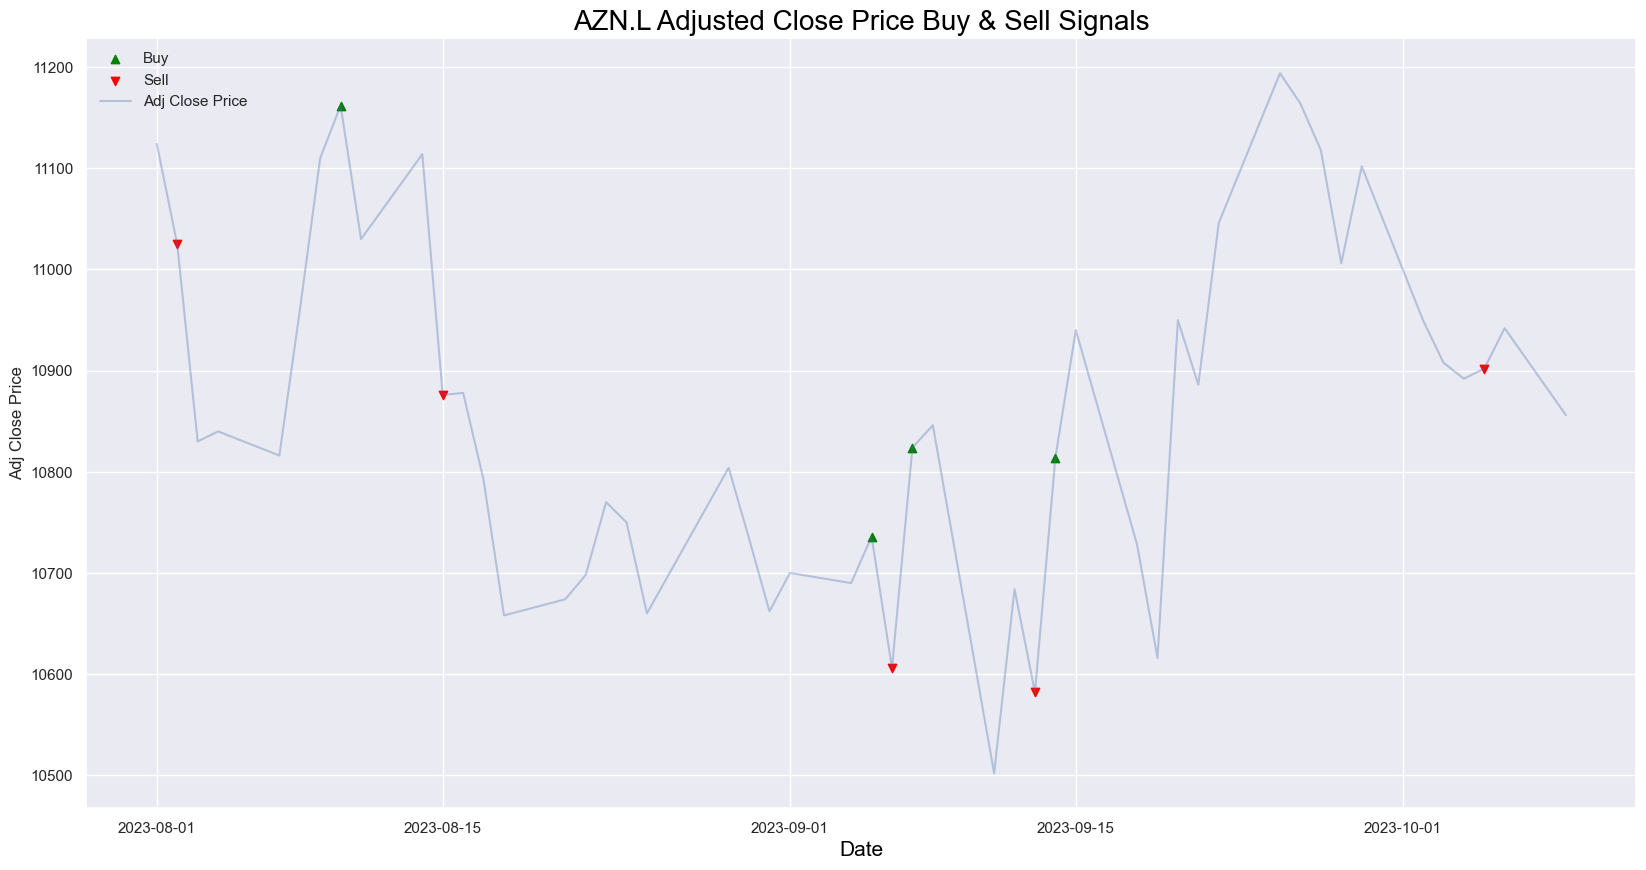

In [84]:
ticker = 'AZN.L'
title_txt = 'AZN.L Adjusted Close Price Buy & Sell Signals'

buy_sell_macd_plot()

## 5.2 Momentum Strategies

In momentum algorithmic trading strategies stocks have momentum (i.e. upward or downward trends) that we can detect and exploit.

### 5.2.1 Relative Strength Index (RSI)

The RSI is a momentum indicator. A typical momentum strategy will buy stocks that have been showing an upward trend in hopes that the trend will continue, and make predictions based on whether the past recent values were going up or going down. 

The RSI determines the level of overbought (70) and oversold (30) zones using a default lookback period of 14 i.e. it uses the last 14 values to calculate its values. The idea is to buy when the RSI touches the 30 barrier and sell when it touches the 70 barrier. 

In [85]:
def adj_12mo():
  sns.set(rc={'figure.figsize':(15, 9)})
  ftse100_stocks[ticker]['Adj Close'].loc['2023-01-01':'2023-10-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

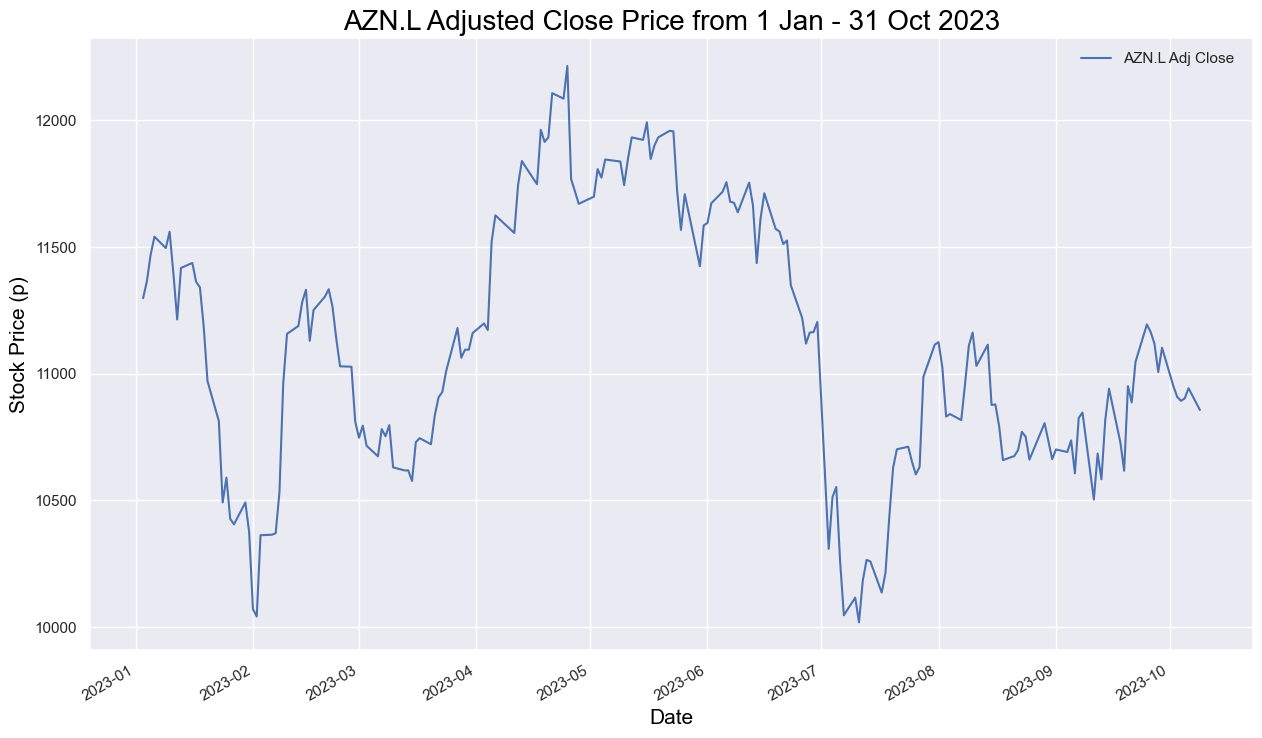

In [86]:
ticker = 'AZN.L'
title_txt = "AZN.L Adjusted Close Price from 1 Jan - 31 Oct 2023"
label_txt = "AZN.L Adj Close "

adj_12mo()

In [ ]:
azn_adj_12mo = azn[['Adj Close']]['2019-01-01':'2019-12-31']

In [ ]:
# Prepare the data to calculate the RSI

# Get difference in price for previous day
delta = azn_adj_12mo['Adj Close'].diff(1)
delta

Date
2019-01-02           NaN
2019-01-03    100.589844
2019-01-04     74.267090
2019-01-07    -78.967773
2019-01-08   -100.590332
                 ...    
2019-12-20    169.197266
2019-12-23    -60.288574
2019-12-24    -31.117188
2019-12-27     30.144531
2019-12-30    -88.487793
Name: Adj Close, Length: 252, dtype: float64

In [ ]:
# Remove NaNs

delta = delta.dropna()
delta

Date
2019-01-03    100.589844
2019-01-04     74.267090
2019-01-07    -78.967773
2019-01-08   -100.590332
2019-01-09     11.281738
                 ...    
2019-12-20    169.197266
2019-12-23    -60.288574
2019-12-24    -31.117188
2019-12-27     30.144531
2019-12-30    -88.487793
Name: Adj Close, Length: 251, dtype: float64

In [ ]:
# Get positive gains (up) and negative gains (down)
up = delta.copy()
down = delta.copy()

up[up < 0] = 0
down[down > 0] = 0

In [ ]:
# Get time period

period = 14

# Calculate average gain and average loss
AVG_Gain = up.rolling(window=period).mean()
#AVG_Loss = abs(down.rolling(window=period).mean())
AVG_Loss = down.abs().rolling(window=period).mean()

In [ ]:
# Calculate RSI based on SMA

# Calculate Relative Strength (RS)
RS = AVG_Gain / AVG_Loss
# Calculate RSI
RSI = 100.0 - (100.0 / (1.0 + RS))

In [ ]:
def rsi():
  sns.set(rc={'figure.figsize':(20, 10)})
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('RSI', color = 'black', fontsize = 15);
  RSI.plot()


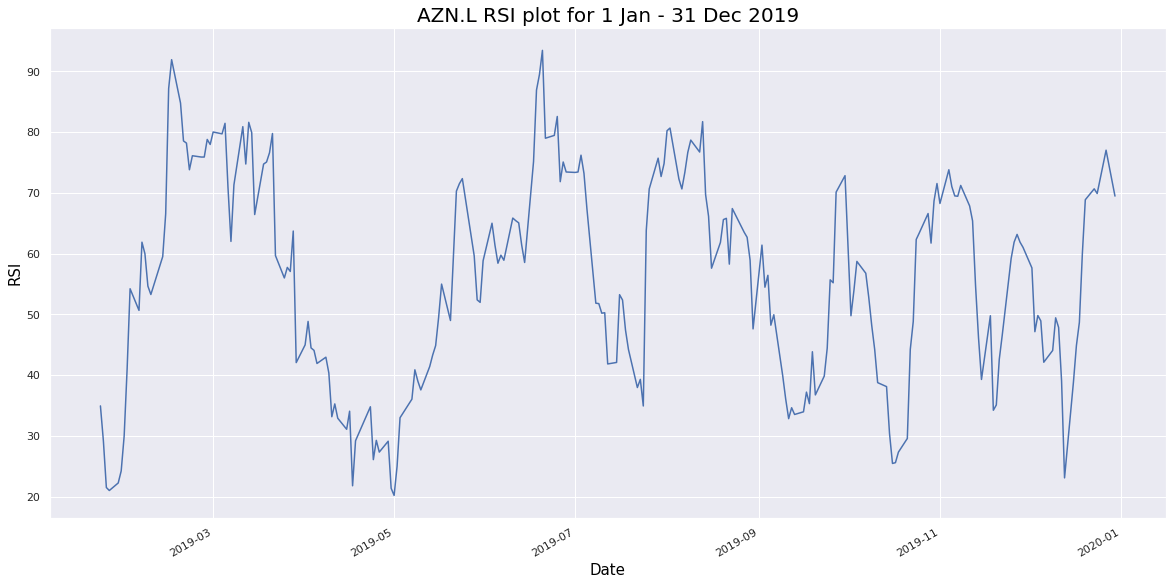

In [ ]:
ticker = 'AZN.L'
title_txt = "AZN.L RSI plot for 1 Jan - 31 Dec 2019"
label_txt = "AZN.L RSI level"

rsi()

In [ ]:
# Create dataframe with Adjusted Close and RSI

new_df = pd.DataFrame()
new_df['Adj Close'] = azn_adj_12mo['Adj Close']
new_df['RSI'] = RSI
new_df

Adj Close        RSI
Date                              
2019-01-02  5549.368164        NaN
2019-01-03  5649.958008        NaN
2019-01-04  5724.225098        NaN
2019-01-07  5645.257324        NaN
2019-01-08  5544.666992        NaN
...                 ...        ...
2019-12-20  7592.499512  68.884536
2019-12-23  7532.210938  70.682750
2019-12-24  7501.093750  69.910617
2019-12-27  7531.238281  77.043984
2019-12-30  7442.750488  69.488207

[252 rows x 2 columns]

In [ ]:
def adj_close_12mo():
  sns.set(rc={'figure.figsize':(20, 10)})
  plt.plot(new_df.index, new_df['Adj Close'])
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend(new_df.columns.values, loc = 'upper left')
  plt.show()

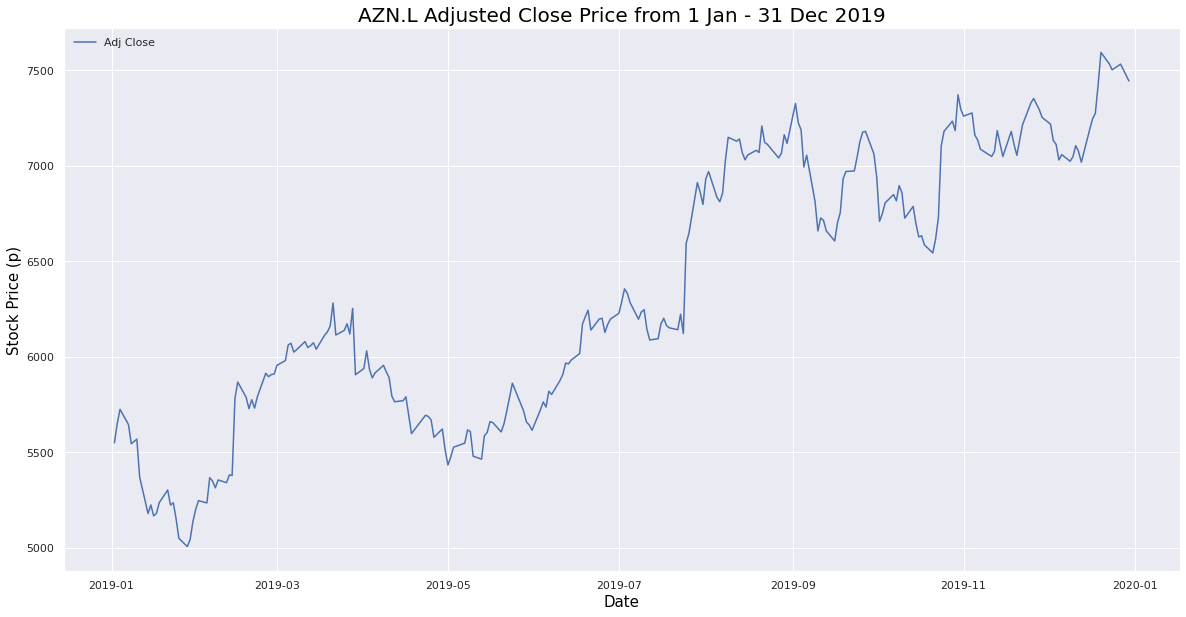

In [ ]:
title_txt = "AZN.L Adjusted Close Price from 1 Jan - 31 Dec 2019"

adj_close_12mo()

In [ ]:
# Plot corresponding RSI values and the significant levels

def rsi_sma():
  plt.figure(figsize=(20, 10))
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.plot(new_df.index, new_df['RSI'])
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.axhline(0, linestyle='--', alpha = 0.5, color='gray')
  plt.axhline(10, linestyle='--', alpha = 0.5, color='orange')
  plt.axhline(20, linestyle='--', alpha = 0.5, color='green')
  plt.axhline(30, linestyle='--', alpha = 0.5, color='red')
  plt.axhline(70, linestyle='--', alpha = 0.5, color='red')
  plt.axhline(80, linestyle='--', alpha = 0.5, color='green')
  plt.axhline(90, linestyle='--', alpha = 0.5, color='orange')
  plt.axhline(100, linestyle='--', alpha = 0.5, color='gray')
  plt.show()

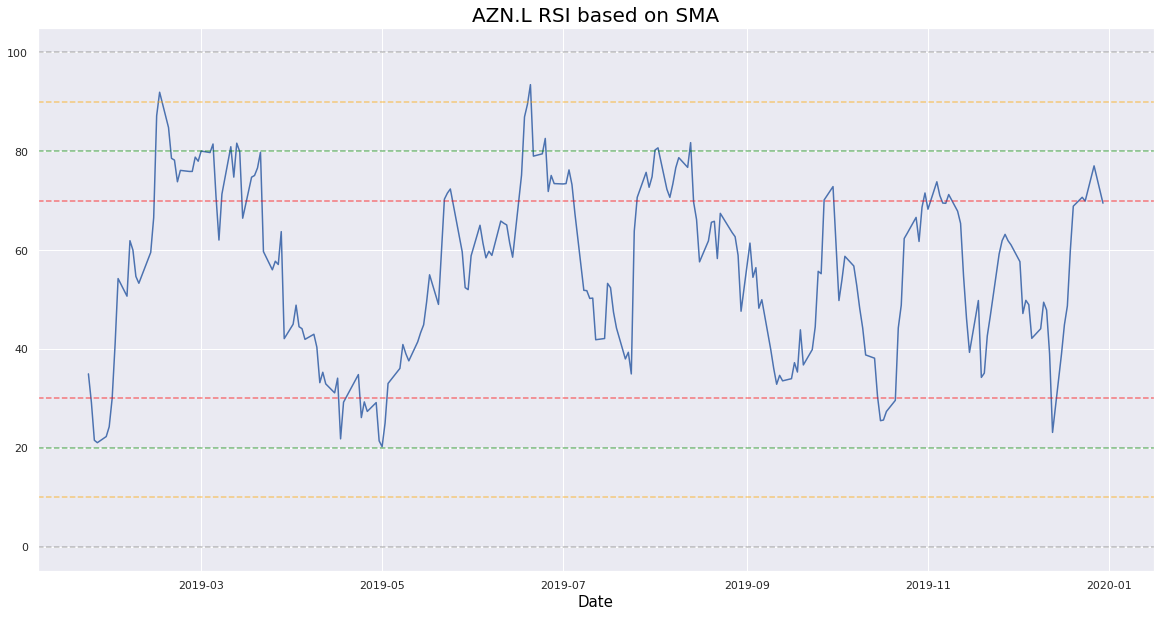

In [ ]:
title_txt = 'AZN.L RSI based on SMA'

rsi_sma()

In [ ]:
period = 14

# Calculate the EWMA average gain and average loss
AVG_Gain2 = up.ewm(span=period).mean()
AVG_Loss2 = down.abs().ewm(span=period).mean()

# Calculate the RSI based on EWMA
RS2 = AVG_Gain2 / AVG_Loss2
RSI2 = 100.0 - (100.0 / (1.0 + RS2))

In [ ]:
new_df2 = pd.DataFrame()
new_df2['Adj Close'] = azn_adj_12mo['Adj Close']
new_df2['RSI2'] = RSI2
new_df2

Adj Close        RSI2
Date                               
2019-01-02  5549.368164         NaN
2019-01-03  5649.958008  100.000000
2019-01-04  5724.225098  100.000000
2019-01-07  5645.257324   63.922997
2019-01-08  5544.666992   41.772777
...                 ...         ...
2019-12-20  7592.499512   82.278552
2019-12-23  7532.210938   74.079351
2019-12-24  7501.093750   69.929265
2019-12-27  7531.238281   71.701339
2019-12-30  7442.750488   59.771037

[252 rows x 2 columns]

In [ ]:
# Plot corresponding RSI values and the significant levels

def rsi_ewma():
  plt.figure(figsize=(20, 10))
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.plot(new_df2.index, new_df2['RSI2'])
  plt.axhline(0, linestyle='--', alpha = 0.5, color='gray')
  plt.axhline(10, linestyle='--', alpha = 0.5, color='orange')
  plt.axhline(20, linestyle='--', alpha = 0.5, color='green')
  plt.axhline(30, linestyle='--', alpha = 0.5, color='red')
  plt.axhline(70, linestyle='--', alpha = 0.5, color='red')
  plt.axhline(80, linestyle='--', alpha = 0.5, color='green')
  plt.axhline(90, linestyle='--', alpha = 0.5, color='orange')
  plt.axhline(100, linestyle='--', alpha = 0.5, color='gray')
  plt.show()

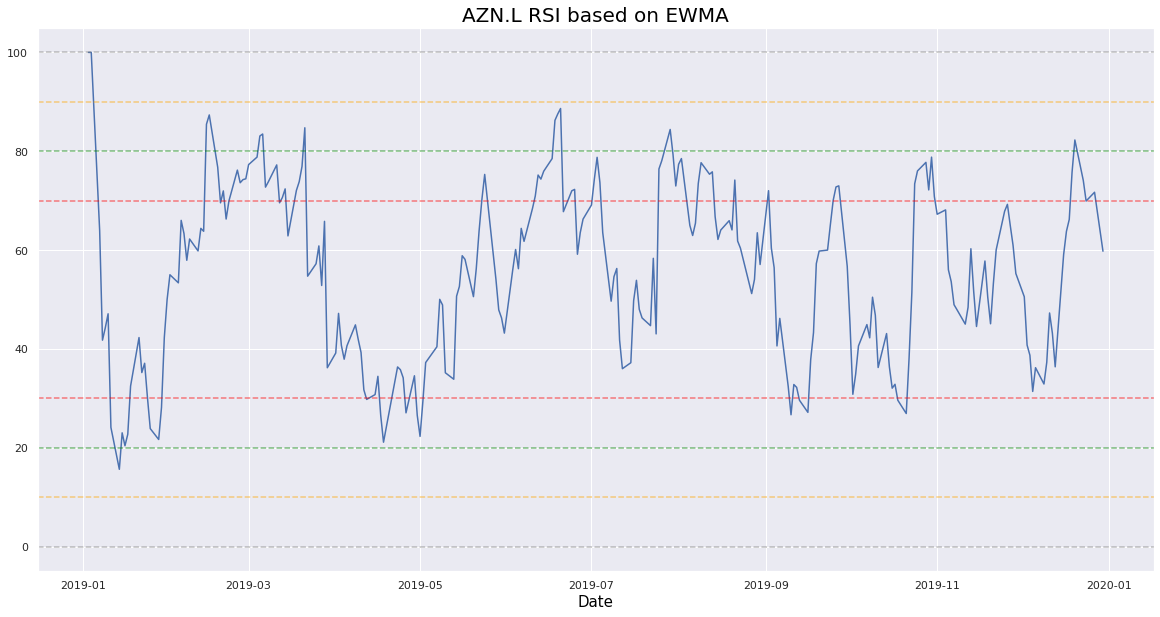

In [ ]:
title_txt = 'AZN.L RSI based on EWMA'

rsi_ewma()

It appears that RSI value dips below the 20 significant level in January 2019 indicating that the stock was oversold and presented a buying opportunity for an investor before a price rise.

### 5.2.2 Money Flow Index (MFI)

Money Flow Index (MFI) is a technical oscillator, and momentum indicator, that uses price and volume data for identifying overbought or oversold signals in an asset. It can also be used to spot divergences which warn of a trend change in price. The oscillator moves between 0 and 100 and a reading of above 80 implies overbought conditions, and below 20 implies oversold conditions.

It is related to the Relative Strength Index (RSI) but incorporates volume, whereas the RSI only considers price. 

In [ ]:
azn_12mo = azn.copy()  

In [ ]:
azn_12mo = azn_12mo['2019-01-01':'2019-12-31']
azn_12mo

Open    High          Low   Close    Adj Close   Volume
Date                                                                 
2019-01-02  5857.0  5925.0  5743.000000  5903.0  5549.368164  1853042
2019-01-03  5877.0  6069.0  5841.000000  6010.0  5649.958008  2483351
2019-01-04  6037.0  6089.0  5944.000000  6089.0  5724.225098  2495405
2019-01-07  6082.0  6082.0  5982.000000  6005.0  5645.257324  2582745
2019-01-08  5953.0  6002.0  5898.000000  5898.0  5544.666992  2517905
...            ...     ...          ...     ...          ...      ...
2019-12-20  7658.0  7808.0  7614.000000  7808.0  7592.499512  5860381
2019-12-23  7771.0  7824.0  7723.870117  7746.0  7532.210938  2183949
2019-12-24  7715.0  7794.0  7631.290039  7714.0  7501.093750   378885
2019-12-27  7706.0  7781.0  7641.000000  7745.0  7531.238281   862283
2019-12-30  7734.0  7767.0  7654.000000  7654.0  7442.750488  1394124

[252 rows x 6 columns]

In [ ]:
def azn_12mo_close():
  plt.figure(figsize=(20, 10))
  plt.plot(azn_12mo['Close'])
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Close Price', color = 'black', fontsize = 15)
  plt.legend(azn_12mo.columns.values, loc='upper left')
  plt.show()

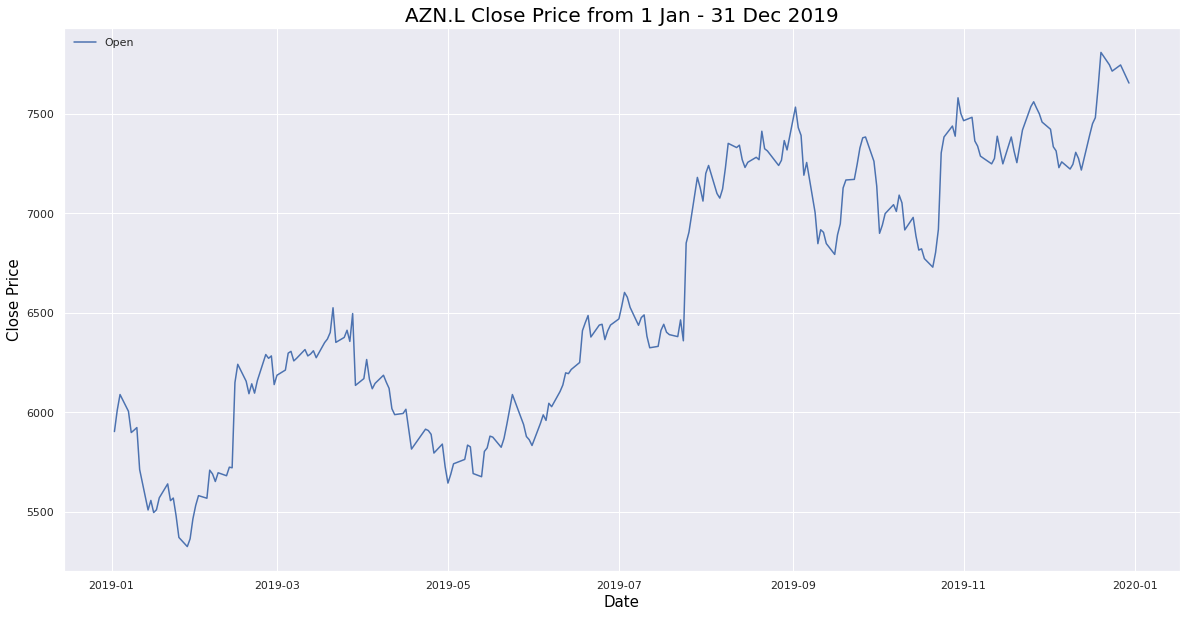

In [ ]:
title_txt = "AZN.L Close Price from 1 Jan - 31 Dec 2019"
label_txt = "AZN.L Close price "

azn_12mo_close()

In [ ]:
# Calculate typical price

typical_price = (azn_12mo['Close'] + azn_12mo['High'] + azn_12mo['Low']) / 3
typical_price

Date
2019-01-02    5857.000000
2019-01-03    5973.333333
2019-01-04    6040.666667
2019-01-07    6023.000000
2019-01-08    5932.666667
                 ...     
2019-12-20    7743.333333
2019-12-23    7764.623372
2019-12-24    7713.096680
2019-12-27    7722.333333
2019-12-30    7691.666667
Length: 252, dtype: float64

In [ ]:
period = 14

In [ ]:
# Calculate the money flow
money_flow = typical_price * azn_12mo['Volume']
money_flow

Date
2019-01-02    1.085327e+10
2019-01-03    1.483388e+10
2019-01-04    1.507391e+10
2019-01-07    1.555587e+10
2019-01-08    1.493789e+10
                  ...     
2019-12-20    4.537888e+10
2019-12-23    1.695754e+10
2019-12-24    2.922377e+09
2019-12-27    6.658837e+09
2019-12-30    1.072314e+10
Length: 252, dtype: float64

In [ ]:
# Get all positive and negative money flows
positive_flow = []
negative_flow = []

# Loop through typical price
for i in range(1, len(typical_price)):
  if typical_price[i] > typical_price[i-1]:
    positive_flow.append(money_flow[i-1])
    negative_flow.append(0)
  elif typical_price[i] < typical_price[i-1]:
    negative_flow.append(money_flow[i-1])
    positive_flow.append(0)
  else:
    positive_flow.append(0)
    negative_flow.append(0)


In [ ]:
# Get all positive and negative money flows within same time period
positive_mf = []
negative_mf = []

for i in range(period-1, len(positive_flow)):
  positive_mf.append(sum(positive_flow[i + 1 - period : i+1]))
for i in range(period-1, len(negative_flow)):
  negative_mf.append(sum(negative_flow[i + 1 - period : i+1]))

In [ ]:
# Calculate money flow index

mfi = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))
mfi

array([ 26.37467955,  21.41631055,  14.51702253,  14.64302295,
        14.58894654,  21.06155893,  28.17267769,  34.34357251,
        42.62831561,  49.88786195,  56.48391789,  65.93222358,
        64.64447934,  63.25198992,  62.90755798,  68.8602678 ,
        70.33813853,  78.7057625 ,  88.89675931,  78.87692811,
        70.013088  ,  70.48533183,  63.0240827 ,  63.60162237,
        64.30472549,  57.51275967,  59.51080727,  53.79388493,
        59.39279264,  60.07097511,  65.27774282,  64.17936964,
        55.88252779,  64.66969393,  72.8743432 ,  66.54098956,
        73.94815217,  73.66772136,  63.59590448,  76.83861581,
        75.797566  ,  81.65465317,  81.00103633,  75.38032973,
        69.78958094,  69.39863742,  69.40714205,  69.26607088,
        63.90615752,  74.5348123 ,  64.63460361,  66.11186364,
        59.29370733,  46.96011756,  48.02266654,  44.23402543,
        40.26333432,  40.42546404,  39.85010657,  35.94662043,
        39.89780078,  36.17052933,  35.45327626,  24.00

In [ ]:
df2 = pd.DataFrame()
df2['MFI'] = mfi

In [ ]:
# Create the plot

def mfi_plot():
  plt.figure(figsize=(20, 10))
  plt.plot(df2['MFI'], label = 'MFI')
  plt.axhline(10, linestyle = '--', color = 'orange')
  plt.axhline(20, linestyle = '--', color = 'blue')
  plt.axhline(80, linestyle = '--', color = 'blue')
  plt.axhline(90, linestyle = '--', color = 'orange')
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Time periods', color = 'black', fontsize = 15)
  plt.ylabel('MFI Values', color = 'black', fontsize = 15)
  plt.show()

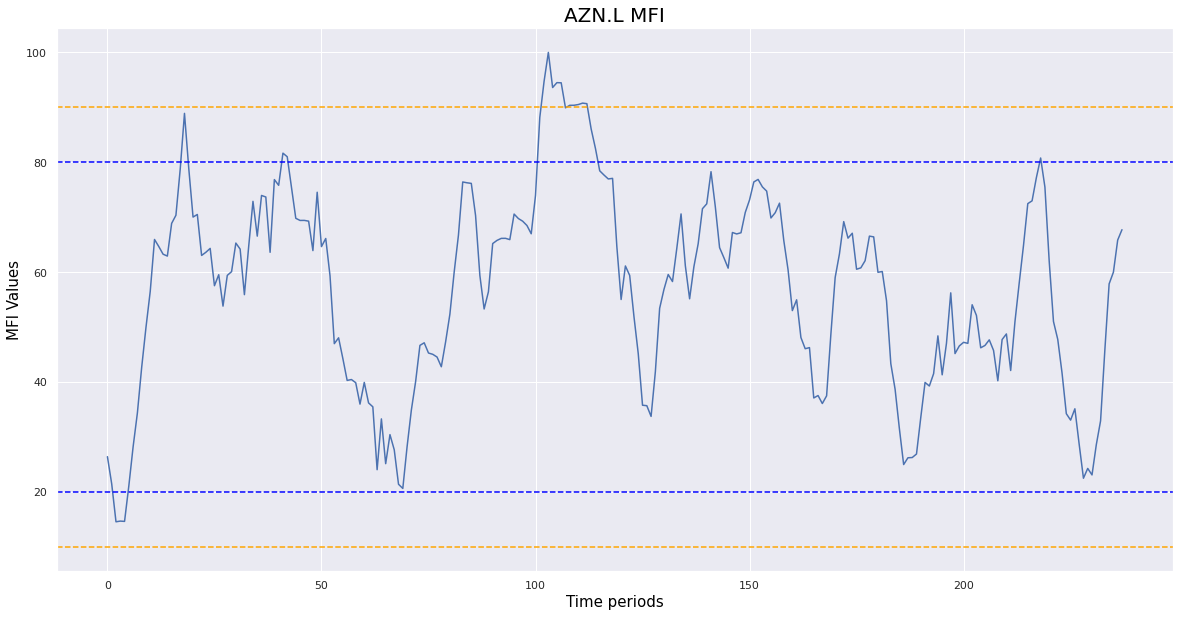

In [ ]:
title_txt = "AZN.L MFI"

mfi_plot()

In [ ]:
new_mfi_df = pd.DataFrame()
new_mfi_df = azn_12mo[period:]
new_mfi_df['MFI'] = mfi

In [ ]:
new_mfi_df

Open    High          Low  ...    Adj Close   Volume        MFI
Date                                     ...                                 
2019-01-22  5636.0  5659.0  5533.000000  ...  5223.155273  1931509  26.374680
2019-01-23  5551.0  5619.0  5508.000000  ...  5235.376953  2964969  21.416311
2019-01-24  5565.0  5579.0  5470.000000  ...  5151.708008  2392031  14.517023
2019-01-25  5432.0  5490.0  5357.000000  ...  5049.239258  3027190  14.643023
2019-01-28  5350.0  5391.0  5312.000000  ...  5005.994141  2616543  14.588947
...            ...     ...          ...  ...          ...      ...        ...
2019-12-20  7658.0  7808.0  7614.000000  ...  7592.499512  5860381  45.781900
2019-12-23  7771.0  7824.0  7723.870117  ...  7532.210938  2183949  57.845176
2019-12-24  7715.0  7794.0  7631.290039  ...  7501.093750   378885  59.976921
2019-12-27  7706.0  7781.0  7641.000000  ...  7531.238281   862283  65.826076
2019-12-30  7734.0  7767.0  7654.000000  ...  7442.750488  1394124  67.713156

[238 rows x 7 columns]

In [ ]:
# Create function to get buy and sell signals

def get_signal(data, high, low):
  buy_signal = []
  sell_signal = []

  for i in range(len(data['MFI'])):
    if data['MFI'][i] > high:
      buy_signal.append(np.nan)
      sell_signal.append(data['Close'][i])
    elif data['MFI'][i] < low:
      buy_signal.append(data['Close'][i])
      sell_signal.append(np.nan)
    else:
      sell_signal.append(np.nan)
      buy_signal.append(np.nan)

  return (buy_signal, sell_signal)


In [ ]:
# Add new columns (Buy & Sell)

new_mfi_df['Buy'] = get_signal(new_mfi_df, 80, 20)[0]
new_mfi_df['Sell'] = get_signal(new_mfi_df, 80, 20)[1]

new_mfi_df

Open    High          Low  ...        MFI     Buy  Sell
Date                                     ...                         
2019-01-22  5636.0  5659.0  5533.000000  ...  26.374680     NaN   NaN
2019-01-23  5551.0  5619.0  5508.000000  ...  21.416311     NaN   NaN
2019-01-24  5565.0  5579.0  5470.000000  ...  14.517023  5480.0   NaN
2019-01-25  5432.0  5490.0  5357.000000  ...  14.643023  5371.0   NaN
2019-01-28  5350.0  5391.0  5312.000000  ...  14.588947  5325.0   NaN
...            ...     ...          ...  ...        ...     ...   ...
2019-12-20  7658.0  7808.0  7614.000000  ...  45.781900     NaN   NaN
2019-12-23  7771.0  7824.0  7723.870117  ...  57.845176     NaN   NaN
2019-12-24  7715.0  7794.0  7631.290039  ...  59.976921     NaN   NaN
2019-12-27  7706.0  7781.0  7641.000000  ...  65.826076     NaN   NaN
2019-12-30  7734.0  7767.0  7654.000000  ...  67.713156     NaN   NaN

[238 rows x 9 columns]

In [ ]:
def mfi_buy_sell_plot():
  plt.figure(figsize=(20, 10))
  plt.plot(new_mfi_df['Close'], label = 'Close Price', alpha = 0.5)
  plt.scatter(new_mfi_df.index, new_mfi_df['Buy'], color = 'green', label = 'Buy Signal', marker = '^', alpha = 1)
  plt.scatter(new_mfi_df.index, new_mfi_df['Sell'], color = 'red', label = 'Sell Signal', marker = 'v', alpha = 1)
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Close Price', color = 'black', fontsize = 15)
  plt.legend(loc='upper left')
  plt.show()

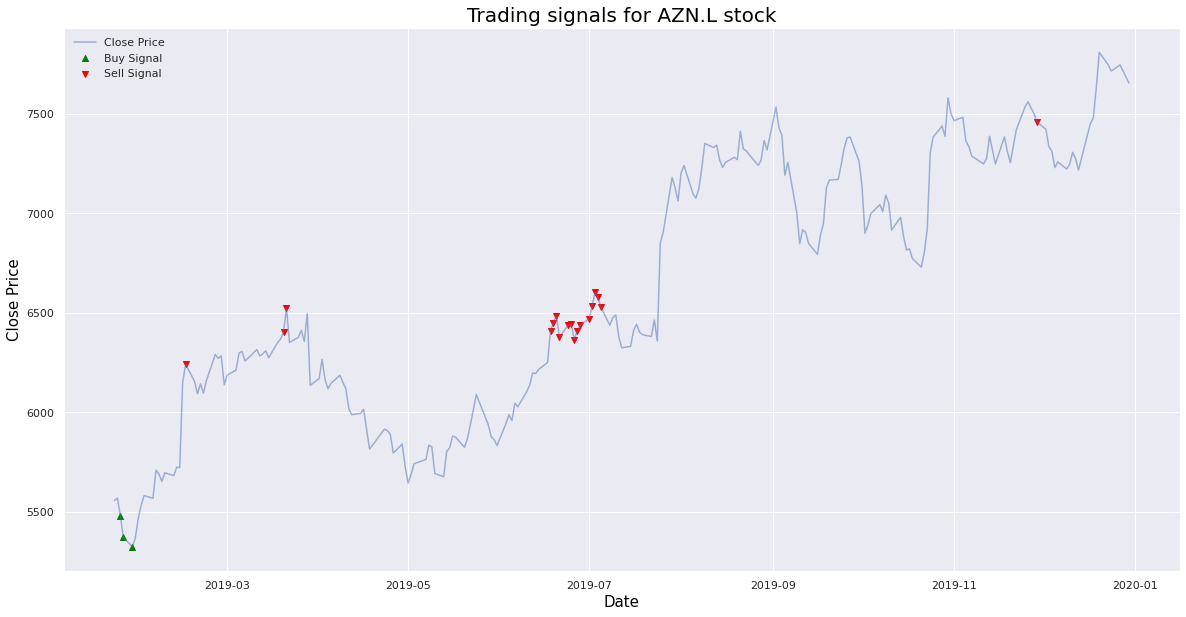

In [ ]:
title_txt = "Trading signals for AZN.L stock"
mfi_buy_sell_plot()

### 5.2.3 Stochastic Oscillator

The stochastic oscillator is a momentum indicator comparing the closing price of a security to the range of its prices over a certain period of time and is one of the best-known momentum indicators along with RSI and MACD.

The intuition is that in a market trending upward, prices will close near the high, and in a market trending downward, prices close near the low.

The stochastic oscillator is plotted within a range of zero and 100. The default parameters are an overbought zone of 80, an oversold zone of 20 and well-used lookbacks period of 14 and 5 which can be used simultaneously. The oscillator has two lines, the %K and %D, where the former measures momentum and the latter measures the moving average of the former. The %D line is more important of the two indicators and tends to produce better trading signals which are created when the %K crosses through the %D.

In [ ]:
azn_so = azn.copy()
azn_so

Open    High          Low   Close    Adj Close   Volume
Date                                                                 
2010-01-04  2912.0  2946.0  2912.000000  2941.0  1775.206909  2091679
2010-01-05  2936.0  2949.5  2901.000000  2907.5  1754.986084  2869739
2010-01-06  2909.0  2909.0  2850.500000  2875.0  1735.368652  3136541
2010-01-07  2879.0  2925.5  2879.000000  2910.5  1756.796875  3748200
2010-01-08  2921.0  2927.5  2889.500000  2908.5  1755.589600  2473846
...            ...     ...          ...     ...          ...      ...
2019-12-20  7658.0  7808.0  7614.000000  7808.0  7592.499512  5860381
2019-12-23  7771.0  7824.0  7723.870117  7746.0  7532.210938  2183949
2019-12-24  7715.0  7794.0  7631.290039  7714.0  7501.093750   378885
2019-12-27  7706.0  7781.0  7641.000000  7745.0  7531.238281   862283
2019-12-30  7734.0  7767.0  7654.000000  7654.0  7442.750488  1394124

[2518 rows x 6 columns]

The stochastic oscillator is calculated using the following formula:

%K = 100(C – L14)/(H14 – L14)

Where:

C = the most recent closing price

L14 = the low of the 14 previous trading sessions

H14 = the highest price traded during the same 14-day period

%K= the current market rate for the currency pair

%D = 3-period moving average of %K

In [ ]:
# In this implementation there are 3 possible states – long, short, flat (i.e. no position).

#Create the "L14" column in the DataFrame
azn_so['L14'] = azn_so['Low'].rolling(window=14).min()

#Create the "H14" column in the DataFrame
azn_so['H14'] = azn_so['High'].rolling(window=14).max()

#Create the "%K" column in the DataFrame
azn_so['%K'] = 100*((azn_so['Close'] - azn_so['L14']) / (azn_so['H14'] - azn_so['L14']) )

#Create the "%D" column in the DataFrame
azn_so['%D'] = azn_so['%K'].rolling(window=3).mean()

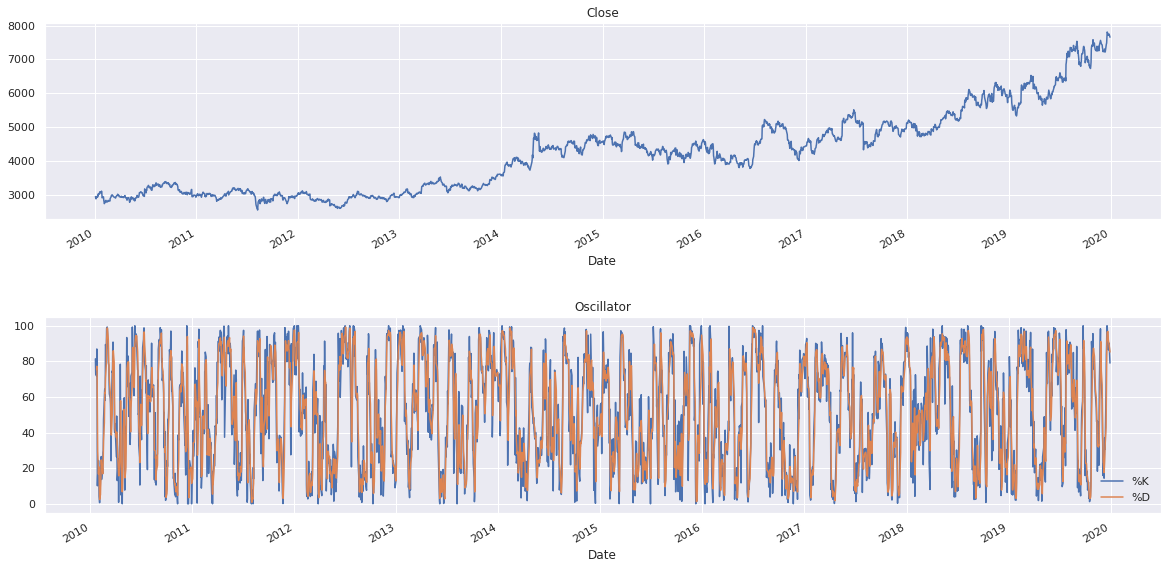

In [ ]:
#create a plot (with 2 subplots) showing the AZN.L price over time, along with a visual representation of the Stochastic Oscillator.

fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)

azn_so['Close'].plot(ax=axes[0]); axes[0].set_title('Close')
azn_so[['%K','%D']].plot(ax=axes[1]); axes[1].set_title('Oscillator');

In [ ]:
#Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
#A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
azn_so['Sell Entry'] = ((azn_so['%K'] < azn_so['%D']) & (azn_so['%K'].shift(1) > azn_so['%D'].shift(1))) & (azn_so['%D'] > 80) 

#Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
#A sell exit signal is given when the %K line crosses back up through the %D line 
azn_so['Sell Exit'] = ((azn_so['%K'] > azn_so['%D']) & (azn_so['%K'].shift(1) < azn_so['%D'].shift(1))) 

#create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
azn_so['Short'] = np.nan 
azn_so.loc[azn_so['Sell Entry'],'Short'] = -1 
azn_so.loc[azn_so['Sell Exit'],'Short'] = 0 

#Set initial position on day 1 to flat 
azn_so['Short'][0] = 0 

#Forward fill the position column to represent the holding of positions through time 
azn_so['Short'] = azn_so['Short'].fillna(method='pad') 

#Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
azn_so['Buy Entry'] = ((azn_so['%K'] > azn_so['%D']) & (azn_so['%K'].shift(1) < azn_so['%D'].shift(1))) & (azn_so['%D'] < 20) 

#Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
#A buy exit signal is given when the %K line crosses back down through the %D line 
azn_so['Buy Exit'] = ((azn_so['%K'] < azn_so['%D']) & (azn_so['%K'].shift(1) > azn_so['%D'].shift(1))) 

#create a placeholder column to populate with long positions (1 for long and 0 for flat) using boolean values created above 
azn_so['Long'] = np.nan  
azn_so.loc[azn_so['Buy Entry'],'Long'] = 1  
azn_so.loc[azn_so['Buy Exit'],'Long'] = 0  

#Set initial position on day 1 to flat 
azn_so['Long'][0] = 0  

#Forward fill the position column to represent the holding of positions through time 
azn_so['Long'] = azn_so['Long'].fillna(method='pad') 

#Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
azn_so['Position'] = azn_so['Long'] + azn_so['Short']

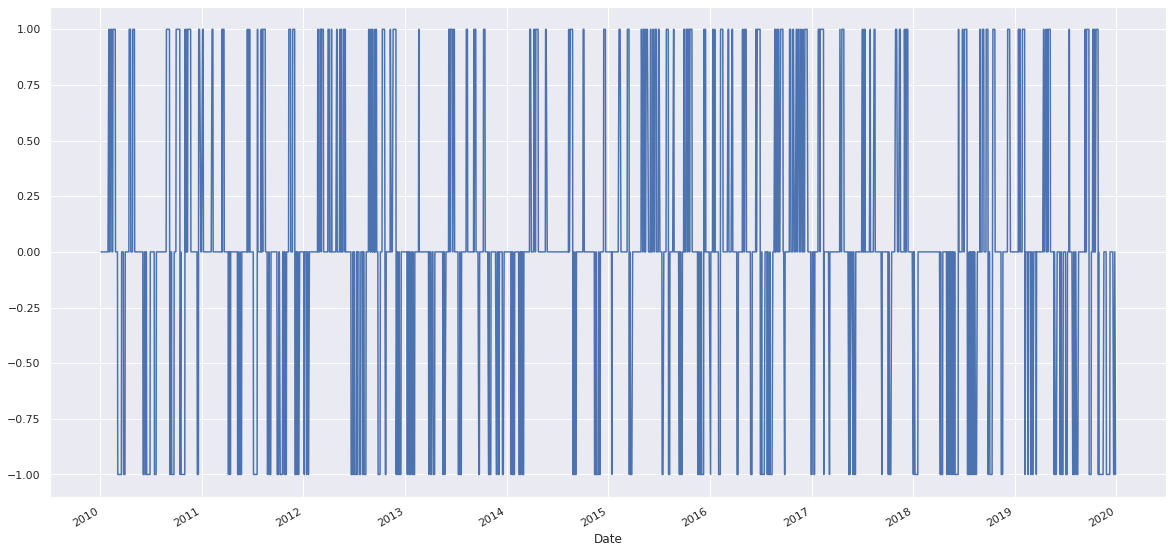

In [ ]:
# plot the position through time to get an idea of when we are long and when we are short
azn_so['Position'].plot(figsize=(20,10));

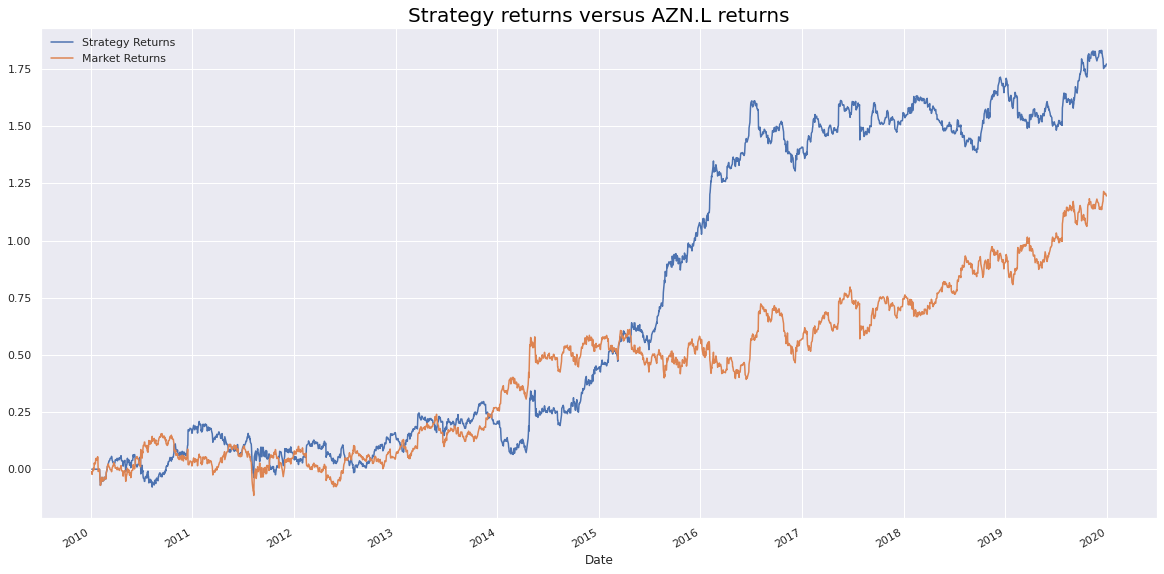

In [ ]:
#Set up a column holding the daily AZN.L returns
azn_so['Market Returns'] = azn_so['Close'].pct_change()

#Create column for Strategy Returns by multiplying the daily AZN.L returns by the position that was held at close
#of business the previous day
azn_so['Strategy Returns'] = azn_so['Market Returns'] * azn_so['Position'].shift(1)

#Finally plot the strategy returns versus AZN.L returns
azn_so[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(20,10));

plt.title('Strategy returns versus AZN.L returns', color = 'black', fontsize = 20);

The returns are positive at least, but we could have done much better by just buying and holding AZN.L stock, which is slightly disappointing.

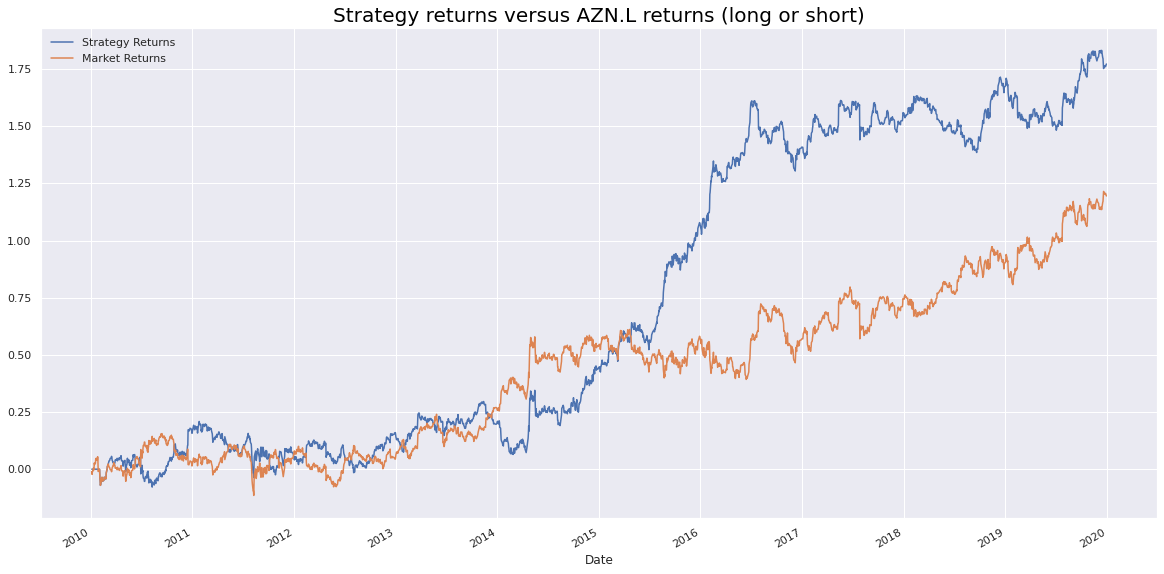

In [ ]:
# second implementation of the strategy – the one where we are either long or short

azn_so['L14'] = azn_so['Low'].rolling(window=14).min()
azn_so['H14'] = azn_so['High'].rolling(window=14).max()

azn_so['%K'] = 100*((azn_so['Close'] - azn_so['L14']) / (azn_so['H14'] - azn_so['L14']) )
azn_so['%D'] = azn_so['%K'].rolling(window=3).mean()

azn_so['Sell Entry'] = ((azn_so['%K'] < azn_so['%D']) & (azn_so['%K'].shift(1) > azn_so['%D'].shift(1))) & (azn_so['%D'] > 80)
azn_so['Buy Entry'] = ((azn_so['%K'] > azn_so['%D']) & (azn_so['%K'].shift(1) < azn_so['%D'].shift(1))) & (azn_so['%D'] < 20)

#Create empty "Position" column
azn_so['Position'] = np.nan 

#Set position to -1 for sell signals
azn_so.loc[azn_so['Sell Entry'],'Position'] = -1 

#Set position to -1 for buy signals
azn_so.loc[azn_so['Buy Entry'],'Position'] = 1 

#Set starting position to flat (i.e. 0)
azn_so['Position'].iloc[0] = 0 

#Forward fill the position column to show holding of positions through time
azn_so['Position'] = azn_so['Position'].fillna(method='ffill')

#Set up a column holding the daily AZN.L returns
azn_so['Market Returns'] = azn_so['Close'].pct_change()

#Create column for Strategy Returns by multiplying the daily AZN.L returns by the position that was held at close
#of business the previous day
azn_so['Strategy Returns'] = azn_so['Market Returns'] * azn_so['Position'].shift(1)

#Finally plot the strategy returns versus AZN.L returns
azn_so[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(20,10));

plt.title('Strategy returns versus AZN.L returns (long or short)', color = 'black', fontsize = 20);

This implementation gives a much better outcome for the second half of the back-tested period from 2015-2019.

### 5.2.4  Rate of Change (ROC) 

The ROC indicator is a pure momentum oscillator. The ROC calculation compares the current price with the price "n" periods ago e.g. when we compute the ROC of the daily price with a 9-day lag, we are simply looking at how much, in percentage, the price has gone up (or down) compared to 9 days ago. Like other momentum indicators, ROC has overbought and oversold zones that may be adjusted according to market conditions. 

In [ ]:
azn_roc = azn.copy()
azn_roc

Open    High          Low   Close    Adj Close   Volume
Date                                                                 
2010-01-04  2912.0  2946.0  2912.000000  2941.0  1775.206909  2091679
2010-01-05  2936.0  2949.5  2901.000000  2907.5  1754.986084  2869739
2010-01-06  2909.0  2909.0  2850.500000  2875.0  1735.368652  3136541
2010-01-07  2879.0  2925.5  2879.000000  2910.5  1756.796875  3748200
2010-01-08  2921.0  2927.5  2889.500000  2908.5  1755.589600  2473846
...            ...     ...          ...     ...          ...      ...
2019-12-20  7658.0  7808.0  7614.000000  7808.0  7592.499512  5860381
2019-12-23  7771.0  7824.0  7723.870117  7746.0  7532.210938  2183949
2019-12-24  7715.0  7794.0  7631.290039  7714.0  7501.093750   378885
2019-12-27  7706.0  7781.0  7641.000000  7745.0  7531.238281   862283
2019-12-30  7734.0  7767.0  7654.000000  7654.0  7442.750488  1394124

[2518 rows x 6 columns]

In [ ]:
azn_roc_12mo = azn_roc['2019-01-01':'2019-12-31']
azn_roc_12mo 

Open    High          Low   Close    Adj Close   Volume
Date                                                                 
2019-01-02  5857.0  5925.0  5743.000000  5903.0  5549.368164  1853042
2019-01-03  5877.0  6069.0  5841.000000  6010.0  5649.958008  2483351
2019-01-04  6037.0  6089.0  5944.000000  6089.0  5724.225098  2495405
2019-01-07  6082.0  6082.0  5982.000000  6005.0  5645.257324  2582745
2019-01-08  5953.0  6002.0  5898.000000  5898.0  5544.666992  2517905
...            ...     ...          ...     ...          ...      ...
2019-12-20  7658.0  7808.0  7614.000000  7808.0  7592.499512  5860381
2019-12-23  7771.0  7824.0  7723.870117  7746.0  7532.210938  2183949
2019-12-24  7715.0  7794.0  7631.290039  7714.0  7501.093750   378885
2019-12-27  7706.0  7781.0  7641.000000  7745.0  7531.238281   862283
2019-12-30  7734.0  7767.0  7654.000000  7654.0  7442.750488  1394124

[252 rows x 6 columns]

In [ ]:
azn_roc_12mo['ROC'] = ( azn_roc_12mo['Adj Close'] / azn_roc_12mo['Adj Close'].shift(9) -1 ) * 100
azn_roc_12mo[['Adj Close', 'ROC']]

Adj Close       ROC
Date                             
2019-01-02  5549.368164       NaN
2019-01-03  5649.958008       NaN
2019-01-04  5724.225098       NaN
2019-01-07  5645.257324       NaN
2019-01-08  5544.666992       NaN
...                 ...       ...
2019-12-20  7592.499512  8.114092
2019-12-23  7532.210938  6.900361
2019-12-24  7501.093750  5.584445
2019-12-27  7531.238281  6.460478
2019-12-30  7442.750488  6.055157

[252 rows x 2 columns]

In [ ]:
# selection of data - last 100 days

azn_roc_100d = azn_roc_12mo[-100:]
dates = azn_roc_100d.index
price = azn_roc_100d['Adj Close']
roc = azn_roc_100d['ROC']

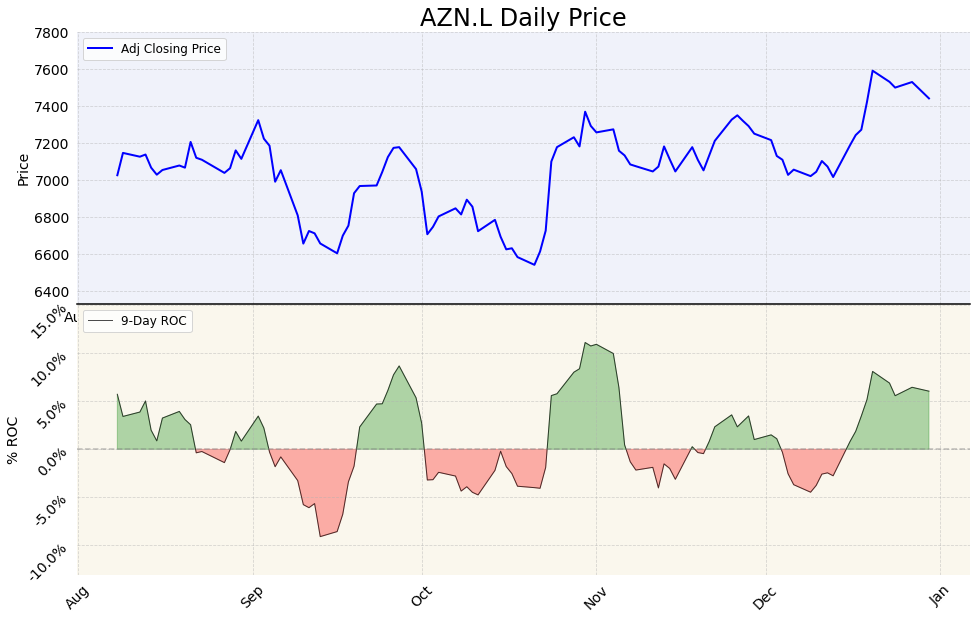

In [ ]:
# Plot AZN.L Adj Close Price and 9-day ROC for last 100 days of 2019

fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(hspace=0)

plt.rcParams.update({'font.size': 14})

# Price subplot
price_ax = plt.subplot(2, 1, 1)
price_ax.plot(dates, price, color='blue', linewidth=2, label="Adj Closing Price")
price_ax.legend(loc="upper left", fontsize=12)
price_ax.set_ylabel("Price")
price_ax.set_title("AZN.L Daily Price", fontsize=24)

# ROC subplot
roc_ax = plt.subplot(2, 1, 2, sharex = price_ax)
roc_ax.plot(roc, color='k', linewidth = 1, alpha=0.7, label="9-Day ROC")
roc_ax.legend(loc="upper left", fontsize=12)
roc_ax.set_ylabel("% ROC")

# Adding a horizontal line at the zero level in the ROC subplot:
roc_ax.axhline(0, color = (.5, .5, .5), linestyle = '--', alpha = 0.5)

# Filling the areas between the indicator and the level 0 line:
roc_ax.fill_between(dates, 0, roc, where = (roc >= 0), color='g', alpha=0.3, interpolate=True)
roc_ax.fill_between(dates, 0, roc, where = (roc  < 0), color='r', alpha=0.3, interpolate=True)

# Formatting the date labels
roc_ax.xaxis.set_major_formatter(DateFormatter('%b'))

# Formatting the labels on the y axis for ROC:
roc_ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

# Adding a grid to both subplots:
price_ax.grid(b=True, linestyle='--', alpha=0.5)
roc_ax.grid(b=True, linestyle='--', alpha=0.5)

# Setting a background color for the both subplots:
price_ax.set_facecolor((.94,.95,.98))
roc_ax.set_facecolor((.98,.97,.93))

# Adding margins around the plots:
price_ax.margins(0.05, 0.2)
roc_ax.margins(0.05, 0.2)

# Hiding the tick marks from the horizontal and vertical axis:
price_ax.tick_params(left=False, bottom=False)
roc_ax.tick_params(left=False, bottom=False, labelrotation=45)

# Hiding all the spines for the price subplot:
for s in price_ax.spines.values():
    s.set_visible(False)
# Hiding all the spines for the ROC subplot:
for s in roc_ax.spines.values():
    s.set_visible(False)

# To better separate the two subplots, we reinstate a spine in between them
roc_ax.spines['top'].set_visible(True)
roc_ax.spines['top'].set_linewidth(1.5)

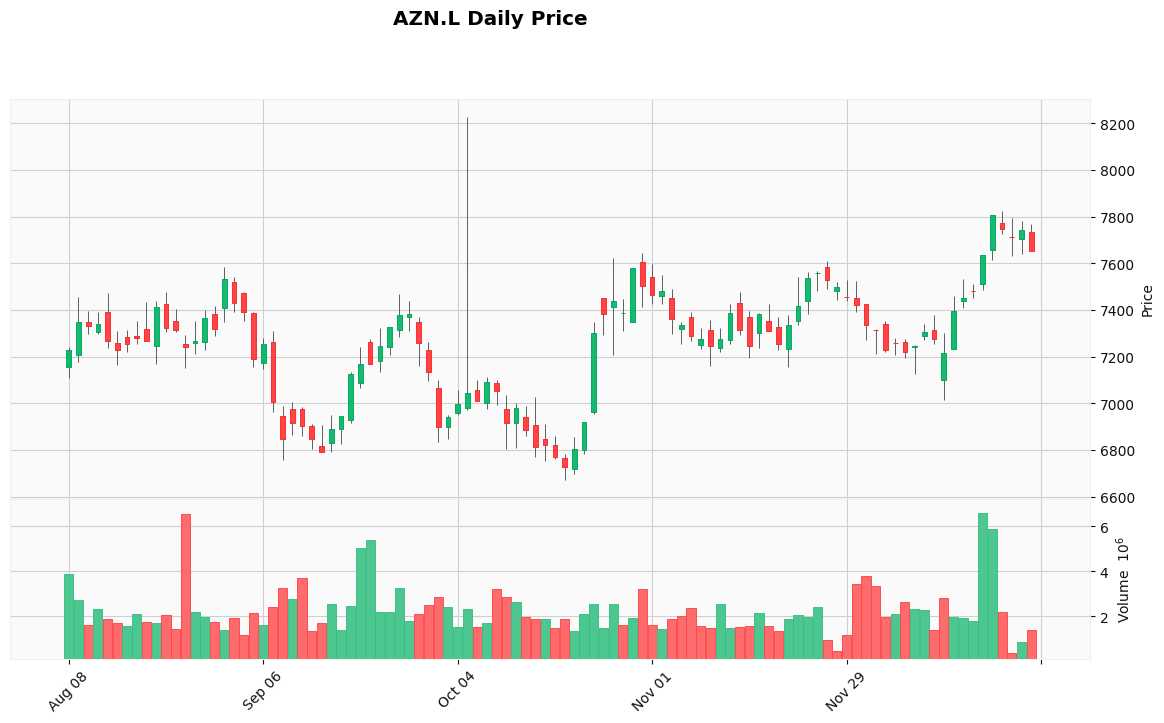

In [ ]:
# Candlestick and volume plot for same time frame

mpf.plot(azn_roc_100d, type='candle',  style='yahoo', figsize=(15,8),  title="AZN.L Daily Price", volume=True)


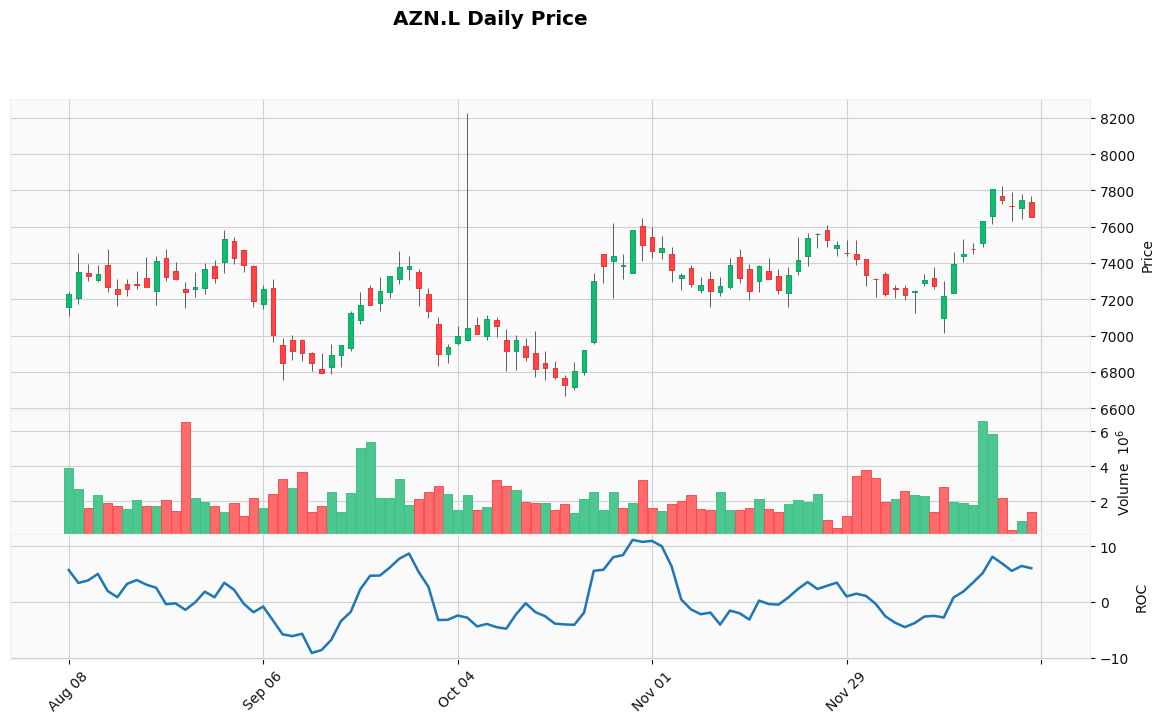

In [ ]:
# Combined Candlestick, ROC and Volume plot

# We create an additional plot planing it on the third panel
roc_plot = mpf.make_addplot(roc, panel=2, ylabel='ROC')

#We pass the additional plot using the addplot parameter
mpf.plot(azn_roc_100d, type='candle',  style='yahoo', figsize=(15,8), addplot=roc_plot, title="AZN.L Daily Price", volume=True)

## 5.3 Volatility trading strategies

Volatility trading involves predicting the stability of an asset’s value. Instead of trading on the price rising or falling, traders take a position on whether it will move in any direction.

### 5.3.1 Bollinger Bands

A Bollinger Band is a volatility indicator based on based on the correlation between the normal distribution and stock price and can be used to draw support and resistance curves. It is defined by a set of lines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of the security's price, but can be adjusted to user preferences.

By default it calculates a 20-period SMA (the middle band), an upper band two standard deviations above the the moving average and a lower band two standard deviations below it.

If the price moves above the upper band this could indicate a good time to sell, and if it moves below the lower band it could be a good time to buy. 

Whereas the RSI can only be used as a confirming factor inside a ranging market, not a trending market, by using Bollinger bands we can calculate the widening variable, or moving spread between the upper and the lower bands, that tells us if prices are about to trend and whether the RSI signals might not be that reliable.

Despite 90% of the price action happening between the bands, however, a breakout is not necessarily a trading signal as it provides no clue as to the direction and extent of future price movement.

In [ ]:
azn_12mo

Open    High          Low   Close    Adj Close   Volume
Date                                                                 
2019-01-02  5857.0  5925.0  5743.000000  5903.0  5549.368164  1853042
2019-01-03  5877.0  6069.0  5841.000000  6010.0  5649.958008  2483351
2019-01-04  6037.0  6089.0  5944.000000  6089.0  5724.225098  2495405
2019-01-07  6082.0  6082.0  5982.000000  6005.0  5645.257324  2582745
2019-01-08  5953.0  6002.0  5898.000000  5898.0  5544.666992  2517905
...            ...     ...          ...     ...          ...      ...
2019-12-20  7658.0  7808.0  7614.000000  7808.0  7592.499512  5860381
2019-12-23  7771.0  7824.0  7723.870117  7746.0  7532.210938  2183949
2019-12-24  7715.0  7794.0  7631.290039  7714.0  7501.093750   378885
2019-12-27  7706.0  7781.0  7641.000000  7745.0  7531.238281   862283
2019-12-30  7734.0  7767.0  7654.000000  7654.0  7442.750488  1394124

[252 rows x 6 columns]

In [ ]:
azn_12mo_bb = azn_12mo.copy()

In [ ]:
azn_12mo_bb

Open    High          Low   Close    Adj Close   Volume
Date                                                                 
2019-01-02  5857.0  5925.0  5743.000000  5903.0  5549.368164  1853042
2019-01-03  5877.0  6069.0  5841.000000  6010.0  5649.958008  2483351
2019-01-04  6037.0  6089.0  5944.000000  6089.0  5724.225098  2495405
2019-01-07  6082.0  6082.0  5982.000000  6005.0  5645.257324  2582745
2019-01-08  5953.0  6002.0  5898.000000  5898.0  5544.666992  2517905
...            ...     ...          ...     ...          ...      ...
2019-12-20  7658.0  7808.0  7614.000000  7808.0  7592.499512  5860381
2019-12-23  7771.0  7824.0  7723.870117  7746.0  7532.210938  2183949
2019-12-24  7715.0  7794.0  7631.290039  7714.0  7501.093750   378885
2019-12-27  7706.0  7781.0  7641.000000  7745.0  7531.238281   862283
2019-12-30  7734.0  7767.0  7654.000000  7654.0  7442.750488  1394124

[252 rows x 6 columns]

In [ ]:
#Get the time period (20 days)
period = 20
# Calculate the 20 Day Simple Moving Average, Std Deviation, Upper Band and Lower Band
#Calculating the Simple Moving Average
azn_12mo_bb['SMA'] = azn_12mo_bb['Close'].rolling(window=period).mean()
# Get the standard deviation
azn_12mo_bb['STD'] = azn_12mo_bb['Close'].rolling(window=period).std()
#Calculate the Upper Bollinger Band
azn_12mo_bb['Upper'] = azn_12mo_bb['SMA'] + (azn_12mo_bb['STD'] * 2)
#Calculate the Lower Bollinger Band
azn_12mo_bb['Lower'] = azn_12mo_bb['SMA'] - (azn_12mo_bb['STD'] * 2)
#Create a list of columns to keep
column_list = ['Close', 'SMA', 'Upper', 'Lower']

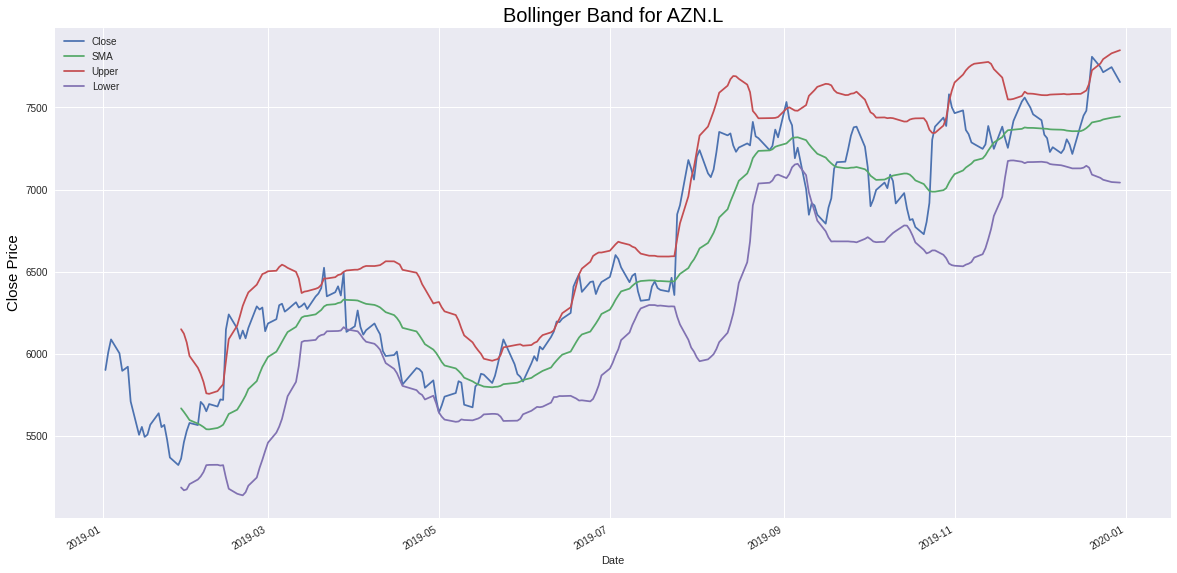

In [ ]:
def bb_12mo():
  azn_12mo_bb[column_list].plot(figsize=(20,10))
  plt.style.use('seaborn')
  plt.title('Bollinger Band for AZN.L', color = 'black', fontsize = 20)
  plt.ylabel('Close Price', color = 'black', fontsize = 15)
  plt.show();

bb_12mo()

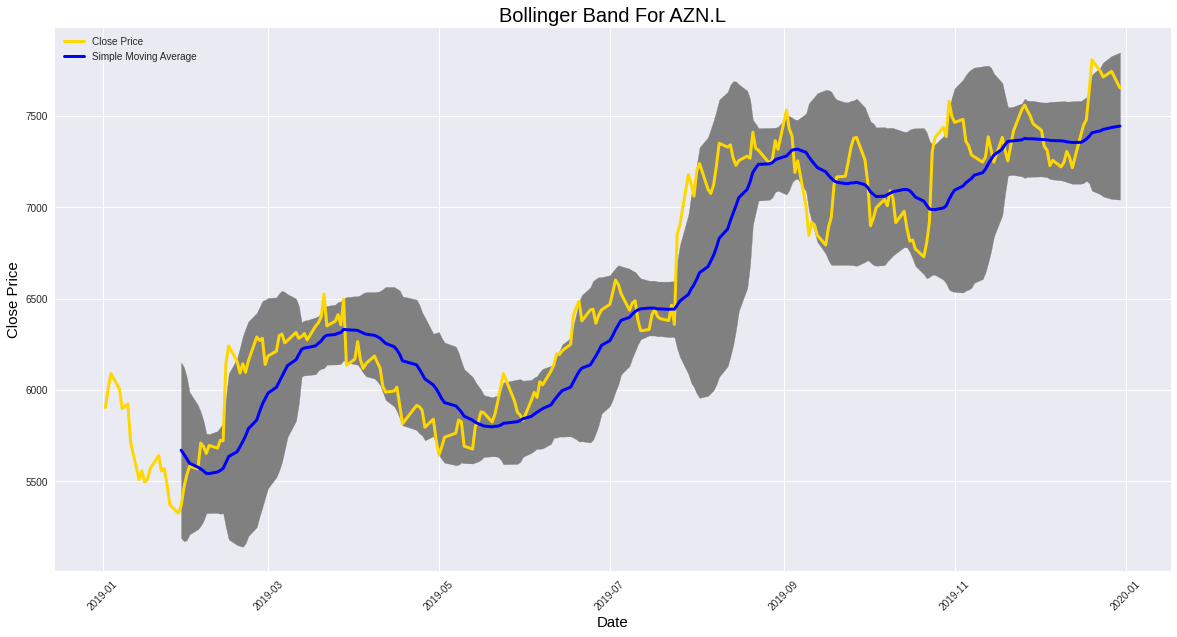

In [ ]:
#Plot and shade the area between the two Bollinger bands

def bb_shaded():
  #Get the figure and the figure size
  fig = plt.figure(figsize=(20,10)) 

  #Add the subplot
  ax = fig.add_subplot(1,1,1) #Number of rows, cols, & index

  # Get the index values of the DataFrame
  x_axis = azn_12mo_bb.index

  # Plot and shade the area between the upper band and the lower band Grey
  ax.fill_between(x_axis, azn_12mo_bb['Upper'], azn_12mo_bb['Lower'], color='grey')

  # Plot the Closing Price and Moving Average
  ax.plot(x_axis, azn_12mo_bb['Close'], color='gold', lw=3, label = 'Close Price') #lw = line width
  ax.plot(x_axis, azn_12mo_bb['SMA'], color='blue', lw=3, label = 'Simple Moving Average')

  # Set the Title & Show the Image
  ax.set_title('Bollinger Band For AZN.L', color = 'black', fontsize = 20)
  ax.set_xlabel('Date', color = 'black', fontsize = 15)
  ax.set_ylabel('Close Price', color = 'black', fontsize = 15)
  plt.xticks(rotation = 45)
  ax.legend()
  plt.show();

bb_shaded()

In [ ]:
#Create a new data frame
new_azn_12mo_bb = azn_12mo_bb[period-1:]
#Show the new data frame
new_azn_12mo_bb

Open    High          Low  ...         STD        Upper        Lower
Date                                     ...                                      
2019-01-29  5345.0  5421.0  5322.000000  ...  240.597562  6151.045124  5188.654876
2019-01-30  5364.0  5476.0  5364.000000  ...  238.221016  6124.342033  5171.457967
2019-01-31  5488.0  5559.0  5471.000000  ...  223.504150  6071.008301  5176.991699
2019-02-01  5549.0  5598.0  5532.000000  ...  194.915474  5988.430949  5208.769051
2019-02-04  5580.0  5625.0  5542.000000  ...  169.841373  5916.432747  5237.067253
...            ...     ...          ...  ...         ...          ...          ...
2019-12-20  7658.0  7808.0  7614.000000  ...  158.605593  7725.761187  7091.338813
2019-12-23  7771.0  7824.0  7723.870117  ...  173.718306  7766.486613  7071.613387
2019-12-24  7715.0  7794.0  7631.290039  ...  183.435884  7793.621769  7059.878231
2019-12-27  7706.0  7781.0  7641.000000  ...  195.720121  7828.990242  7046.109758
2019-12-30  7734.0  7767.0  7654.000000  ...  201.257331  7847.764661  7042.735339

[233 rows x 10 columns]

In [ ]:
# Create a function to get the buy and sell signals
def get_signal_bb(data):
  buy_signal = [] #buy list
  sell_signal = [] #sell list

  for i in range(len(data['Close'])):
      if data['Close'][i] > data['Upper'][i]: #Then you should sell 
        buy_signal.append(np.nan)
        sell_signal.append(data['Close'][i])
      elif data['Close'][i] < data['Lower'][i]: #Then you should buy
        sell_signal.append(np.nan)
        buy_signal.append(data['Close'][i])
      else:
        buy_signal.append(np.nan)
        sell_signal.append(np.nan)
  return (buy_signal, sell_signal)

In [ ]:
#Create new columns for the buy and sell signals
new_azn_12mo_bb['Buy'] = get_signal_bb(new_azn_12mo_bb)[0]
new_azn_12mo_bb['Sell'] = get_signal_bb(new_azn_12mo_bb)[1]

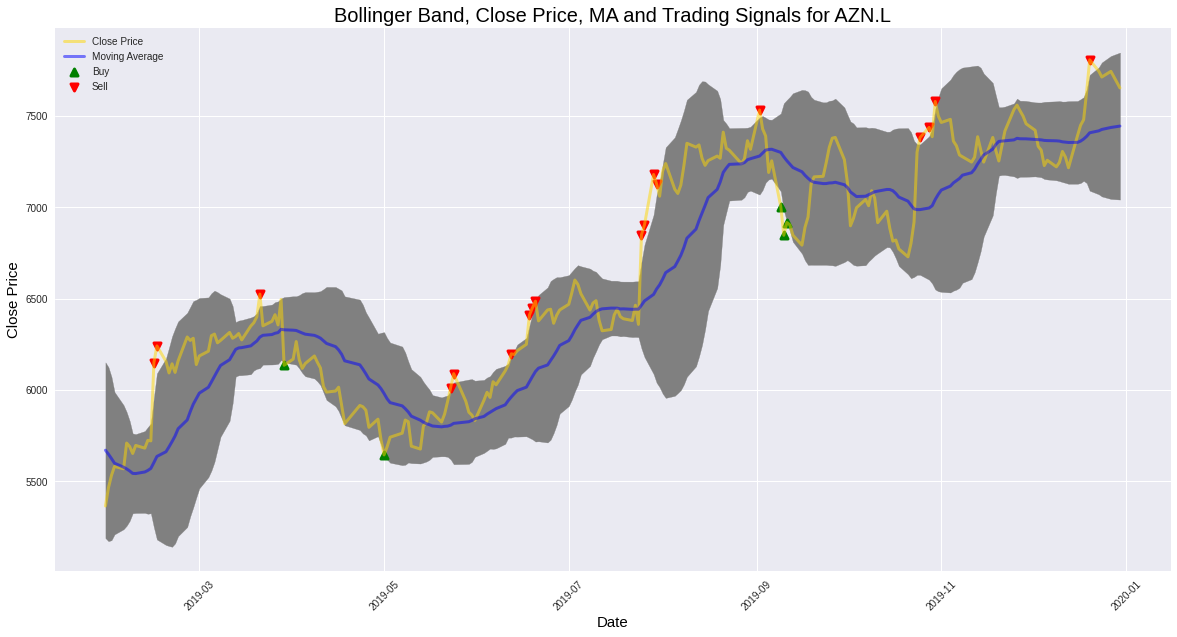

In [ ]:
#Plot all of the data

def bb_alldata():
  #Get the figure and the figure size
  fig = plt.figure(figsize=(20,10))

  #Add the subplot
  ax = fig.add_subplot(1,1,1) #Number of rows, cols, & index
  # Get the index values of the DataFrame
  x_axis = new_azn_12mo_bb.index
  # Plot and shade the area between the upper band and the lower band Grey

  ax.fill_between(x_axis, new_azn_12mo_bb['Upper'], new_azn_12mo_bb['Lower'], color='grey')
  # Plot the Closing Price and Moving Average
  ax.plot(x_axis, new_azn_12mo_bb['Close'], color='gold', lw=3, label = 'Close Price',alpha = 0.5)
  ax.plot(x_axis, new_azn_12mo_bb['SMA'], color='blue', lw=3, label = 'Moving Average',alpha = 0.5)
  ax.scatter(x_axis, new_azn_12mo_bb['Buy'] , color='green', lw=3, label = 'Buy',marker = '^', alpha = 1)
  ax.scatter(x_axis, new_azn_12mo_bb['Sell'] , color='red', lw=3, label = 'Sell',marker = 'v', alpha = 1)
  # Set the Title & Show the Image
  ax.set_title('Bollinger Band, Close Price, MA and Trading Signals for AZN.L', color = 'black', fontsize = 20)
  ax.set_xlabel('Date', color = 'black', fontsize = 15)
  ax.set_ylabel('Close Price', color = 'black', fontsize = 15)
  plt.xticks(rotation = 45)
  ax.legend()
  plt.show();

bb_alldata()

The Bollinger Bands technical indicator is an example of a mean reversion strategy. 

### 5.3.2 Mean reversion strategies

In mean reversion algorithmic trading strategies stocks return to their mean and we can exploit when it deviates from that mean.

These strategies usually involve selling into up moves and buying into down moves, a contrarian approach which assumes that the market has become oversold/overbought and prices will revert to their historical trends. This is almost the opposite of trend following where we enter in the direction of the strength and momentum, and momentum strategies such as buying stocks that have been showing an upward trend in hopes that the trend will continue, a continuation approach. 

### Pairs Trading

Pairs Trading is a market neutral trading strategy and a type of statistical arbitrage, which is exploiting statistical properties that we believe can make money if they continue. 

The basic idea is to select two cointegrated stocks which move similarly/are statistically related and deviate from their mean. Then sell the high priced stock and buy the low priced stock where there is a price divergence between the pairs. You make money from a pairs trade when your “long” outperforms your “short”: If your “long” rises more than your “short” or if your “long” falls less than your “short”.

Pairs Trading can be called a mean reversion strategy where we bet that the prices will revert to their historical trends.

In [ ]:
# create copy of FTSE100 stocks to find two cointegrated stocks for pairs trading

ftse100_stocks_pairs = ftse100_stocks.copy()
ftse100_stocks_pairs

ULVR.L                       ...        BP.L                      
              Open         High     Low  ...       Close   Adj Close    Volume
Date                                     ...                                  
2010-01-04  1987.0  2006.000000  1981.0  ...  613.599976  323.723907  17956918
2010-01-05  1990.0  1997.000000  1942.0  ...  620.099976  327.153046  28352666
2010-01-06  1943.0  1955.000000  1935.0  ...  619.400024  326.783966  22054752
2010-01-07  1948.0  1961.000000  1926.0  ...  623.299988  328.841431  30630196
2010-01-08  1941.0  1948.000000  1917.0  ...  621.700012  327.997284  22458240
...            ...          ...     ...  ...         ...         ...       ...
2019-12-20  4351.5  4378.500000  4333.5  ...  485.049988  431.790558  88659433
2019-12-23  4382.0  4466.500000  4357.5  ...  489.049988  435.351318  44590108
2019-12-24  4409.0  4411.720215  4382.0  ...  487.700012  434.149597   6020955
2019-12-27  4395.5  4429.000000  4372.5  ...  483.950012  430.811340  24712316
2019-12-30  4426.0  4430.220215  4372.5  ...  478.500000  425.959747  35078105

[2518 rows x 36 columns]

In [ ]:
# Concise summary of the dataframe

ftse100_stocks_pairs.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2010-01-04 to 2019-12-30
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (ULVR.L, Open)       2518 non-null   float64
 1   (ULVR.L, High)       2518 non-null   float64
 2   (ULVR.L, Low)        2518 non-null   float64
 3   (ULVR.L, Close)      2518 non-null   float64
 4   (ULVR.L, Adj Close)  2518 non-null   float64
 5   (ULVR.L, Volume)     2518 non-null   int64  
 6   (RDSB.L, Open)       2518 non-null   float64
 7   (RDSB.L, High)       2518 non-null   float64
 8   (RDSB.L, Low)        2518 non-null   float64
 9   (RDSB.L, Close)      2518 non-null   float64
 10  (RDSB.L, Adj Close)  2518 non-null   float64
 11  (RDSB.L, Volume)     2518 non-null   int64  
 12  (GSK.L, Open)        2518 non-null   float64
 13  (GSK.L, High)        2518 non-null   float64
 14  (GSK.L, Low)         2518 non-null   float64
 15  (GSK.L, Close)      

In [ ]:
# Descriptive statistics for FTSE 100 stocks

ftse100_stocks_pairs.describe()

ULVR.L               ...         BP.L              
              Open         High  ...    Adj Close        Volume
count  2518.000000  2518.000000  ...  2518.000000  2.518000e+03
mean   3009.072589  3032.981653  ...   314.465199  3.431789e+07
std     942.883609   949.617451  ...    77.295875  1.926278e+07
min    1688.000000  1694.000000  ...   162.197952  0.000000e+00
25%    2156.500000  2173.000000  ...   255.162006  2.338165e+07
50%    2753.500000  2778.000000  ...   291.255646  3.025268e+07
75%    3992.875000  4020.750000  ...   357.829140  3.961792e+07
max    5333.000000  5333.000000  ...   494.692047  3.183580e+08

[8 rows x 36 columns]

In [ ]:
ulvr_historical =  ftse100_stocks_pairs['ULVR.L']
rdsb_historical =  ftse100_stocks_pairs['RDSB.L']
bp_historical =  ftse100_stocks_pairs['BP.L']
azn_historical =  ftse100_stocks_pairs['AZN.L']
gsk_historical =  ftse100_stocks_pairs['GSK.L']
hsbc_historical =  ftse100_stocks_pairs['HSBA.L']

In [ ]:
# DataFrame of the closing price of selected stocks

ftse100_stocks_close = pd.DataFrame({"ULVR.L": ulvr_historical.Close,
                                "RDSB.L": rdsb_historical.Close,
                                "BP.L": bp_historical.Close,
                                "AZN.L": azn_historical.Close,
                                "GSK.L": gsk_historical.Close,
                                "HBSA.L": hsbc_historical.Close
                                })
ftse100_stocks_close.head()

ULVR.L  RDSB.L        BP.L   AZN.L   GSK.L      HBSA.L
Date                                                              
2010-01-04  1996.0  1862.5  613.599976  2941.0  1339.5  726.500000
2010-01-05  1953.0  1883.5  620.099976  2907.5  1307.0  737.000000
2010-01-06  1955.0  1859.0  619.400024  2875.0  1295.5  740.400024
2010-01-07  1931.0  1855.0  623.299988  2910.5  1293.5  736.500000
2010-01-08  1936.0  1835.0  621.700012  2908.5  1281.0  740.000000

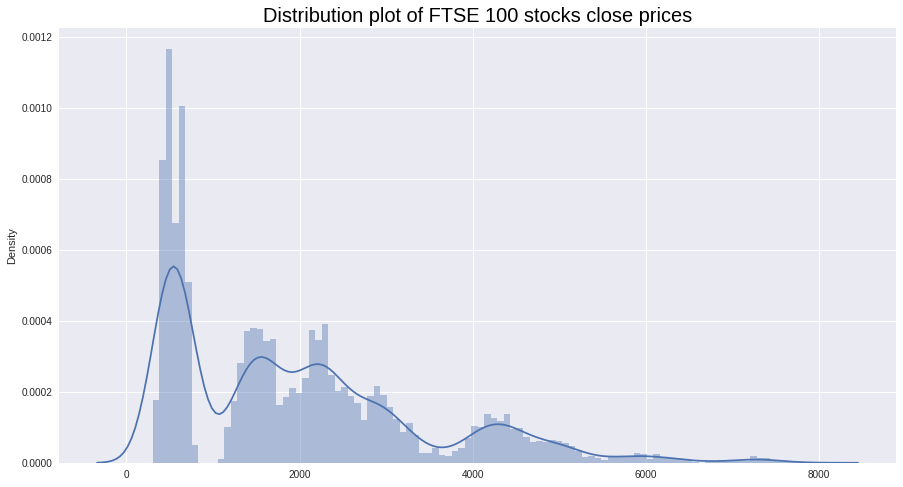

In [ ]:
# Distribution plot of close prices

def dist_plt():
  plt.style.use('seaborn')
  plt.figure(figsize=(15, 8))
  plt.title("Distribution plot of FTSE 100 stocks close prices", color = 'black', fontsize = 20)
  sns.distplot(ftse100_stocks_close, bins=100, kde=True);

dist_plt()

The distribution of prices is always positive. It has a very long tail and a high peak near zero. This is because we are looking at prices from different stocks with diverse closing prices over 10 years. 

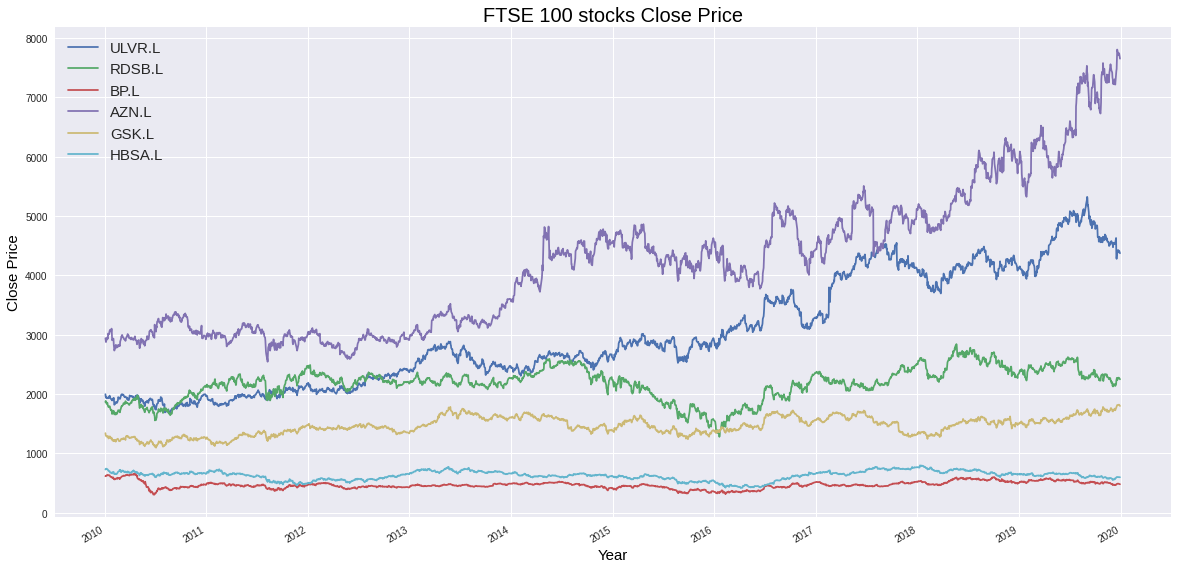

In [ ]:
# Plot close prices of selected stocks

def ftse_close():
  ftse100_stocks_close.plot(figsize=(20,10))
  plt.title('FTSE 100 stocks Close Price', color = 'black', fontsize = 20)
  plt.legend(fontsize=15)
  plt.xlabel('Year', color = 'black', fontsize = 15)
  plt.ylabel('Close Price', color = 'black', fontsize = 15);

ftse_close()

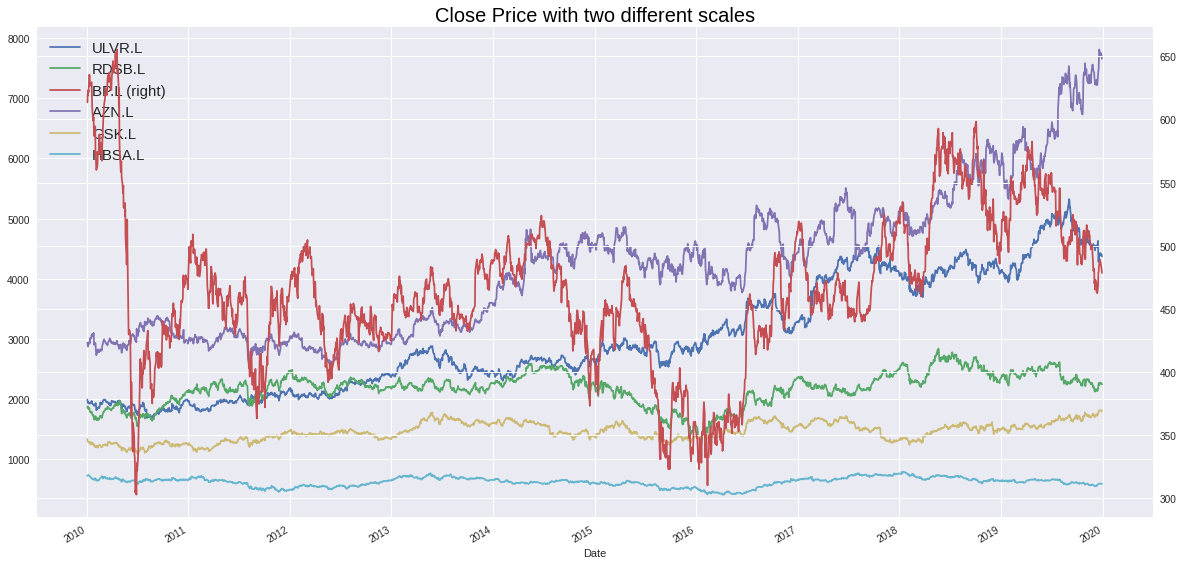

In [ ]:
def two_scales():
  ax = ftse100_stocks_close.plot(secondary_y = ["BP.L"], grid = True, legend = True, figsize=(20,10))
  plt.title('Close Price with two different scales', color = 'black', fontsize = 20);

two_scales()

### Correlation

We will compute the correlation, or strength and direction of the linear relationship between pairs of stocks.

In [ ]:
np.corrcoef(azn_historical['Close'], ulvr_historical['Close'])

array([[1.        , 0.90992879],
       [0.90992879, 1.        ]])

In [ ]:
# compute the correlations between every pair of stocks
correlation_matrix = ftse100_stocks_close.corr() 
correlation_matrix

ULVR.L    RDSB.L      BP.L     AZN.L     GSK.L    HBSA.L
ULVR.L  1.000000  0.425369  0.344069  0.909929  0.579863  0.236608
RDSB.L  0.425369  1.000000  0.632555  0.382872  0.433766  0.456654
BP.L    0.344069  0.632555  1.000000  0.335864  0.205233  0.578167
AZN.L   0.909929  0.382872  0.335864  1.000000  0.549093  0.124637
GSK.L   0.579863  0.433766  0.205233  0.549093  1.000000  0.070935
HBSA.L  0.236608  0.456654  0.578167  0.124637  0.070935  1.000000

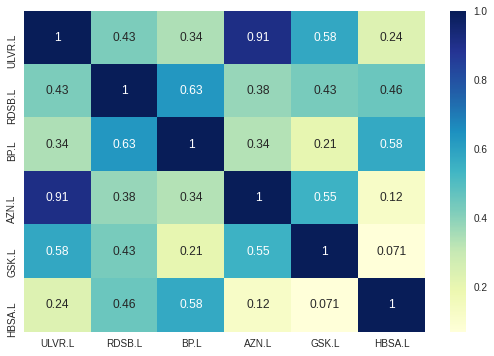

In [ ]:
# Plot correlation heatmap

sns.heatmap(ftse100_stocks_close.corr(), annot=True, cmap="YlGnBu");

The strongest linear correlation is between AZN.L and ULVR.L with 0.91. This high number represents a strong relationship between the two stocks. So if A goes up, the chances of B going up are also quite high. Based on this assumption a market neutral strategy is played where A is bought and B is sold; bought and sold decisions are made based on their individual patterns.

---



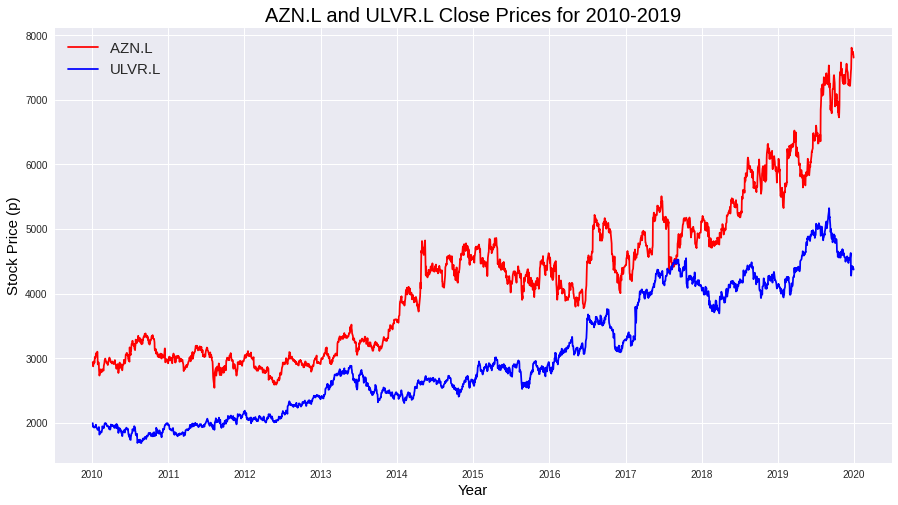

In [ ]:
# Plot AZN.L and ULVR.L stocks

def stocks_azn_ulvr():
  plt.figure(figsize=(15, 8))
  plt.plot(ftse100_stocks_close.index, azn_historical['Close'], label = 'AZN.L ', color= 'red')
  plt.plot(ftse100_stocks_close.index, ulvr_historical['Close'], label = 'ULVR.L', color= 'blue')
  plt.title("AZN.L and ULVR.L Close Prices for 2010-2019", color = 'black', fontsize = 20)
  plt.xlabel('Year', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend(loc='upper left')
  plt.show()

stocks_azn_ulvr()

### Feature extraction - Price ratio

We need to calculate a ratio of one stock's price to another, so that we can know how much of each to buy and sell.

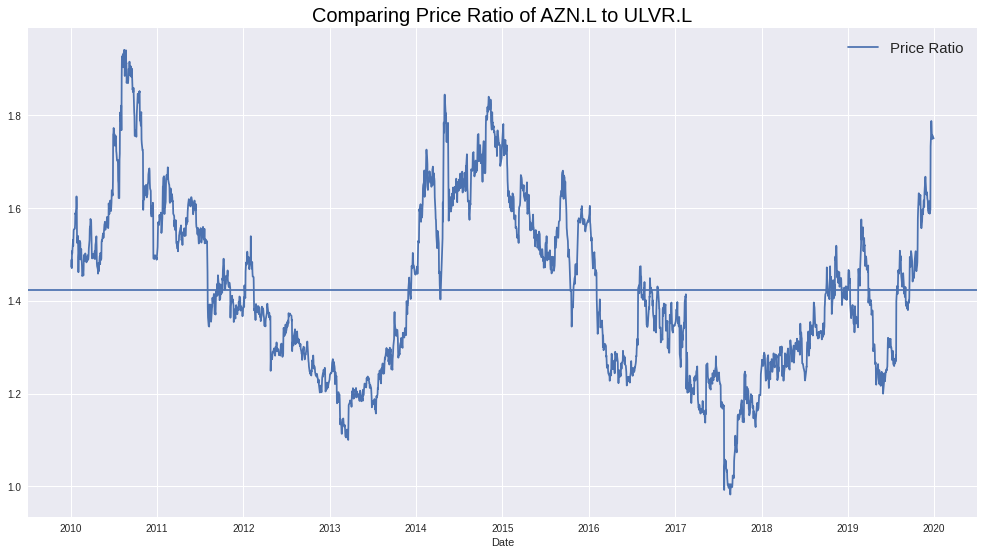

In [ ]:
# Plot comparison of price ratio for AZN.L and ULVR.L 

stock1 = ftse100_stocks_close['AZN.L'] # get the first price series
stock2 = ftse100_stocks_close['ULVR.L'] # get the second price series
ratios = stock1 / stock2 # calculate the ratio of prices
plt.figure(figsize=(17,9))
sns.lineplot(data=ratios) # Plot the price ratio
plt.axhline(ratios.mean()) # Draw the average value
plt.legend(['Price Ratio'], loc='upper right', fontsize = 15)
plt.title('Comparing Price Ratio of AZN.L to ULVR.L', color = 'black', fontsize = 20);

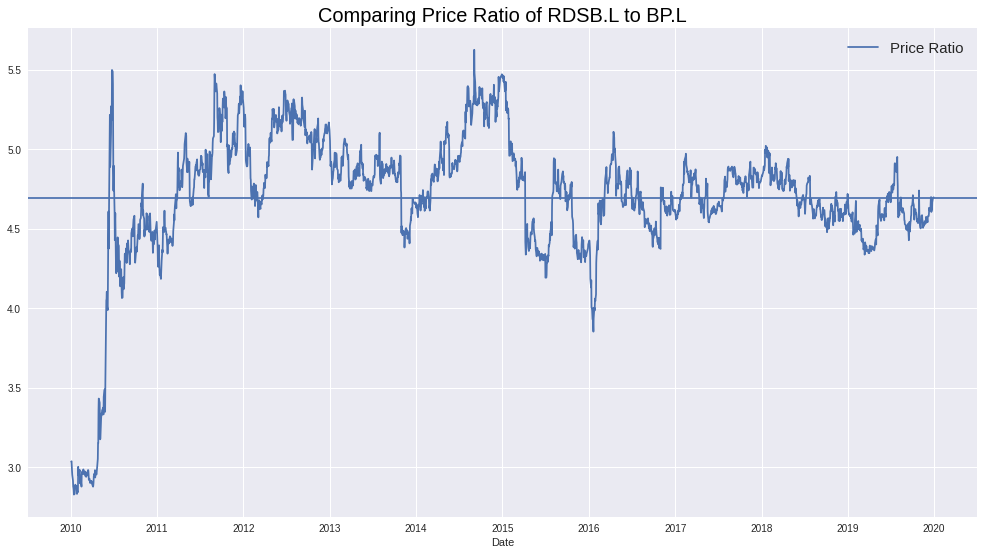

In [ ]:
# Plot comparison of price ratio for oil stocks RSDB.L and BP.L 

stock3 = ftse100_stocks_close['RDSB.L'] # get the first price series
stock4 = ftse100_stocks_close['BP.L'] # get the second price series
ratios2 = stock3 / stock4 # calculate the ratio of prices
plt.figure(figsize=(17,9))
sns.lineplot(data=ratios2) # Plot the price ratio
plt.axhline(ratios2.mean()) # Draw the average value
plt.style.use('seaborn')
plt.legend(['Price Ratio'], loc='upper right', fontsize = 15) 
plt.title('Comparing Price Ratio of RDSB.L to BP.L', color = 'black', fontsize = 20);


Our pair of stocks do seem to float around some ratio and return to it and appear to be mean reverting. At a point where the ratio is far away from its mean, we will buy some of one stock and sell/short some of the other so that we are net neutral in our exposure to the stocks.

### Feature scaling - Z-scores

The z-score tells you how many standard deviations you are away from the mean. It is the ratio value minus its mean divided by the standard deviation of the ratio. As a measure of an observation's variability it can be used by traders to help determine market volatility. 


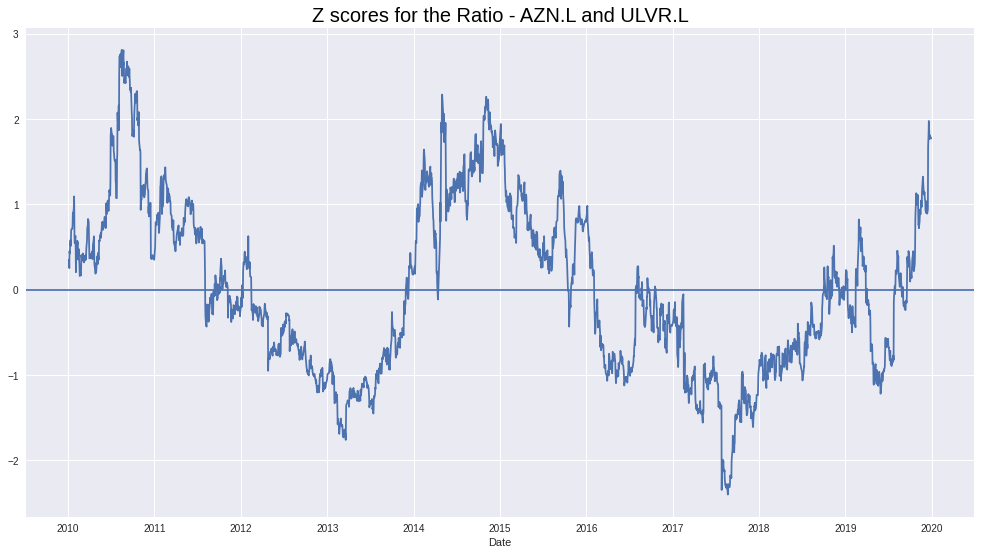

In [ ]:
# Plot Z-scores for AZN.L and ULVR.L  

plt.figure(figsize=(17, 9))
zscores = zscore(ratios) # Let's transform to a series of Z-scores
sns.lineplot(x=ratios.index, y=zscores) # Make another line plot
plt.axhline(zscores.mean()) 
plt.title('Z scores for the Ratio - AZN.L and ULVR.L', color = 'black', fontsize = 20);

We could imagine entering the trade in early 2013 or mid 2017, when the z score is around -1.75 and below -2.5 respectively, and taking our gains as the line comes back towards 0 in late 2013 and late 2018. We could do the same in 2014 when the z score was about 2.25.

The problem with correlation is that it is not often used in real pairs trading. Just because two price series are correlated, we do not know that they will be profitable. We would like to know that if there is a price difference between two stocks that grows, that it will shrink in the future. Two stocks can be correlated if there is a price ratio that keeps on growing without a return towards a fixed value.

We will try another pair before looking at another statistical property called cointegration.

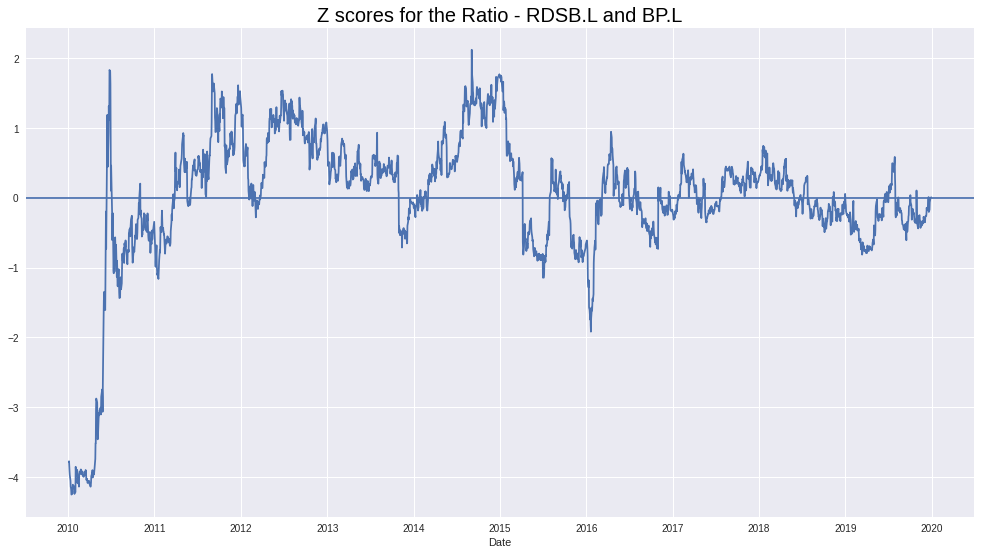

In [ ]:
# Plot Z-scores for RDSB.L and BP.L

plt.figure(figsize=(17, 9))
zscores2 = zscore(ratios2) # Let's transform to a series of Z-scores
sns.lineplot(x=ratios2.index, y=zscores2) # Make another line plot
plt.axhline(zscores2.mean()) 
plt.title('Z scores for the Ratio - RDSB.L and BP.L', color = 'black', fontsize = 20);

We could imagine entering the trade in early 2010 when the z score is around -4.25 and taking our gains as the line comes back towards 0. We could do the same in 2014 when the z score was just above 2.

### Cointegration

The most common test for Pairs Trading is the cointegration test. Cointegration is a statistical property of two or more time-series variables which indicates if a linear combination of the variables is stationary. 

It means that the ratio we computed will revert back to some mean value as opposed to drifting higher or lower over time. While correlation is the statistical tendency of two variables to move together, cointegration is a slightly stricter requirement.

In [ ]:
# Augmented Dickey-Fuller test to check stationarity

def stationarity(a, cutoff = 0.05):
    a = np.ravel(a)
    if adfuller(a)[1] < cutoff:
      print('The series is stationary')
      print('p-value = ', adfuller(a)[1])
    else:
      print('The series is NOT stationary')
      print('p-value = ', adfuller(a)[1])

In [ ]:
stationarity(azn_historical['Close'])

The series is NOT stationary
p-value =  0.9518851975163528


In [ ]:
stationarity(ulvr_historical['Close'])

The series is NOT stationary
p-value =  0.8461468317685167


Neither AZN.L nor ULVR.L are stationary.

In [ ]:
# Check cointegration

def cointegration(a, b):
    if coint(a, b)[1] < 0.05:
      print('The series are cointegrated')
      print('p-value = ', coint(a,b)[1])  
    else:
      print('The series are NOT cointegrated')
      print('p-value = ', coint(a,b)[1])  

In [ ]:
cointegration(azn_historical['Close'], ulvr_historical['Close'])

The series are NOT cointegrated
p-value =  0.7619218122410716


AZN.L and ULVR.L are not cointegrated, so we will try AZN.L and GSK.L as they are the same industry - pharmaceuticals.

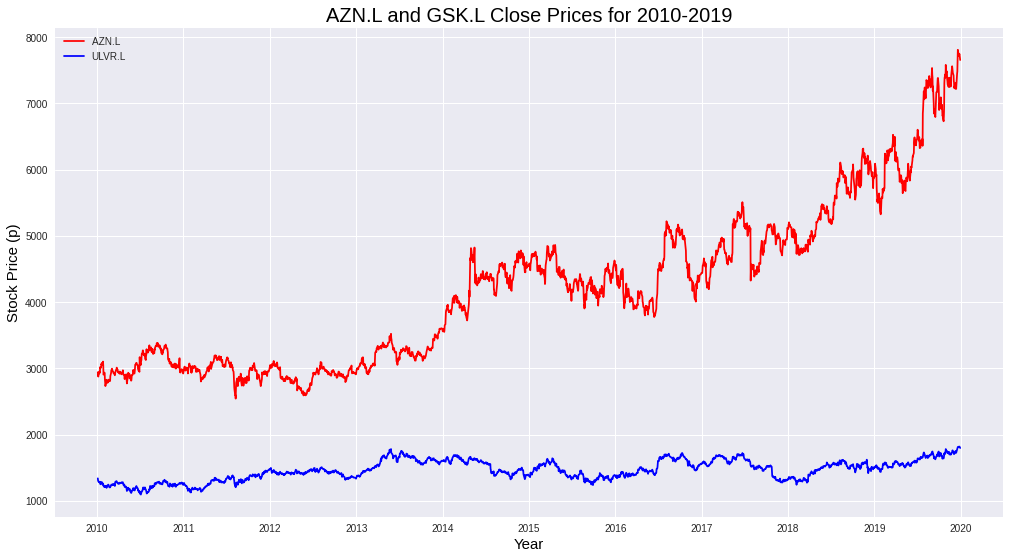

In [ ]:
# Plot AZN.L and GSK.L stocks

def stocks_azn_gsk():
  plt.figure(figsize=(17, 9))
  plt.plot(ftse100_stocks_close.index, azn_historical['Close'], label = 'AZN.L ', color= 'red')
  plt.plot(ftse100_stocks_close.index, gsk_historical['Close'], label = 'ULVR.L', color= 'blue')
  plt.title("AZN.L and GSK.L Close Prices for 2010-2019", color = 'black', fontsize = 20)
  plt.xlabel('Year', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend(loc='upper left')
  plt.show()

stocks_azn_gsk()

In [ ]:
cointegration(azn_historical['Close'], gsk_historical['Close'])

The series are NOT cointegrated
p-value =  0.901425141204323


Despite being the same industry they are not cointegrated so we will try RDSB.L and BP.L, both oil stocks.

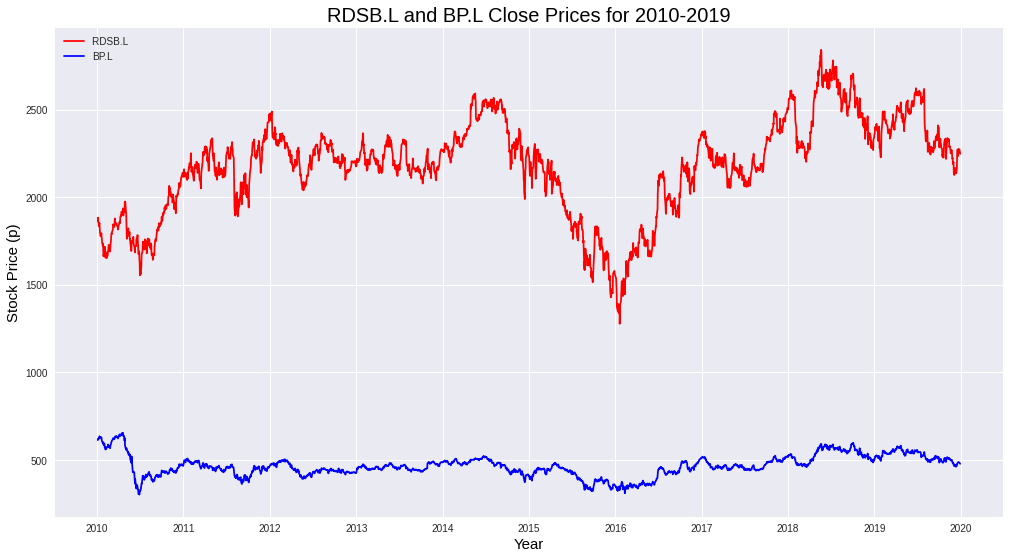

In [ ]:
# Plot RDSB.L and BP.L stocks

def stocks_rdsb_bp():
  plt.figure(figsize=(17, 9))
  plt.plot(ftse100_stocks_close.index, rdsb_historical['Close'], label = 'RDSB.L ', color= 'red')
  plt.plot(ftse100_stocks_close.index, bp_historical['Close'], label = 'BP.L', color= 'blue')
  plt.title("RDSB.L and BP.L Close Prices for 2010-2019", color = 'black', fontsize = 20)
  plt.xlabel('Year', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend(loc='upper left')
  plt.show()

stocks_rdsb_bp()

In [ ]:
oil_stocks_close = pd.DataFrame({"RDSB.L": rdsb_historical.Close,
                                "BP.L": bp_historical.Close
                                })
oil_stocks_close.head()

RDSB.L        BP.L
Date                          
2010-01-04  1862.5  613.599976
2010-01-05  1883.5  620.099976
2010-01-06  1859.0  619.400024
2010-01-07  1855.0  623.299988
2010-01-08  1835.0  621.700012

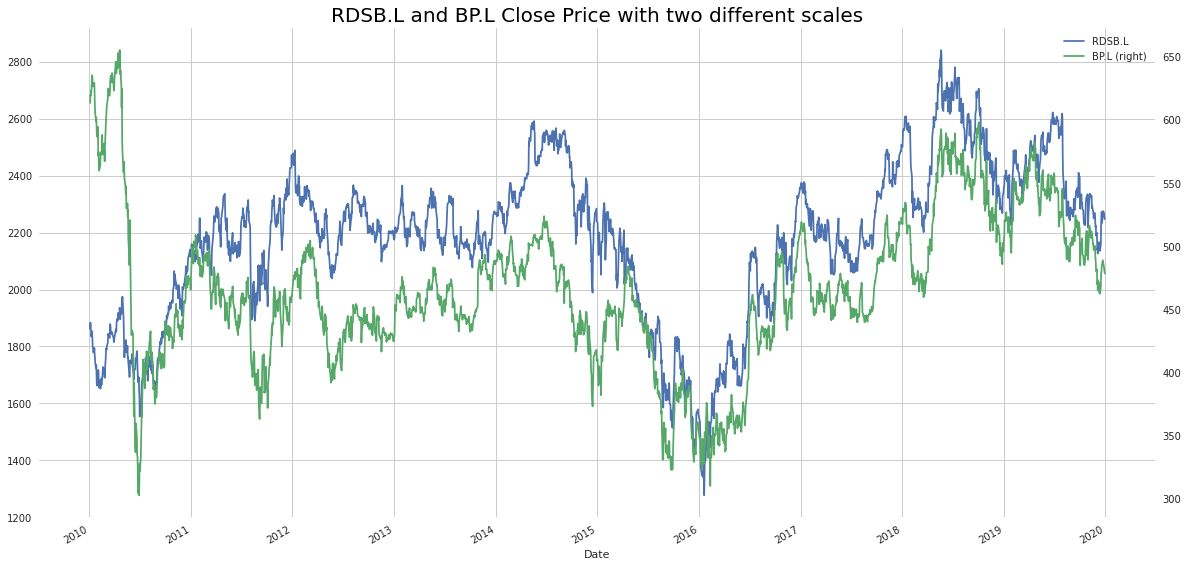

In [ ]:
# Plot on two different scales as BP.L appears less volatile than it actually is

sns.set_style("white")
ax = oil_stocks_close.plot(secondary_y = ["BP.L"], grid = True, legend = True, figsize=(20,10))
plt.title('RDSB.L and BP.L Close Price with two different scales', color = 'black', fontsize = 20);

In [ ]:
cointegration(rdsb_historical['Close'], bp_historical['Close'])

The series are cointegrated
p-value =  0.015633631426388864


The result of the cointegration test is interesting this time as the p-value is less than 0.05 thus rejecting the null hypothesis that there is no cointegration between RDSB.L and BP.L.

In [ ]:
# Cointegration test 

coint_t, pval, crit_val = coint(stock3, stock4) # It is nearly as easy to use cointegration
print(f'The test statistic is {coint_t}, the p-value is {pval} \n and the critical values to be significant at the 1% / 5% / 10% levels are {crit_val}')

The test statistic is -3.7531481069241406, the p-value is 0.015633631426388864 
 and the critical values to be significant at the 1% / 5% / 10% levels are [-3.90079646 -3.33855861 -3.04613545]


In [ ]:
# Choose the two oil stocks as they are cointegrated and the same industry.

oil_stocks_df = oil_stocks_close.copy()
oil_stocks_df

RDSB.L        BP.L
Date                          
2010-01-04  1862.5  613.599976
2010-01-05  1883.5  620.099976
2010-01-06  1859.0  619.400024
2010-01-07  1855.0  623.299988
2010-01-08  1835.0  621.700012
...            ...         ...
2019-12-20  2233.5  485.049988
2019-12-23  2259.0  489.049988
2019-12-24  2275.5  487.700012
2019-12-27  2271.0  483.950012
2019-12-30  2247.5  478.500000

[2518 rows x 2 columns]

In [ ]:
# Another check for stationarity is the ratio between the two oil stocks

oil_stocks_df['Ratio'] = rdsb_historical['Close'] / bp_historical['Close']

oil_ratio = oil_stocks_df.iloc[:, 2]

stationarity(oil_ratio)

The series is stationary
p-value =  0.00013814776946209013


In [ ]:
# Dataframe with Ratio column

oil_stocks_df

RDSB.L        BP.L     Ratio
Date                                    
2010-01-04  1862.5  613.599976  3.035365
2010-01-05  1883.5  620.099976  3.037413
2010-01-06  1859.0  619.400024  3.001291
2010-01-07  1855.0  623.299988  2.976095
2010-01-08  1835.0  621.700012  2.951584
...            ...         ...       ...
2019-12-20  2233.5  485.049988  4.604680
2019-12-23  2259.0  489.049988  4.619160
2019-12-24  2275.5  487.700012  4.665778
2019-12-27  2271.0  483.950012  4.692633
2019-12-30  2247.5  478.500000  4.696970

[2518 rows x 3 columns]

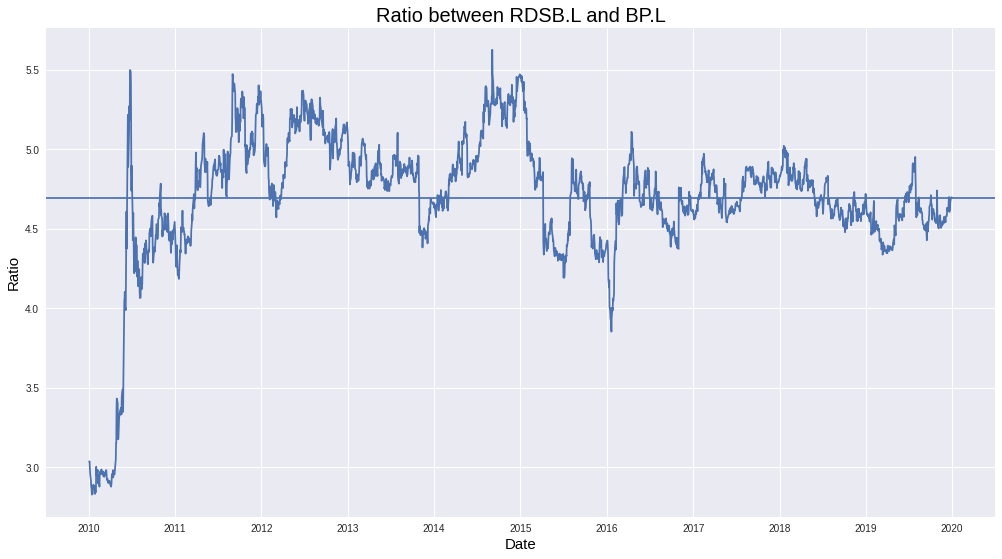

In [ ]:
# Plot ratio between RDSB.L and BP.L

plt.figure(figsize=(17, 9))
sns.lineplot(x=oil_stocks_df.index, y=oil_stocks_df.Ratio) 
plt.axhline(oil_stocks_df.Ratio.mean())
plt.grid(True)
plt.xlabel('Date', color = 'black', fontsize = 15)
plt.ylabel('Ratio', color = 'black', fontsize = 15)
plt.title('Ratio between RDSB.L and BP.L', color = 'black', fontsize = 20);

Calculating the ratio between RDSB.L and BP.L and plotting it shows that the stocks appear to vary around a constant mean, and the spread appears to satisfy the stationarity test as well.

In [ ]:
# Further work could include backtesting a dollar-neutral pairs trading strategy on RBSB.L and BP.L with following conditions:

holding_period = 60
lookback = 9
upper_barrier = 2
lower_barrier = -2


In [ ]:
# Add column for the mean

oil_stocks_df['Mean'] = ''


In [ ]:
# Standardisation assuming the spread

for i in range(len(oil_stocks_df)):
  try:
    oil_stocks_df.iloc[i, 3] = (oil_stocks_df.iloc[i - lookback:i + 1, 2].mean())
  except IndexError:
    pass

In [ ]:
# Add column for Standard deviation

oil_stocks_df['StdDev'] = ''


In [ ]:
# Calculate the Standard deviation

for i in range(len(oil_stocks_df)):
  oil_stocks_df.iloc[i, 4] = ((oil_stocks_df.iloc[i - lookback:i + 1, 2].std()))

In [ ]:
# Add column for Standardised Ratio

oil_stocks_df['StdRatio'] = ''

In [ ]:
# Standardise the ratio in order to normalise the signals

for i in range(len(oil_stocks_df)):
  oil_stocks_df.iloc[i, 5] = (oil_stocks_df.iloc[i, 2] - oil_stocks_df.iloc[i, 3]) / oil_stocks_df.iloc[i, 4]

In [ ]:
oil_stocks_df

RDSB.L        BP.L     Ratio     Mean     StdDev  StdRatio
Date                                                                  
2010-01-04  1862.5  613.599976  3.035365      NaN        NaN       NaN
2010-01-05  1883.5  620.099976  3.037413      NaN        NaN       NaN
2010-01-06  1859.0  619.400024  3.001291      NaN        NaN       NaN
2010-01-07  1855.0  623.299988  2.976095      NaN        NaN       NaN
2010-01-08  1835.0  621.700012  2.951584      NaN        NaN       NaN
...            ...         ...       ...      ...        ...       ...
2019-12-20  2233.5  485.049988  4.604680  4.63034   0.039577 -0.648302
2019-12-23  2259.0  489.049988  4.619160  4.63432  0.0356829 -0.424942
2019-12-24  2275.5  487.700012  4.665778  4.64139  0.0340175  0.717029
2019-12-27  2271.0  483.950012  4.692633  4.64751  0.0373669    1.2076
2019-12-30  2247.5  478.500000  4.696970  4.65572  0.0384064   1.07412

[2518 rows x 6 columns]

In [ ]:
# Clean up data by dropping NaNs
oil_stocks_df.dropna(inplace=True)
oil_stocks_df

RDSB.L        BP.L     Ratio     Mean     StdDev  StdRatio
Date                                                                  
2010-01-15  1779.0  629.000000  2.828299  2.93505  0.0762282  -1.40036
2010-01-18  1781.5  629.000000  2.832273  2.91474  0.0735377  -1.12137
2010-01-19  1795.0  629.500000  2.851469  2.89614  0.0616132 -0.725048
2010-01-20  1773.0  619.500000  2.861985  2.88221  0.0498167 -0.406006
2010-01-21  1764.0  610.299988  2.890382  2.87364  0.0377907  0.443014
...            ...         ...       ...      ...        ...       ...
2019-12-20  2233.5  485.049988  4.604680  4.63034   0.039577 -0.648302
2019-12-23  2259.0  489.049988  4.619160  4.63432  0.0356829 -0.424942
2019-12-24  2275.5  487.700012  4.665778  4.64139  0.0340175  0.717029
2019-12-27  2271.0  483.950012  4.692633  4.64751  0.0373669    1.2076
2019-12-30  2247.5  478.500000  4.696970  4.65572  0.0384064   1.07412

[2509 rows x 6 columns]

In [ ]:
# Check data types

oil_stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2509 entries, 2010-01-15 to 2019-12-30
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RDSB.L    2509 non-null   float64
 1   BP.L      2509 non-null   float64
 2   Ratio     2509 non-null   float64
 3   Mean      2509 non-null   object 
 4   StdDev    2509 non-null   object 
 5   StdRatio  2509 non-null   object 
dtypes: float64(3), object(3)
memory usage: 137.2+ KB


In [ ]:
# Convert data types for Mean and StdDev from object to float

oil_stocks_df["Mean"] = oil_stocks_df.Mean.astype(float)
oil_stocks_df["StdDev"] = oil_stocks_df.StdDev.astype(float)
oil_stocks_df["StdRatio"] = oil_stocks_df.StdRatio.astype(float)

In [ ]:
# Check data types

oil_stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2509 entries, 2010-01-15 to 2019-12-30
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RDSB.L    2509 non-null   float64
 1   BP.L      2509 non-null   float64
 2   Ratio     2509 non-null   float64
 3   Mean      2509 non-null   float64
 4   StdDev    2509 non-null   float64
 5   StdRatio  2509 non-null   float64
dtypes: float64(6)
memory usage: 137.2 KB


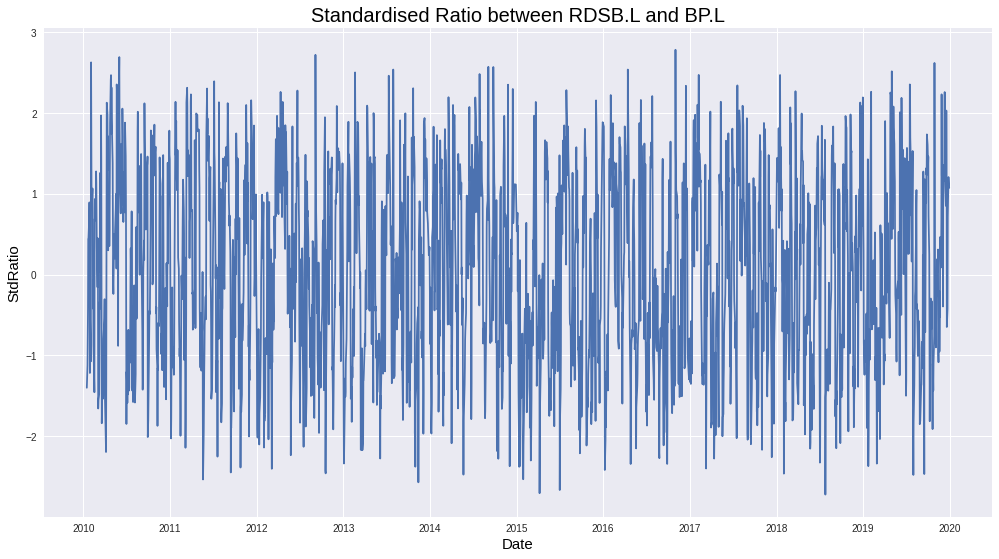

In [ ]:
# Plot Standardised Ratio between RDSB.L and BP.L

plt.figure(figsize=(17, 9))
sns.lineplot(x=oil_stocks_df.index, y=oil_stocks_df.StdRatio) 
plt.grid(True)
plt.xlabel('Date', color = 'black', fontsize = 15)
plt.ylabel('StdRatio', color = 'black', fontsize = 15)
plt.title('Standardised Ratio between RDSB.L and BP.L', color = 'black', fontsize = 20);

The arbitrarily chosen barriers of 2 and -2 would be used to initiate trades. If the standardised ratio reached -2 we would go long the ratio, and if it reached 2 we would short the ratio. 

## 5.4 Volume Trading Strategies

Volume trading is a measure of how much of a given financial asset has traded in a period of time. Volume traders look for instances of increased buying or selling orders. They also pay attention to current price trends and potential price movements. Generally, increased trading volume will lean heavily towards buy orders.

### 5.4.1 On Balance Volume (OBV)

OBV is a momentum-based indicator which measures volume flow to gauge the direction of the trend. Volume and price rise are directly proportional and OBV can be used as a confirmation tool with regards to price trends. A rising price is depicted by a rising OBV and a falling OBV stands for a falling price. 

It is a  cumulative total of the up and down volume. When the close is higher than the previous close, the volume is added to the running
total, and when the close is lower than the previous close, the volume is subtracted
from the running total.

In [ ]:
# Create copy of dataframe for AZN.L stock

azn_obv = azn.copy()
azn_obv

Open    High          Low   Close    Adj Close   Volume
Date                                                                 
2010-01-04  2912.0  2946.0  2912.000000  2941.0  1775.206909  2091679
2010-01-05  2936.0  2949.5  2901.000000  2907.5  1754.986084  2869739
2010-01-06  2909.0  2909.0  2850.500000  2875.0  1735.368652  3136541
2010-01-07  2879.0  2925.5  2879.000000  2910.5  1756.796875  3748200
2010-01-08  2921.0  2927.5  2889.500000  2908.5  1755.589600  2473846
...            ...     ...          ...     ...          ...      ...
2019-12-20  7658.0  7808.0  7614.000000  7808.0  7592.499512  5860381
2019-12-23  7771.0  7824.0  7723.870117  7746.0  7532.210938  2183949
2019-12-24  7715.0  7794.0  7631.290039  7714.0  7501.093750   378885
2019-12-27  7706.0  7781.0  7641.000000  7745.0  7531.238281   862283
2019-12-30  7734.0  7767.0  7654.000000  7654.0  7442.750488  1394124

[2518 rows x 6 columns]

In [ ]:
# Create dataframe for slice of AZN.L stock for 6 months July - Dec 2019

azn_obv_6mo = azn_obv['2019-07-01':'2019-12-31']
azn_obv_6mo

Open    High          Low   Close    Adj Close   Volume
Date                                                                 
2019-07-01  6465.0  6516.0  6436.000000  6469.0  6226.950684  2419796
2019-07-02  6493.0  6548.0  6457.000000  6532.0  6287.593750  1755274
2019-07-03  6559.0  6634.0  6519.000000  6602.0  6354.974609  1362292
2019-07-04  6606.0  6611.0  6548.000000  6578.0  6331.872559   925371
2019-07-05  6577.0  6609.0  6509.000000  6527.0  6282.780273  1156314
...            ...     ...          ...     ...          ...      ...
2019-12-20  7658.0  7808.0  7614.000000  7808.0  7592.499512  5860381
2019-12-23  7771.0  7824.0  7723.870117  7746.0  7532.210938  2183949
2019-12-24  7715.0  7794.0  7631.290039  7714.0  7501.093750   378885
2019-12-27  7706.0  7781.0  7641.000000  7745.0  7531.238281   862283
2019-12-30  7734.0  7767.0  7654.000000  7654.0  7442.750488  1394124

[128 rows x 6 columns]

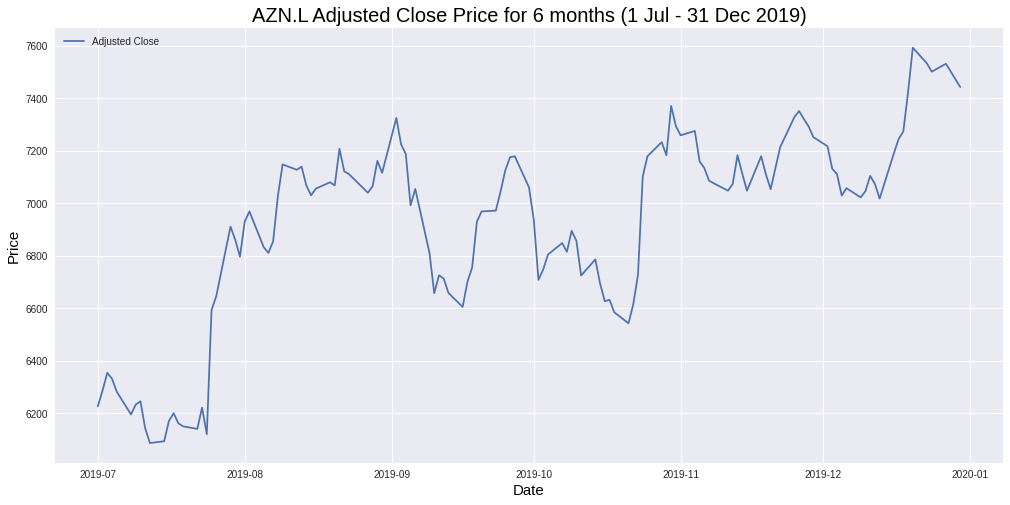

In [ ]:
# Plot AZN.L Adjusted Close price for the time period

def obv_adj():
  plt.figure(figsize=(17, 8))
  plt.style.use('seaborn')
  plt.plot(azn_obv_6mo['Adj Close'], label = 'Adjusted Close')
  plt.title('AZN.L Adjusted Close Price for 6 months (1 Jul - 31 Dec 2019)', color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Price', color = 'black', fontsize = 15)
  plt.legend()
  plt.show()

obv_adj()

In [ ]:
# Calculate the OBV

OBV = []
OBV.append(0)

for i in range(1, len(azn_obv_6mo['Adj Close'])):
  if azn_obv_6mo['Adj Close'][i] > azn_obv_6mo['Adj Close'][i-1]:
    OBV.append(OBV[-1] + azn_obv_6mo.Volume[i])
  elif azn_obv_6mo['Adj Close'][i] < azn_obv_6mo['Adj Close'][i-1]:
    OBV.append(OBV[-1] - azn_obv_6mo.Volume[i])
  else:
    OBV.append(OBV[-1])


In [ ]:
# Store OBV and OBV EMA in new columns

azn_obv_6mo['OBV'] = OBV
azn_obv_6mo['OBV_EMA'] = azn_obv_6mo['OBV'].ewm(span=20).mean()
azn_obv_6mo

Open    High          Low  ...   Volume       OBV       OBV_EMA
Date                                     ...                                 
2019-07-01  6465.0  6516.0  6436.000000  ...  2419796         0  0.000000e+00
2019-07-02  6493.0  6548.0  6457.000000  ...  1755274   1755274  9.215189e+05
2019-07-03  6559.0  6634.0  6519.000000  ...  1362292   3117566  1.727894e+06
2019-07-04  6606.0  6611.0  6548.000000  ...   925371   2192195  1.861931e+06
2019-07-05  6577.0  6609.0  6509.000000  ...  1156314   1035881  1.662116e+06
...            ...     ...          ...  ...      ...       ...           ...
2019-12-20  7658.0  7808.0  7614.000000  ...  5860381  20857886  9.873898e+06
2019-12-23  7771.0  7824.0  7723.870117  ...  2183949  18673937  1.071200e+07
2019-12-24  7715.0  7794.0  7631.290039  ...   378885  18295052  1.143420e+07
2019-12-27  7706.0  7781.0  7641.000000  ...   862283  19157335  1.216974e+07
2019-12-30  7734.0  7767.0  7654.000000  ...  1394124  17763211  1.270245e+07

[128 rows x 8 columns]

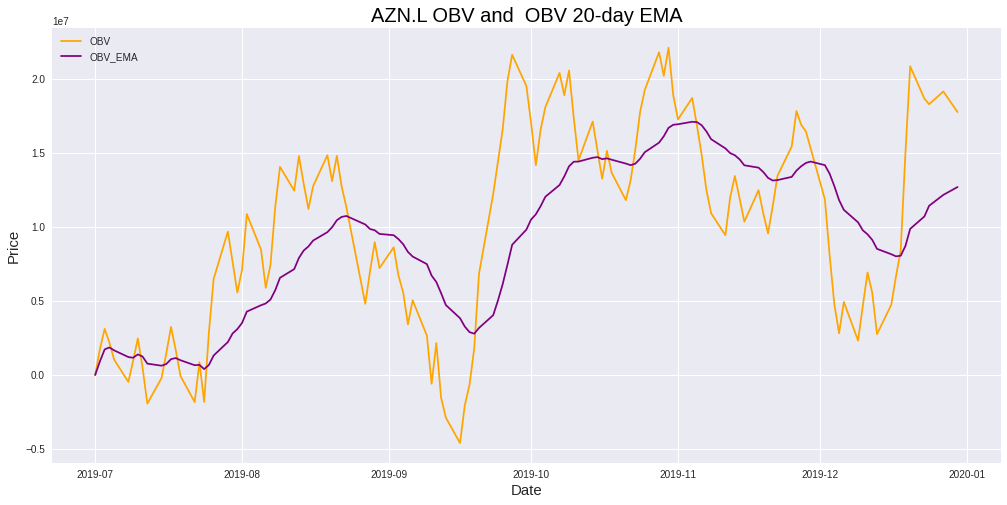

In [ ]:
# Plot OBV and OBV with EMA of 20 days

def obv_ema():
  plt.figure(figsize=(17, 8))
  plt.style.use('seaborn')
  plt.plot(azn_obv_6mo['OBV'], label = 'OBV', color = 'orange')
  plt.plot(azn_obv_6mo['OBV_EMA'], label = 'OBV_EMA', color = 'purple')
  plt.title('AZN.L OBV and  OBV 20-day EMA', color = 'black', fontsize = 20)
  plt.xlabel('Date', fontsize = 15)
  plt.ylabel('Price', fontsize = 15)
  plt.legend(loc = 'upper left')
  plt.show()

obv_ema()

The strategy is to buy the stock whenever the OBV goes above the OBV EMA and sell whenever the OBV EMA goes above the OBV.

In [ ]:
# Create function to signal when to buy and sell the stock
# If OBV > OBV_EMA then buy
# If OBV < OBV_EMA then sell
# Else do nothing

def buy_sell_obv(signal, col1, col2):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1

  for i in range(0, len(signal)):
    # If OBV > OBV_EMA then buy --> col1 => If OBV < OBV_EMA then sell => 'OBV_EMA'
    if signal[col1][i] > signal[col2][i] and flag != 1:
      sigPriceBuy.append(signal['Adj Close'][i])
      sigPriceSell.append(np.nan)
      flag = 1
     # If OBV < OBV_EMA then sell
    elif signal[col1][i] < signal[col2][i] and flag != 0:
      sigPriceSell.append(signal['Adj Close'][i])
      sigPriceBuy.append(np.nan)
      flag = 0
    else:
      sigPriceSell.append(np.nan)
      sigPriceBuy.append(np.nan)

  return (sigPriceBuy, sigPriceSell)

In [ ]:
# Create buy and sell columns

x = buy_sell_obv(azn_obv_6mo, 'OBV', 'OBV_EMA')
azn_obv_6mo['Buy_Signal_Price'] = x[0]
azn_obv_6mo['Sell_Signal_Price'] = x[1]

azn_obv_6mo

Open    High  ...  Buy_Signal_Price  Sell_Signal_Price
Date                        ...                                     
2019-07-01  6465.0  6516.0  ...               NaN                NaN
2019-07-02  6493.0  6548.0  ...        6287.59375                NaN
2019-07-03  6559.0  6634.0  ...               NaN                NaN
2019-07-04  6606.0  6611.0  ...               NaN                NaN
2019-07-05  6577.0  6609.0  ...               NaN        6282.780273
...            ...     ...  ...               ...                ...
2019-12-20  7658.0  7808.0  ...               NaN                NaN
2019-12-23  7771.0  7824.0  ...               NaN                NaN
2019-12-24  7715.0  7794.0  ...               NaN                NaN
2019-12-27  7706.0  7781.0  ...               NaN                NaN
2019-12-30  7734.0  7767.0  ...               NaN                NaN

[128 rows x 10 columns]

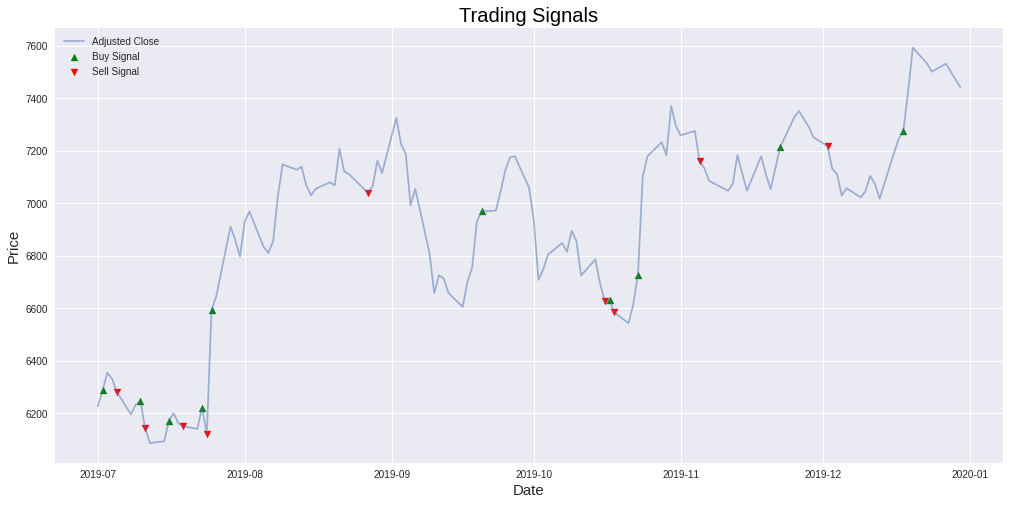

In [ ]:
# Plot buy and sell trading signals

def obv_sig():
  plt.figure(figsize=(17, 8))
  plt.style.use('seaborn')
  plt.plot(azn_obv_6mo['Adj Close'], label = 'Adjusted Close', alpha = 0.5)
  plt.scatter(azn_obv_6mo.index, azn_obv_6mo['Buy_Signal_Price'], label = 'Buy Signal', marker = '^', alpha = 1, color = 'green')
  plt.scatter(azn_obv_6mo.index, azn_obv_6mo['Sell_Signal_Price'], label = 'Sell Signal', marker = 'v', alpha = 1, color = 'red')
  plt.title('Trading Signals', color = 'black', fontsize = 20)
  plt.xlabel('Date', fontsize = 15)
  plt.ylabel('Price', fontsize = 15)
  plt.legend(loc = 'upper left')
  plt.show()

obv_sig()

## 6. Conclusion

It is almost certainly better to choose technical indicators that complement each other, not just those that move in unison and generate the same signals. The intuition here is that the more indicators you have that confirm each other, the better your chances are to profit. This can be done by combining strategies to form a system, and looking for multiple signals.